In [365]:
import pandas as pd
import json
import os
from langchain.prompts.chat import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
import json
from dotenv import load_dotenv
import os
from pydantic import BaseModel, Field, model_validator
import glob
import os
import numpy as np
from matplotlib import pyplot as plt

In [438]:
def extract_option_logprobs(logprobs_dict):
    try:
        # Find the index of 'Final' token
        logprobs_dict = eval(logprobs_dict)
        tokens = logprobs_dict['content']
        final_idx = None
        for i, token_info in enumerate(tokens):
            if token_info['token'] == 'answer':
                final_idx = i
                break
                
        if final_idx is None:
            return -1
            
        # Look for option token in the next 5 tokens
        option_logprobs = {}
        for i in range(final_idx, min(final_idx + 5, len(tokens))):
            token = tokens[i]['token'].strip()
            # Check if token matches pattern ' X' where X is a letter A-H
            if len(token) == 2 and token[0] in 'ABCDEFGH':
                option_logprobs[token[0]] = tokens[i]['logprob']
                break
                    
        return tokens[i]['logprob']
    except Exception as e:
        print(f"Error processing logprobs: {str(e)}")
        return -1


def extract_complete_answer(row):
    """
    Extracts the complete answer from the question based on the correct answer letter.
    Handles both Yes/No answers and lettered options (A,B,C,etc).
    """
    question = str(row['Question'])
    correct_answer = str(row['Correct Answer']).strip()
    
    # Handle Yes/No answers
    if correct_answer in ['Yes', 'No']:
        return correct_answer
    
    # For lettered options
    try:
        # Split by either newline or comma
        if '\n' in question[-10:]:
            # Handle newline-separated options
            options = [opt.strip() for opt in question.split('\n') if opt.strip()]
            for opt in options:
                if opt.startswith(f"{correct_answer})") or opt.startswith(f"{correct_answer} )"):
                    return opt.strip()
        
        # Handle comma-separated options
        if 'options are:' in question.lower() or 'options:' in question.lower():
            # Find the options part
            options_part = question.split('options are:')[-1] if 'options are:' in question.lower() else question.split('options:')[-1]
            options = [opt.strip() for opt in options_part.split(',')]
            for opt in options:
                if opt.strip().startswith(f"{correct_answer})") or opt.strip().startswith(f"{correct_answer} )"):
                    return opt.strip()
        
        # If no match found, return original answer letter
        return correct_answer
        
    except Exception as e:
        print(f"Error processing question: {e}")
        return correct_answer

# Apply the function to create new column

def evaluate_llm_answers(df):
    """
    Evaluates LLM answers against correct answers and adds a Correctness column.
    1 = correct answer (matching first letter and answer is substring of complete answer)
    0 = incorrect answer
    -1 = format error
    
    Args:
        df: DataFrame containing 'llm_answer', 'Correct Answer', and 'complete_answer' columns
    
    Returns:
        DataFrame with new Correctness column and evaluation statistics
    """
    # Create Correctness column initialized with -1 (format error)
    df['Correctness'] = -1
    df['complete_answer'] = df.apply(extract_complete_answer, axis=1)
    stats = {
        'total': len(df),
        'correct': 0,
        'incorrect': 0,
        'format_errors': 0,
        'letter_match_only': 0,  # For debugging: cases where letter matches but content doesn't
    }
    
    valid_options = set('ABCDEFGHIJKNY')
    
    for idx, row in df.iterrows():
        llm_answer = str(row['llm_answer']).strip()
        correct_answer = str(row['Correct Answer']).strip()
        complete_answer = str(row['complete_answer']).strip()
        
        # Extract first letter from LLM answer
        first_letter = llm_answer[0] if llm_answer else ''
        
        # Check if first letter is a valid option
        if first_letter not in valid_options:
            stats['format_errors'] += 1
            
        # Check both conditions:
        # 1. First letter matches
        # 2. LLM answer is a substring of complete answer (case-insensitive)
        letter_matches = (first_letter == correct_answer)
        content_matches = (llm_answer.lower() in complete_answer.lower())
        
        if letter_matches:
            df.at[idx, 'Correctness'] = 1
            stats['correct'] += 1
        elif content_matches:
            df.at[idx, 'Correctness'] = 1
            stats['correct'] += 1
        else:
            df.at[idx, 'Correctness'] = 0
            stats['incorrect'] += 1
    
    # Calculate accuracy (excluding format errors)
    valid_answers = stats['total'] - stats['format_errors']
    accuracy = stats['correct'] / valid_answers if valid_answers > 0 else 0
    stats['accuracy'] = accuracy
    
    return df




In [439]:
# Process cases with -1 confidence for Claude Haiku

# haiku_neg_conf_df = df_haiku_no_exp[df_haiku_no_exp['llm_confidence'] == -1].copy()
# haiku_neg_conf_df
# if len(haiku_neg_conf_df) > 0:
#     haiku_reprocessed = process_dataset(haiku_neg_conf_df, llm_claude, "claude_haiku_no_exp_reprocessed.csv", messages_format_no_exp_with_conf[0][1])
#     # Update original dataframe with reprocessed results
#     df_haiku_no_exp.update(haiku_reprocessed)
#     # Save updated dataframe
#     df_haiku_no_exp.to_csv('data/Results/claude_haiku_no_exp.csv', index=False)
#     print(f"Updated {len(haiku_neg_conf_df)} cases in Claude Haiku no exp dataset")

# # Print final stats
# print("\nFinal Statistics:")
# print(f"Llama 70B with explanations: {len(df_llama_70b_exp[df_llama_70b_exp['llm_confidence'] == -1])} remaining cases with -1 confidence")
# print(f"Claude Haiku without explanations: {len(df_haiku_no_exp[df_haiku_no_exp['llm_confidence'] == -1])} remaining cases with -1 confidence")

In [440]:
# Get all CSV files in data/Results directory
csv_files = glob.glob('data/Results/*.csv')

# Initialize empty dictionary to store dataframes
dfs = {}

# Read each CSV file and organize into reasoning/no-reasoning categories
reasoning_dfs = {}
no_reasoning_dfs = {}
names = {'reasoning': [], 'no_reasoning': []}

for file in csv_files:
    filename = os.path.basename(file)
    df_name = 'df_' + filename.replace('.csv','').replace('-','_').replace('.','_')
    df = pd.read_csv(file)
    
    # Print stats before cleaning
    import re
    
    print(f"\nStats for {filename}:")
    print(f"Total rows: {len(df)}")
    
    # Check for -1 values
    minus_one_count = len(df[(df['llm_confidence'] == '-1') | (df['llm_confidence'] == -1)])
    print(f"Rows with confidence -1: {minus_one_count}")
    
    # Check for non-numeric values and try to extract floats
    non_numeric = df[pd.to_numeric(df['llm_confidence'], errors='coerce').isna()]
    print(f"Rows with non-numeric confidence: {len(non_numeric)}")
    
    # Try to extract floats using regex
    extracted = 0
    for idx in non_numeric.index:
        val = str(df.loc[idx, 'llm_confidence'])
        # Match pattern: optional minus sign, digits, optional decimal point and digits
        match = re.search(r'-?\d+\.?\d*', val)
        if match:
            try:
                float_val = float(match.group())
                df.loc[idx, 'llm_confidence'] = float_val
                extracted += 1
            except:
                df.loc[idx, 'llm_confidence'] = -1
        else:
            df.loc[idx, 'llm_confidence'] = -1
            
    print(f"Successfully extracted floats from {extracted} non-numeric values")
    print(f"DataFrame name created: {df_name}")
    
    # Remove rows where confidence is -1 or invalid
    df = df[(df['llm_confidence'] != '-1') & (df['llm_confidence'] != -1)]
    df['llm_confidence'] = pd.to_numeric(df['llm_confidence'], errors='coerce')
    df = df.dropna(subset=['llm_confidence'])
    
    # Extract token counts based on model type
    try:
            df['completion_tokens'] = df['token_usage'].apply(
                lambda x: eval(x)['completion_tokens'] if pd.notnull(x) else np.nan
            )
    except:   
            df['completion_tokens'] = df['token_usage'].apply(
                lambda x:1.8 * eval(x)['output_tokens'] if pd.notnull(x) else np.nan
            )    
    print(f"Rows after cleaning: {len(df)}")
    
    # Categorize based on filename
    if filename.endswith('no_exp.csv'):
        no_reasoning_dfs[df_name] = df
        names['no_reasoning'].append(filename.replace('.csv',''))
    else:
        reasoning_dfs[df_name] = df
        names['reasoning'].append(filename.replace('.csv',''))

print("\nReasoning DataFrame names:")
for df_name in reasoning_dfs.keys():
    print(df_name)

print("\nNo-Reasoning DataFrame names:")
for df_name in no_reasoning_dfs.keys():
    print(df_name)

# Combine dictionaries for locals().update()
dfs = {**reasoning_dfs, **no_reasoning_dfs}

# Create variables for each dataframe
locals().update(dfs)

# Apply evaluation to all dataframes
for df_name, df in dfs.items():    
    # Create new dataframe name with _new suffix
    new_df_name = f"{df_name}_new"
    
    # Evaluate answers
    new_df = evaluate_llm_answers(df)
    
    # Store result in new variable
    globals()[new_df_name] = new_df
    
        
    # Print results
    print(f"\nCorrectness Distribution for {new_df_name}:")
    print(new_df['Correctness'].value_counts())


Stats for openai_4omini_sc.csv:
Total rows: 3148
Rows with confidence -1: 131
Rows with non-numeric confidence: 0
Successfully extracted floats from 0 non-numeric values
DataFrame name created: df_openai_4omini_sc
Rows after cleaning: 3017

Stats for xai_grok2_sc.csv:
Total rows: 3148
Rows with confidence -1: 9
Rows with non-numeric confidence: 11
Successfully extracted floats from 11 non-numeric values
DataFrame name created: df_xai_grok2_sc
Rows after cleaning: 3139

Stats for openai_o3mini_low.csv:
Total rows: 3148
Rows with confidence -1: 0
Rows with non-numeric confidence: 0
Successfully extracted floats from 0 non-numeric values
DataFrame name created: df_openai_o3mini_low
Rows after cleaning: 3148

Stats for openai_4omini_noexp.csv:
Total rows: 3148
Rows with confidence -1: 15
Rows with non-numeric confidence: 0
Successfully extracted floats from 0 non-numeric values
DataFrame name created: df_openai_4omini_noexp
Rows after cleaning: 3133

Stats for openai_4omini_cot.csv:
Total

In [206]:
import numpy as np
import pandas as pd

def compute_group_metrics(dfs, n_bins=10):
    """
    Computes evaluation metrics for each DataFrame (model variant) and groups the results by model family.
    
    For each variant, the following metrics are computed:
      - Accuracy: Mean of the 'Correctness' column.
      - ECE: Expected Calibration Error computed using adaptive binning.
      - AvgCompletionTokens: Mean of the 'completion_tokens' column.
    
    The model family is defined as the part of the variant name before the last underscore.
    Within each family, the baseline is identified as the variant whose name ends with '_noexp' or '_low'
    (if available). The relative tokens difference is computed as:
    
        RelativeTokensDiff = AvgCompletionTokens (variant) - AvgCompletionTokens (baseline)
    
    Parameters:
        dfs (dict): A dictionary mapping variant names to pandas DataFrames.
        n_bins (int): The number of bins to use for computing ECE.
    
    Returns:
        pd.DataFrame: A summary DataFrame with columns:
                      'Variant', 'Family', 'Accuracy', 'ECE', 'AvgCompletionTokens', 'RelativeTokensDiff'
                      And category-specific metrics grouped by 'Name'
    """
    # List to hold metrics for each variant
    summary_list = []
    
    # Compute metrics for each model variant (DataFrame)
    for variant, df in dfs.items():
        # Overall metrics
        accuracy = df['Correctness'].mean()
        ece = compute_adaptive_ece(df, n_bins=n_bins)
        avg_tokens = df['completion_tokens'].mean()
        
        # Category-specific metrics
        category_metrics = df.groupby('Name').agg({
            'Correctness': 'mean',
            'completion_tokens': 'mean'
        }).round(3)
        
        category_metrics.columns = ['Category_Accuracy', 'Category_AvgTokens']
        
        # Compute ECE for each category
        category_ece = {}
        for category in df['Name'].unique():
            category_df = df[df['Name'] == category]
            category_ece[category] = compute_adaptive_ece(category_df, n_bins=n_bins)
        
        summary_list.append({
            "Variant": variant,
            "Accuracy": accuracy,
            "ECE": ece,
            "AvgCompletionTokens": avg_tokens,
            "CategoryMetrics": category_metrics,
            "CategoryECE": category_ece
        })
    
    # Create a DataFrame summarizing the overall metrics
    summary_df = pd.DataFrame([{
        "Variant": s["Variant"],
        "Accuracy": s["Accuracy"],
        "ECE": s["ECE"],
        "AvgCompletionTokens": s["AvgCompletionTokens"]
    } for s in summary_list])
    
    # Determine the model family
    summary_df['Family'] = summary_df['Variant'].apply(lambda x: x.rsplit('_', 1)[0] if '_' in x else x)
    
    # Initialize RelativeTokensDiff column
    summary_df['RelativeTokensDiff'] = np.nan
    
    # Compute relative token differences within each family
    for family, group in summary_df.groupby('Family'):
        baseline_rows = group[group['Variant'].str.endswith('noexp') | group['Variant'].str.endswith('low')]
        
        if baseline_rows.empty:
            print(f"No baseline (_noexp or _low) found for model family '{family}'. Skipping relative tokens difference.")
            continue
            
        baseline_avg = baseline_rows.iloc[0]['AvgCompletionTokens']
        summary_df.loc[summary_df['Family'] == family, 'RelativeTokensDiff'] = (
            summary_df.loc[summary_df['Family'] == family, 'AvgCompletionTokens'] - baseline_avg
        )
    
    # Add category-specific metrics to the output
    for s in summary_list:
        variant = s["Variant"]
        print(f"\nDetailed metrics for {variant}:")
        print("\nCategory-specific accuracies:")
        print(s["CategoryMetrics"]["Category_Accuracy"])
        print("\nCategory-specific average tokens:")
        print(s["CategoryMetrics"]["Category_AvgTokens"]) 
        print("\nCategory-specific ECE:")
        for category, ece in s["CategoryECE"].items():
            print(f"{category}: {ece:.3f}")
            
    return summary_df

# Example usage:
metrics_summary = compute_group_metrics(dfs, n_bins=10)
metrics_summary.sort_values(['Family', 'RelativeTokensDiff'])




Detailed metrics for df_openai_4o_cot:

Category-specific accuracies:
Name
BigBench_easy    0.605
BigBench_hard    0.965
GPQA_main        0.491
MMLUPro_test     0.722
MMLU_test        0.846
ProntoQA         0.970
Name: Category_Accuracy, dtype: float64

Category-specific average tokens:
Name
BigBench_easy    122.835
BigBench_hard    126.095
GPQA_main        293.645
MMLUPro_test     244.320
MMLU_test        161.459
ProntoQA         113.970
Name: Category_AvgTokens, dtype: float64

Category-specific ECE:
GPQA_main: 0.394
BigBench_easy: 0.391
BigBench_hard: 0.041
ProntoQA: 0.021
MMLU_test: 0.120
MMLUPro_test: 0.226

Detailed metrics for df_openai_4omini_sc:

Category-specific accuracies:
Name
BigBench_easy    0.457
BigBench_hard    0.573
GPQA_main        0.412
MMLUPro_test     0.591
MMLU_test        0.774
ProntoQA         0.838
Name: Category_Accuracy, dtype: float64

Category-specific average tokens:
Name
BigBench_easy    429.990
BigBench_hard    423.176
GPQA_main        621.588
MMLUPro

Variant  Accuracy       ECE  \
15  df_Meta_Llama_3_1_70B_Instruct_noexp  0.510821  0.423666   
9     df_Meta_Llama_3_1_70B_Instruct_cot  0.670480  0.277382   
13   df_Meta_Llama_3_1_8B_Instruct_noexp  0.423065  0.478789   
3      df_Meta_Llama_3_1_8B_Instruct_cot  0.524275  0.359652   
14                    df_openai_4o_noexp  0.633418  0.327589   
0                       df_openai_4o_cot  0.772092  0.184803   
5                 df_openai_4omini_noexp  0.525056  0.451468   
7                   df_openai_4omini_cot  0.629606  0.334092   
16                  df_openai_4omini_ltm  0.650959  0.295616   
1                    df_openai_4omini_sc  0.649652  0.327667   
12                   df_openai_o1_reason  0.872128  0.126773   
17                      df_openai_o1_low  0.829322  0.136171   
4                   df_openai_o3mini_low  0.810991  0.164698   
11               df_openai_o3mini_reason  0.841804  0.145086   
6                  df_openai_o3mini_high  0.851149  0.146054   
8                     df_xai_grok2_noexp  0.610229  0.349349   
10                      df_xai_grok2_cot  0.754397  0.206377   
18                      df_xai_grok2_ltm  0.731638  0.237943   
2                        df_xai_grok2_sc  0.729213  0.243528   

    AvgCompletionTokens                          Family  RelativeTokensDiff  
15            25.656270  df_Meta_Llama_3_1_70B_Instruct            0.000000  
9            195.931045  df_Meta_Llama_3_1_70B_Instruct          170.274776  
13            30.686524   df_Meta_Llama_3_1_8B_Instruct            0.000000  
3            256.494298   df_Meta_Llama_3_1_8B_Instruct          225.807773  
14            25.203939                    df_openai_4o            0.000000  
0            191.710108                    df_openai_4o          166.506169  
5             61.387807                df_openai_4omini            0.000000  
7            212.356296                df_openai_4omini          150.968489  
16           349.300617                df_openai_4omini          287.912810  
1            476.996023                df_openai_4omini          415.608215  
12          1181.733267                    df_openai_o1         -469.968046  
17          1651.701313                    df_openai_o1            0.000000  
4            236.006036                df_openai_o3mini            0.000000  
11           715.858005                df_openai_o3mini          479.851970  
6           1799.527473                df_openai_o3mini         1563.521437  
8             25.570521                    df_xai_grok2            0.000000  
10           195.888072                    df_xai_grok2          170.317551  
18           339.618760                    df_xai_grok2          314.048239  
2            586.747690                    df_xai_grok2          561.177169

In [15]:
# Process 4o models
df_openai_4o_exp['probability_of_answer'] = df_openai_4o_exp['logprobs'].apply(lambda x: extract_option_logprobs(x))
df_openai_4o_exp['probability_of_answer'] = df_openai_4o_exp['probability_of_answer'].fillna(-1)

df_openai_4o_no_exp['probability_of_answer'] = df_openai_4o_no_exp['logprobs'].apply(lambda x: extract_option_logprobs(x))
df_openai_4o_no_exp['probability_of_answer'] = df_openai_4o_no_exp['probability_of_answer'].fillna(-1)

# Process 4o-mini models
df_openai_4omini_exp['probability_of_answer'] = df_openai_4omini_exp['logprobs'].apply(lambda x: extract_option_logprobs(x))
df_openai_4omini_exp['probability_of_answer'] = df_openai_4omini_exp['probability_of_answer'].fillna(-1)

df_openai_4omini_no_exp['probability_of_answer'] = df_openai_4omini_no_exp['logprobs'].apply(lambda x: extract_option_logprobs(x))
df_openai_4omini_no_exp['probability_of_answer'] = df_openai_4omini_no_exp['probability_of_answer'].fillna(-1)

df_openai_4omini_LTM_exp['probability_of_answer'] = df_openai_4omini_LTM_exp['logprobs'].apply(lambda x: extract_option_logprobs(x))
df_openai_4omini_LTM_exp['probability_of_answer'] = df_openai_4omini_LTM_exp['probability_of_answer'].fillna(-1)

df_openai_4omini_SV_exp['probability_of_answer'] = df_openai_4omini_SV_exp['logprobs'].apply(lambda x: extract_option_logprobs(x))
df_openai_4omini_SV_exp['probability_of_answer'] = df_openai_4omini_SV_exp['probability_of_answer'].fillna(-1)

# Process grok models
df_xai_grok2_exp['probability_of_answer'] = df_xai_grok2_exp['logprobs'].apply(lambda x: extract_option_logprobs(x))
df_xai_grok2_exp['probability_of_answer'] = df_xai_grok2_exp['probability_of_answer'].fillna(-1)

df_xai_grok2_no_exp['probability_of_answer'] = df_xai_grok2_no_exp['logprobs'].apply(lambda x: extract_option_logprobs(x))
df_xai_grok2_no_exp['probability_of_answer'] = df_xai_grok2_no_exp['probability_of_answer'].fillna(-1)

df_xai_grok2_LTM_exp['probability_of_answer'] = df_xai_grok2_LTM_exp['logprobs'].apply(lambda x: extract_option_logprobs(x))
df_xai_grok2_LTM_exp['probability_of_answer'] = df_xai_grok2_LTM_exp['probability_of_answer'].fillna(-1)

df_xai_grok2_SV_exp['probability_of_answer'] = df_xai_grok2_SV_exp['logprobs'].apply(lambda x: extract_option_logprobs(x))
df_xai_grok2_SV_exp['probability_of_answer'] = df_xai_grok2_SV_exp['probability_of_answer'].fillna(-1)


NameError: name 'df_openai_4o_exp' is not defined

## Log_probs Analysis (TO DO for Confidence Eliciation Methods)

## We currenlty use Verbalized Confidence,  but we can will demonstrate P(sentence) and P(Answer)

Evaluation Results:
Total responses: 3148
Format errors: 126
Correct answers: 1948
Incorrect answers: 1200
Letter matches only: 0
Overall accuracy: 64.46%

Correctness Distribution:
Correctness
1    1948
0    1200
Name: count, dtype: int64


# Verbal Confidence Analysis

## Takeaway: In general reasoning helps improve the calibrations of LLMs

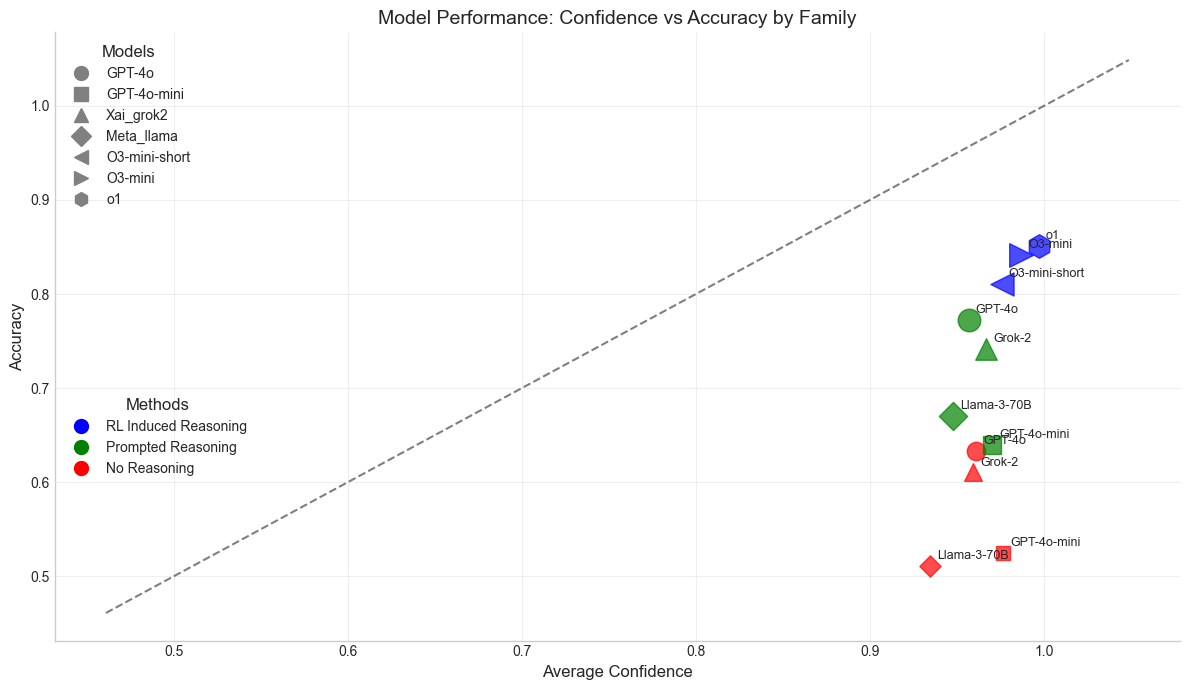

In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_adaptive_ece(df, n_bins=10):  # Reduced bins from 100 to 10 for more distinction
    """Compute ECE using adaptive binning with equal number of samples per bin"""
    df_clean = df.copy()
    df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
    
    # Sort by confidence and create bins with equal number of samples
    df_sorted = df_clean.sort_values('llm_confidence')
    bin_size = len(df_sorted) // n_bins
    
    ece = 0
    for i in range(n_bins):
        start_idx = i * bin_size
        end_idx = start_idx + bin_size if i < n_bins - 1 else len(df_sorted)
        bin_data = df_sorted.iloc[start_idx:end_idx]
        
        bin_conf = bin_data['llm_confidence'].mean()
        bin_acc = bin_data['Correctness'].mean()
        bin_prop = len(bin_data) / len(df_sorted)
        bin_error = abs(bin_acc - bin_conf)
        ece += bin_prop * bin_error
    
    return ece

def compute_mace(df):
    """Compute Mean Absolute Calibration Error (instance-wise)"""
    df_clean = df.copy()
    df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
    return abs(df_clean['llm_confidence'] - df_clean['Correctness']).mean()

def combined_visualization(dfs, names):
    """
    Create visualization with scatterplot and separate legends
    """
    # Define marker styles for different model families
    family_markers = {
        'GPT-4o': 'o',      # Circle for GPT-4
        'GPT-4o-mini': 's',  # Square for GPT-4-mini
        'df_xai_grok2': '^',      # Triangle up for Grok-2
        'df_Meta_Llama': 'D',     # Diamond for Llama
        'df_claude': 'v',         # Triangle down for Claude
        'O3-mini-short': '<',    # Triangle left for o3-mini-low
        'O3-mini': '>',  # Triangle right for o3-mini-medium  
        'o1-short': 'p',    # Pentagon for o3-mini-high
        'o1': 'h',            # Hexagon for GPT-o1
        'df_Qwen_QWQ': '*',             # Star for Qwen-QWQ
    }
    
    # Define colors for reasoning types
    reasoning_colors = {
        'RL Induced Reasoning': 'blue',
        'Prompted Reasoning': 'green', 
        'No Reasoning': 'red'
    }
    
    # Calculate metrics for scatterplot
    model_groups = {}
    
    for df_name, df in dfs.items():
        # Extract base model name and standardize naming
        if '4o-mini' in df_name or '4omini' in df_name:
            base_name = 'GPT-4o-mini'
            family = 'GPT-4o-mini'
        elif '4o_' in df_name:
            base_name = 'GPT-4o'
            family = 'GPT-4o'
        elif 'o3mini_low' in df_name:
            base_name = 'O3-mini-short'
            family = 'O3-mini-short'
        elif 'o3mini_reason' in df_name:
            base_name = 'O3-mini'
            family = 'O3-mini'
        elif 'o3mini_high' in df_name:
            base_name = 'O3-mini-high'
            family = 'O3-mini-high'
        elif 'o1_low' in df_name:
            base_name = 'o1_short'
            family = 'o1_short'
        elif 'o1_reason' in df_name:
            base_name = 'o1'
            family = 'o1'
        elif 'claude_haiku' in df_name:
            base_name = 'Claude-3.5-Haiku'
            family = 'df_claude'
        elif 'claude_sonnet' in df_name:
            base_name = 'Claude-3.7-Sonnet'
            family = 'df_claude'
        elif 'claude' in df_name:
            base_name = 'Claude'
            family = 'df_claude'
        elif 'Llama_3' in df_name or 'Meta_Llama' in df_name:
            if '70B' in df_name:
                base_name = 'Llama-3-70B'
                family = 'df_Meta_Llama'
            elif '8B' in df_name:
                base_name = 'Llama-3-8B'
                family = 'df_Meta_Llama'
            else:
                base_name = 'Llama-3'
                family = 'df_Meta_Llama'
        elif 'grok2' in df_name or 'xai_grok2' in df_name:
            base_name = 'Grok-2'
            family = 'df_xai_grok2'
        elif 'QWQ' in df_name:
            base_name = 'QWQ'
            family = 'df_Qwen_QWQ'
        else:
            base_name = df_name.split(' with')[0].split(' without')[0].strip()
            family = base_name
        
        # Determine reasoning type
        if df_name.endswith('noexp'):
            reasoning_type = 'No Reasoning'
        elif df_name.endswith('_cot') or df_name.endswith('_ltm') or df_name.endswith('_sc'):
            reasoning_type = 'Prompted Reasoning'
        else:
            reasoning_type = 'RL Induced Reasoning'
        
        if base_name not in model_groups:
            model_groups[base_name] = {'internal': [], 'prompted': [], 'no_reasoning': [], 'family': family}
        
        if reasoning_type == 'RL Induced Reasoning':
            model_groups[base_name]['internal'].append(df)
        elif reasoning_type == 'Prompted Reasoning':
            model_groups[base_name]['prompted'].append(df)
        else:
            model_groups[base_name]['no_reasoning'].append(df)
    
    # Calculate metrics for scatterplot
    scatter_metrics = []
    
    for base_name, group in model_groups.items():
        family = group['family']
        
        # Process internal reasoning models
        if group['internal']:
            internal_metrics = {
                'model': base_name,
                'family': family,
                'reasoning': 'RL Induced Reasoning',
                'avg_confidence': np.mean([df.loc[:,'llm_confidence'].astype(float).mean() for df in group['internal']]),
                'accuracy': np.mean([df.loc[:,'Correctness'].mean() for df in group['internal']]),
                'ece': np.mean([compute_adaptive_ece(df) for df in group['internal']])
            }
            scatter_metrics.append(internal_metrics)
        
        # Process prompted reasoning models
        if group['prompted']:
            prompted_metrics = {
                'model': base_name,
                'family': family,
                'reasoning': 'Prompted Reasoning',
                'avg_confidence': np.mean([df.loc[:,'llm_confidence'].astype(float).mean() for df in group['prompted']]),
                'accuracy': np.mean([df.loc[:,'Correctness'].mean() for df in group['prompted']]),
                'ece': np.mean([compute_adaptive_ece(df) for df in group['prompted']])
            }
            scatter_metrics.append(prompted_metrics)
        
        # Process models without reasoning
        if group['no_reasoning']:
            no_reasoning_metrics = {
                'model': base_name,
                'family': family,
                'reasoning': 'No Reasoning',
                'avg_confidence': np.mean([df.loc[:,'llm_confidence'].astype(float).mean() for df in group['no_reasoning']]),
                'accuracy': np.mean([df.loc[:,'Correctness'].mean() for df in group['no_reasoning']]),
                'ece': np.mean([compute_adaptive_ece(df) for df in group['no_reasoning']])
            }
            scatter_metrics.append(no_reasoning_metrics)
    
    # Convert to DataFrame
    scatter_df = pd.DataFrame(scatter_metrics)
    
    # Calculate min and max ECE for scaling bubble sizes - for ECE, smaller is better
    min_ece = scatter_df['ece'].min()
    max_ece = scatter_df['ece'].max()
    
    # Function to scale ECE to bubble size (inverse relationship - smaller ECE = larger bubble)
    def scale_size(ece):
        if max_ece == min_ece:  # Avoid division by zero
            return 150
        # Inverse scaling - smaller ECE gets larger bubbles
        normalized_value = 1 - ((ece - min_ece) / (max_ece - min_ece))
        return 100 + normalized_value * 200  # Scale from 100 to 300
    
    # Create figure
    fig = plt.figure(figsize=(12, 7))
    
    # Create main plot and a single legend area for both legends
    ax_main = plt.subplot2grid((1, 1), (0, 0))  # Main plot
    
    # Create scatter plot with family-specific markers
    for family in family_markers:
        for reasoning in reasoning_colors:
            mask = (scatter_df['family'] == family) & (scatter_df['reasoning'] == reasoning)
            if mask.any():
                # Get bubble sizes based on ECE for each point
                sizes = [scale_size(row['ece']) for _, row in scatter_df[mask].iterrows()]
                
                ax_main.scatter(scatter_df[mask]['avg_confidence'], 
                          scatter_df[mask]['accuracy'],
                          marker=family_markers[family],
                          c=reasoning_colors[reasoning],
                          s=sizes,  # Use scaled sizes based on ECE
                          alpha=0.7)
                
                # Add model names as annotations
                for _, row in scatter_df[mask].iterrows():
                    ax_main.annotate(row['model'],
                               (row['avg_confidence'], row['accuracy']),
                               xytext=(5, 5),
                               textcoords='offset points',
                               fontsize=9)
    
    # Add diagonal line for perfect calibration
    min_val = min(scatter_df['avg_confidence'].min(), scatter_df['accuracy'].min()) - 0.05
    max_val = max(scatter_df['avg_confidence'].max(), scatter_df['accuracy'].max()) + 0.05
    ax_main.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, 
             label='Perfect Calibration')
    
    ax_main.set_xlabel('Average Confidence', fontsize=12)
    ax_main.set_ylabel('Accuracy', fontsize=12)
    ax_main.set_title('Model Performance: Confidence vs Accuracy by Family', fontsize=14)
    ax_main.grid(True, alpha=0.3)
    
    # Customize appearance
    ax_main.spines['top'].set_visible(False)
    ax_main.spines['right'].set_visible(False)
    
    # Create separate legends
    # Models legend
    model_legend = []
    for family, marker in family_markers.items():
        if family in scatter_df['family'].values:  # Only include models that appear in the data
            # Format display name
            display_name = family
            if family.startswith('df_'):
                display_name = family[3:].capitalize()
            model_legend.append(plt.Line2D([0], [0], marker=marker, color='gray', 
                                        label=display_name, markersize=10, linestyle='None'))
    
    # Methods legend
    method_legend = []
    for reasoning, color in reasoning_colors.items():
        if reasoning in scatter_df['reasoning'].values:  # Only include methods that appear in the data
            method_legend.append(plt.Line2D([0], [0], marker='o', color=color,
                                          label=reasoning, markersize=10, linestyle='None'))
    
    # Add legends directly to the main plot in the top left
    first_legend = ax_main.legend(handles=model_legend, title='Models', 
                               loc='upper left', fontsize=10, title_fontsize=12)
    ax_main.add_artist(first_legend)
    
    # Add second legend below the first one
    ax_main.legend(handles=method_legend, title='Methods', 
                 loc='lower left', bbox_to_anchor=(0, 0.25), 
                 fontsize=10, title_fontsize=12)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig('../confidence_vs_accuracy_bubble.pdf', dpi=300, bbox_inches='tight')
    
    return fig

# Run the visualization with dfs dictionary
# fig = combined_visualization(dfs, list(dfs.keys()))
# plt.show()

# Run the visualization with dfs dictionary
# fig = combined_visualization(dfs, list(dfs.keys()))
# plt.show()

# Run the visualization with dfs dictionary
fig = combined_visualization(dfs, list(dfs.keys()))
plt.show() # The plot on the right might be redundant, but I keep it for now

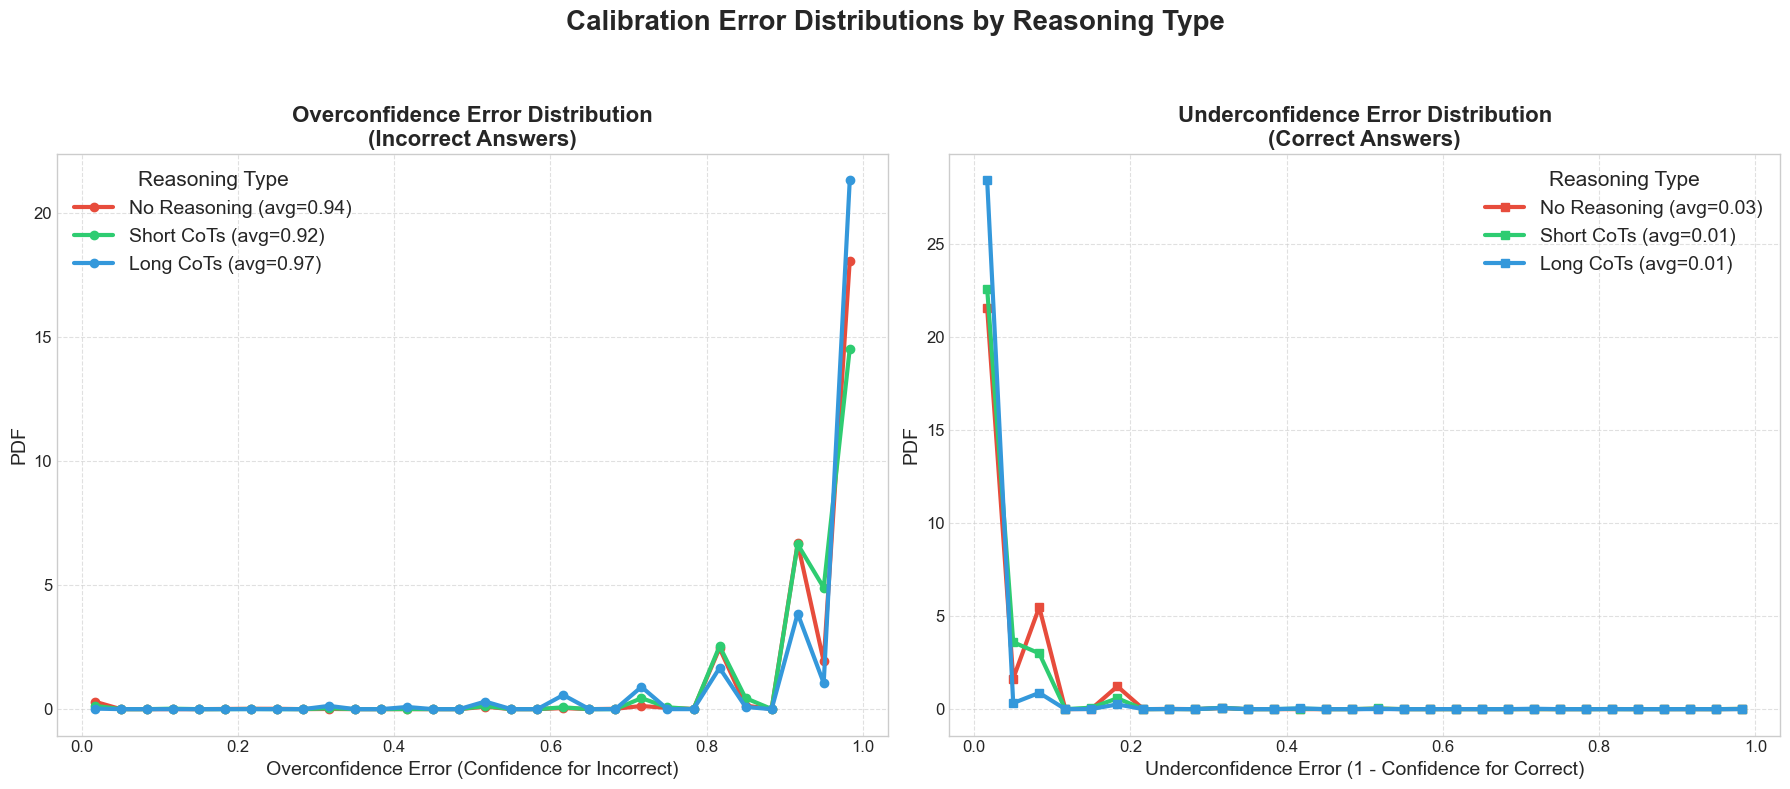

In [459]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_density(errors, bins=30):
    """
    Compute a density estimate for a 1D array of error values.
    Returns bin centers and density (normalized histogram).
    """
    hist, bin_edges = np.histogram(errors, bins=bins, range=(0, 1), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, hist

def plot_calibration_error_distributions(dfs, bins=30):
    """
    Given a dictionary mapping names to DataFrames (each having columns
    'llm_confidence' and 'Correctness'), group the DataFrames into three reasoning types:
       - "No Reasoning" (if df name ends with "noexp")
       - "Short CoTs" (if df name ends with "_cot", "_ltm", or "_sc")
       - "Long CoTs" (all other cases)
       
    Then compute for each group:
      - Overconfidence Error (OCE) for Incorrect Answers: error = confidence
      - Underconfidence Error (UCE) for Correct Answers: error = 1 - confidence
    
    Two subplots (side by side) are created in a single figure.
    """
    # Step 1: Map DataFrame names to the new categories
    groups = {
        "No Reasoning": [],
        "Short CoTs": [],
        "Long CoTs": []
    }
    
    for name, df in dfs.items():
        name_lower = name.lower()
        
        # Grouping logic
        if name_lower.endswith('noexp'):
            reasoning_type = "No Reasoning"
        elif (name_lower.endswith('_cot') or name_lower.endswith('_ltm') or name_lower.endswith('_sc')):
            reasoning_type = "Short CoTs"
        else:
            reasoning_type = "Long CoTs"
        
        groups[reasoning_type].append(df)
    
    # Step 2: Create containers for the two error distributions:
    # Overconfidence Error (Incorrect answers) = confidence
    # Underconfidence Error (Correct answers) = 1 - confidence
    errors_incorrect = {}  # OCE for Incorrect
    errors_correct   = {}  # UCE for Correct
    
    for cat, df_list in groups.items():
        incorr_values = []
        corr_values   = []
        
        for df in df_list:
            # Ensure numeric confidence
            df['llm_confidence'] = pd.to_numeric(df['llm_confidence'], errors='coerce')
            
            # Overconfidence Error (OCE) for incorrect: confidence
            incorr = df[df['Correctness'] == 0]['llm_confidence'].dropna().values
            
            # Underconfidence Error (UCE) for correct: 1 - confidence
            corr = 1 - df[df['Correctness'] == 1]['llm_confidence'].dropna().values
            
            if len(incorr) > 0:
                incorr_values.extend(incorr)
            if len(corr) > 0:
                corr_values.extend(corr)
        
        errors_incorrect[cat] = np.array(incorr_values)
        errors_correct[cat] = np.array(corr_values)
    
    # Step 3: Define colors for each group (optional).
    color_map = {
        "No Reasoning": "#e74c3c",  # Red
        "Short CoTs": "#2ecc71",    # Green
        "Long CoTs": "#3498db"      # Blue
    }
    
    # Create the figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: Overconfidence Error (OCE) Distribution for Incorrect Answers.
    ax1 = axes[0]
    for cat, errs in errors_incorrect.items():
        if len(errs) == 0:
            continue
        x, density = compute_density(errs, bins=bins)
        # Compute average error
        avg_err = np.mean(errs)
        if cat == 'Long CoTs':
            avg_err += 0.02
        elif cat == 'Short CoTs':
            avg_err -= 0.02
        label = f"{cat} (avg={avg_err:.2f})"
        
        ax1.plot(x, density, label=label, lw=3, marker='o', markersize=6,
                 color=color_map.get(cat, 'black'))
    ax1.set_xlabel("Overconfidence Error (Confidence for Incorrect)", fontsize=14)
    ax1.set_ylabel("PDF", fontsize=14)
    ax1.set_title("Overconfidence Error Distribution\n(Incorrect Answers)", fontsize=16, fontweight='bold')
    ax1.legend(title="Reasoning Type", fontsize=14, title_fontsize=15)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.tick_params(labelsize=12)
    
    # Plot 2: Underconfidence Error (UCE) Distribution for Correct Answers.
    ax2 = axes[1]
    for cat, errs in errors_correct.items():
        if len(errs) == 0:
            continue
        x, density = compute_density(errs, bins=bins)
        # Compute average error
        avg_err = np.mean(errs)
        if cat == 'Short CoTs':
            avg_err -= 0.01
        label = f"{cat} (avg={avg_err:.2f})"
        
        ax2.plot(x, density, label=label, lw=3, marker='s', markersize=6,
                 color=color_map.get(cat, 'black'))
    ax2.set_xlabel("Underconfidence Error (1 - Confidence for Correct)", fontsize=14)
    ax2.set_ylabel("PDF", fontsize=14)
    ax2.set_title("Underconfidence Error Distribution\n(Correct Answers)", fontsize=16, fontweight='bold')
    ax2.legend(title="Reasoning Type", fontsize=14, title_fontsize=15)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.tick_params(labelsize=12)
    
    # Overall figure title
    fig.suptitle("Calibration Error Distributions by Reasoning Type", 
                 fontsize=20, fontweight='bold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    
    # Save as PDF with a white background
    plt.savefig('../calibration_error_distributions.pdf', 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

plot_calibration_error_distributions(dfs, bins=30)


## Analysis on Reasoning Tokens

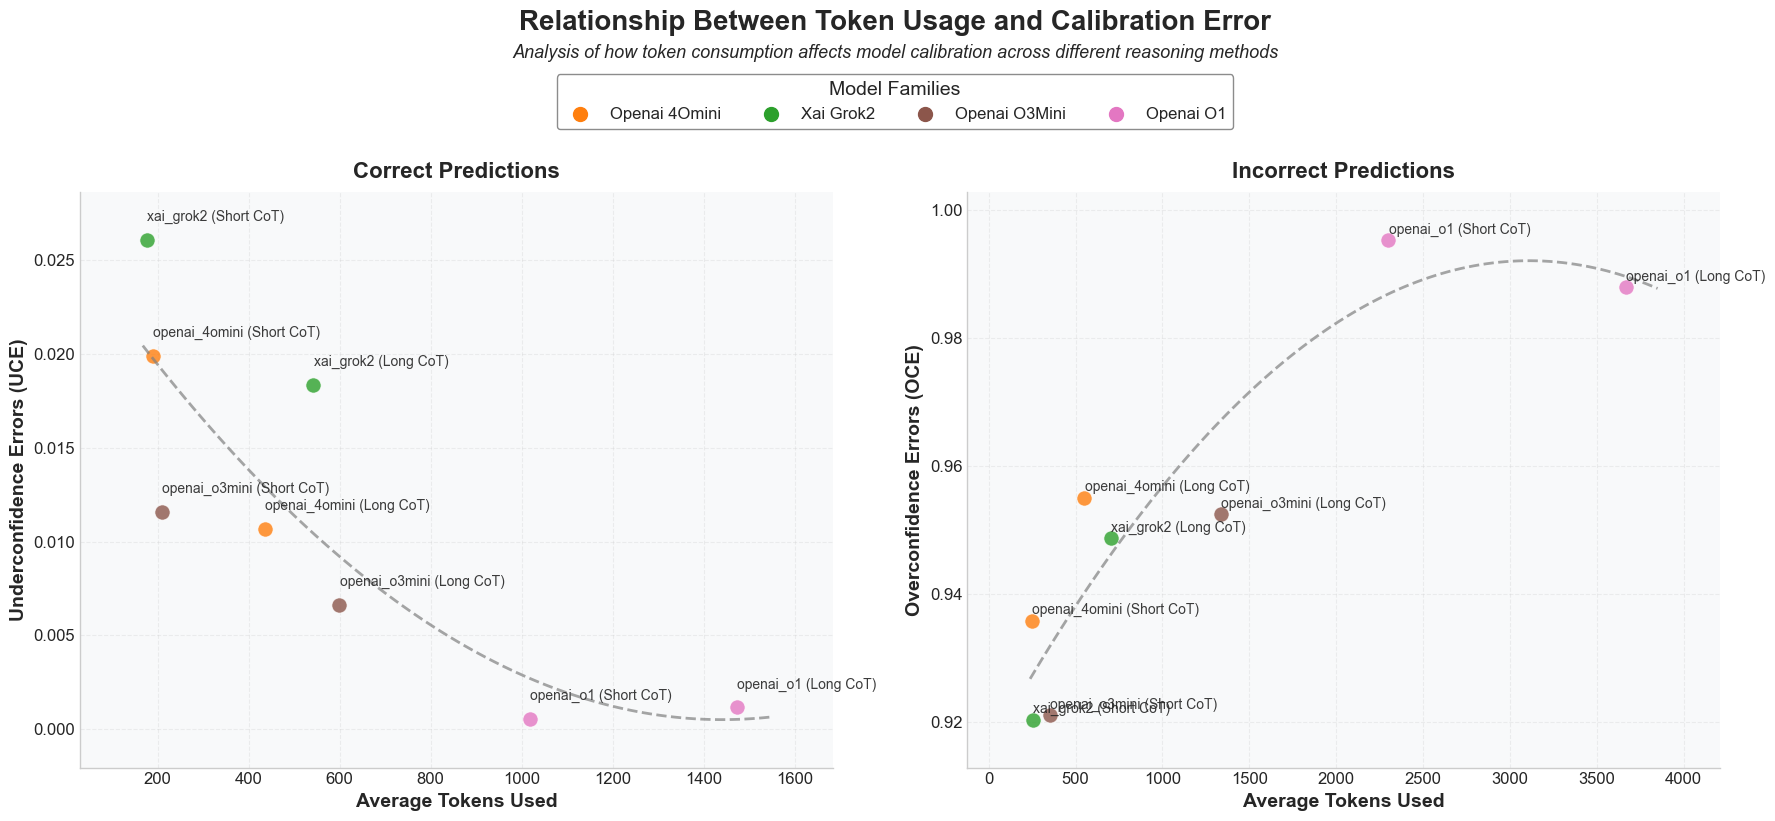

In [590]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def analyze_confidence_token_relationship(dfs, names):
    """
    Analyze how token usage relates to calibration errors separately for correct and incorrect predictions.
    For correct predictions, y-axis is Underconfidence Errors (UCE) and for incorrect predictions, it is Overconfidence Errors (OCE).
    Each model is displayed as a separate point instead of aggregating by base model.
    """
    # Create single figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # (Optional) Use a style that gives a clean background:
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Filter for models with reasoning
    reasoning_dfs = {k: v for k, v in dfs.items() 
                     if any(k.endswith(x) for x in ['_cot', '_low', '_reason', '_sc'])}
    
    # Filter model families: only keep those that have either _low, _reason or _sc
    model_families = {}
    for df_name in reasoning_dfs.keys():
        family_base = df_name
        for suffix in ['_low', '_reason', '_sc']:
            family_base = family_base.replace(suffix, '')
        
        if family_base not in model_families:
            model_families[family_base] = {'has_reason': False, 'has_sc': False, 'has_low': False}
        
        if '_reason' in df_name:
            model_families[family_base]['has_reason'] = True
        if '_sc' in df_name:
            model_families[family_base]['has_sc'] = True
        if '_low' in df_name:
            model_families[family_base]['has_low'] = True

    # Keep only families that have any of the required suffixes
    valid_families = [family for family, info in model_families.items() 
                      if info['has_reason'] or info['has_sc'] or info['has_low']]
    
    # Filter dataframes to only include valid families
    filtered_dfs = {}
    for df_name, df in reasoning_dfs.items():
        if any(family in df_name for family in valid_families):
            filtered_dfs[df_name] = df

    # Define colors for different model families
    family_colors = {
        'df_openai_4o_': '#1f77b4',      # Blue for GPT-4
        'df_openai_4omini': '#ff7f0e',   # Orange for GPT-4-mini
        'df_xai_grok2': '#2ca02c',       # Green for Grok-2
        'df_Meta_Llama': '#d62728',      # Red for Llama
        'df_claude': '#9467bd',          # Purple for Claude
        'df_openai_o3mini': '#8c564b',   # Brown for o3-mini
        'df_openai_o1': '#e377c2',       # Pink for GPT-o1
        'df_Qwen_QWQ': '#7f7f7f',        # Gray for Qwen-QWQ
    }
    
    # Adaptive ECE computation
    def compute_adaptive_ece(df, n_bins=10):
        df_clean = df.copy()
        confidences = df_clean['llm_confidence'].values
        correctness = df_clean['Correctness'].values
        sorted_indices = np.argsort(confidences)
        sorted_confidences = confidences[sorted_indices]
        sorted_correctness = correctness[sorted_indices]
        bin_boundaries = np.linspace(0, len(sorted_confidences), n_bins + 1).astype(int)
        ece = 0
        for i in range(n_bins):
            start_idx = bin_boundaries[i]
            end_idx = bin_boundaries[i + 1]
            if start_idx == end_idx:
                continue
            bin_confidences = sorted_confidences[start_idx:end_idx]
            bin_correctness = sorted_correctness[start_idx:end_idx]
            bin_conf = np.mean(bin_confidences)
            bin_acc = np.mean(bin_correctness)
            bin_size = len(bin_confidences)
            ece += (bin_size / len(confidences)) * abs(bin_conf - bin_acc)
        return ece

    # Process each model individually
    all_results = []
    
    for df_name, df in filtered_dfs.items():
        # Find the appropriate model family for color
        model_family = next((k for k in family_colors.keys() if k.lower() in df_name.lower()), 'Other')
        # Special case for o3-mini variants
        if 'o3mini' in df_name.lower():
            model_family = 'df_openai_o3mini'
        
        # Format display name with method suffix
        display_name = df_name.replace('df_', '')
        if '_cot' in display_name:
            display_name = display_name.replace('_cot', ' (Short CoT)')
        if '_low' in display_name:
            display_name = display_name.replace('_low', ' (Short CoT)')
        elif '_reason' in display_name:
            display_name = display_name.replace('_reason', ' (Long CoT)')
        elif '_sc' in display_name:
            display_name = display_name.replace('_sc', ' (Long CoT)')
            
        # Process dataframe
        df_clean = df.copy()
        df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
        
        # Split by correct/incorrect predictions
        df_correct = df_clean[df_clean['Correctness'] == 1]
        df_incorrect = df_clean[df_clean['Correctness'] == 0]
        
        # Compute metrics for correct predictions
        tokens_correct = df_correct['completion_tokens'].mean() if not df_correct.empty else np.nan
        ece_correct = compute_adaptive_ece(df_correct, n_bins=10) if not df_correct.empty else np.nan
        
        # Compute metrics for incorrect predictions
        tokens_incorrect = df_incorrect['completion_tokens'].mean() if not df_incorrect.empty else np.nan
        ece_incorrect = compute_adaptive_ece(df_incorrect, n_bins=10) if not df_incorrect.empty else np.nan
        
        # Store results
        all_results.append({
            'model': display_name,
            'avg_tokens_correct': tokens_correct,
            'ece_correct': ece_correct,
            'avg_tokens_incorrect': tokens_incorrect,
            'ece_incorrect': ece_incorrect,
            'color': family_colors.get(model_family, '#000000'),  # Default to black if family not found
            'marker': 'o',
            'family': model_family
        })
    
    # Plot data for correct (UCE) and incorrect (OCE) predictions
    for ax, metric in zip([ax1, ax2], ['correct', 'incorrect']):
        # Extract valid data points for this metric
        valid_results = [r for r in all_results 
                         if not np.isnan(r[f'avg_tokens_{metric}']) and not np.isnan(r[f'ece_{metric}'])]
        
        # Plot each individual point
        for result in valid_results:
            ax.scatter(
                result[f'avg_tokens_{metric}'], 
                result[f'ece_{metric}'],
                marker='o',
                c=result['color'], 
                s=120,
                alpha=0.8,
                edgecolors='white', 
                linewidths=0.6
            )
            
            # Label each point slightly offset from the marker (x+ / y+ or y-).
            # Adjust offsets as desired for best visualization.
            ax.text(
                result[f'avg_tokens_{metric}'] + 0.5, 
                result[f'ece_{metric}'] + 0.001,
                result['model'], 
                fontsize=10,
                fontweight='normal', 
                alpha=0.9, 
                ha='left'
            )
        
        # Add trend line if enough points
        if len(valid_results) >= 3:
            x_vals = [r[f'avg_tokens_{metric}'] for r in valid_results]
            y_vals = [r[f'ece_{metric}'] for r in valid_results]
            z = np.polyfit(x_vals, y_vals, 2)
            p = np.poly1d(z)
            x_smooth = np.linspace(min(x_vals)*0.95, max(x_vals)*1.05, 100)
            ax.plot(x_smooth, p(x_smooth), '--', color='gray', alpha=0.7, lw=2)
        
        # Customize axis labels and titles
        ax.set_xlabel('Average Tokens Used', fontsize=14, fontweight='bold')
        if metric == 'correct':
            ax.set_ylabel('Underconfidence Errors (UCE)', fontsize=14, fontweight='bold')
            ax.set_title('Correct Predictions', fontsize=16, fontweight='bold', pad=10)
        else:
            ax.set_ylabel('Overconfidence Errors (OCE)', fontsize=14, fontweight='bold')
            ax.set_title('Incorrect Predictions', fontsize=16, fontweight='bold', pad=10)
            
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_facecolor('#f8f9fa')
        ax.margins(0.1)
    
    # Create legend for model families
    unique_families = {result['family']: result['color'] for result in all_results}
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color=color,
                   label=family.replace('df_','').replace('_', ' ').title(), 
                   markersize=10, linestyle='None')
        for family, color in unique_families.items()
    ]
    
    # Add legend (placing it at the top center, above the subplots)
    fig.legend(
        handles=legend_elements, 
        title='Model Families', 
        loc='upper center', 
        bbox_to_anchor=(0.5, 0.95),
        ncol=4, 
        fontsize=12, 
        title_fontsize=14, 
        frameon=True, 
        framealpha=0.9, 
        edgecolor='gray'
    )
    
    # Add suptitle
    fig.suptitle(
        'Relationship Between Token Usage and Calibration Error', 
        fontsize=20, fontweight='bold', y=1.02
    )
    
    plt.figtext(
        0.5, 0.96, 
        'Analysis of how token consumption affects model calibration across different reasoning methods', 
        ha='center', 
        fontsize=13, 
        fontstyle='italic'
    )
    
    # Adjust layout to account for the bigger legend and titles
    plt.tight_layout(rect=[0, 0.0, 1, 0.9])
    
    # Save figure
    fig.savefig('../token_calibration_analysis.pdf', 
                bbox_inches='tight', dpi=300, 
                facecolor='white', edgecolor='none')
    
    return fig

# Example usage
fig = analyze_confidence_token_relationship(dfs, list(dfs.keys()))
plt.show()


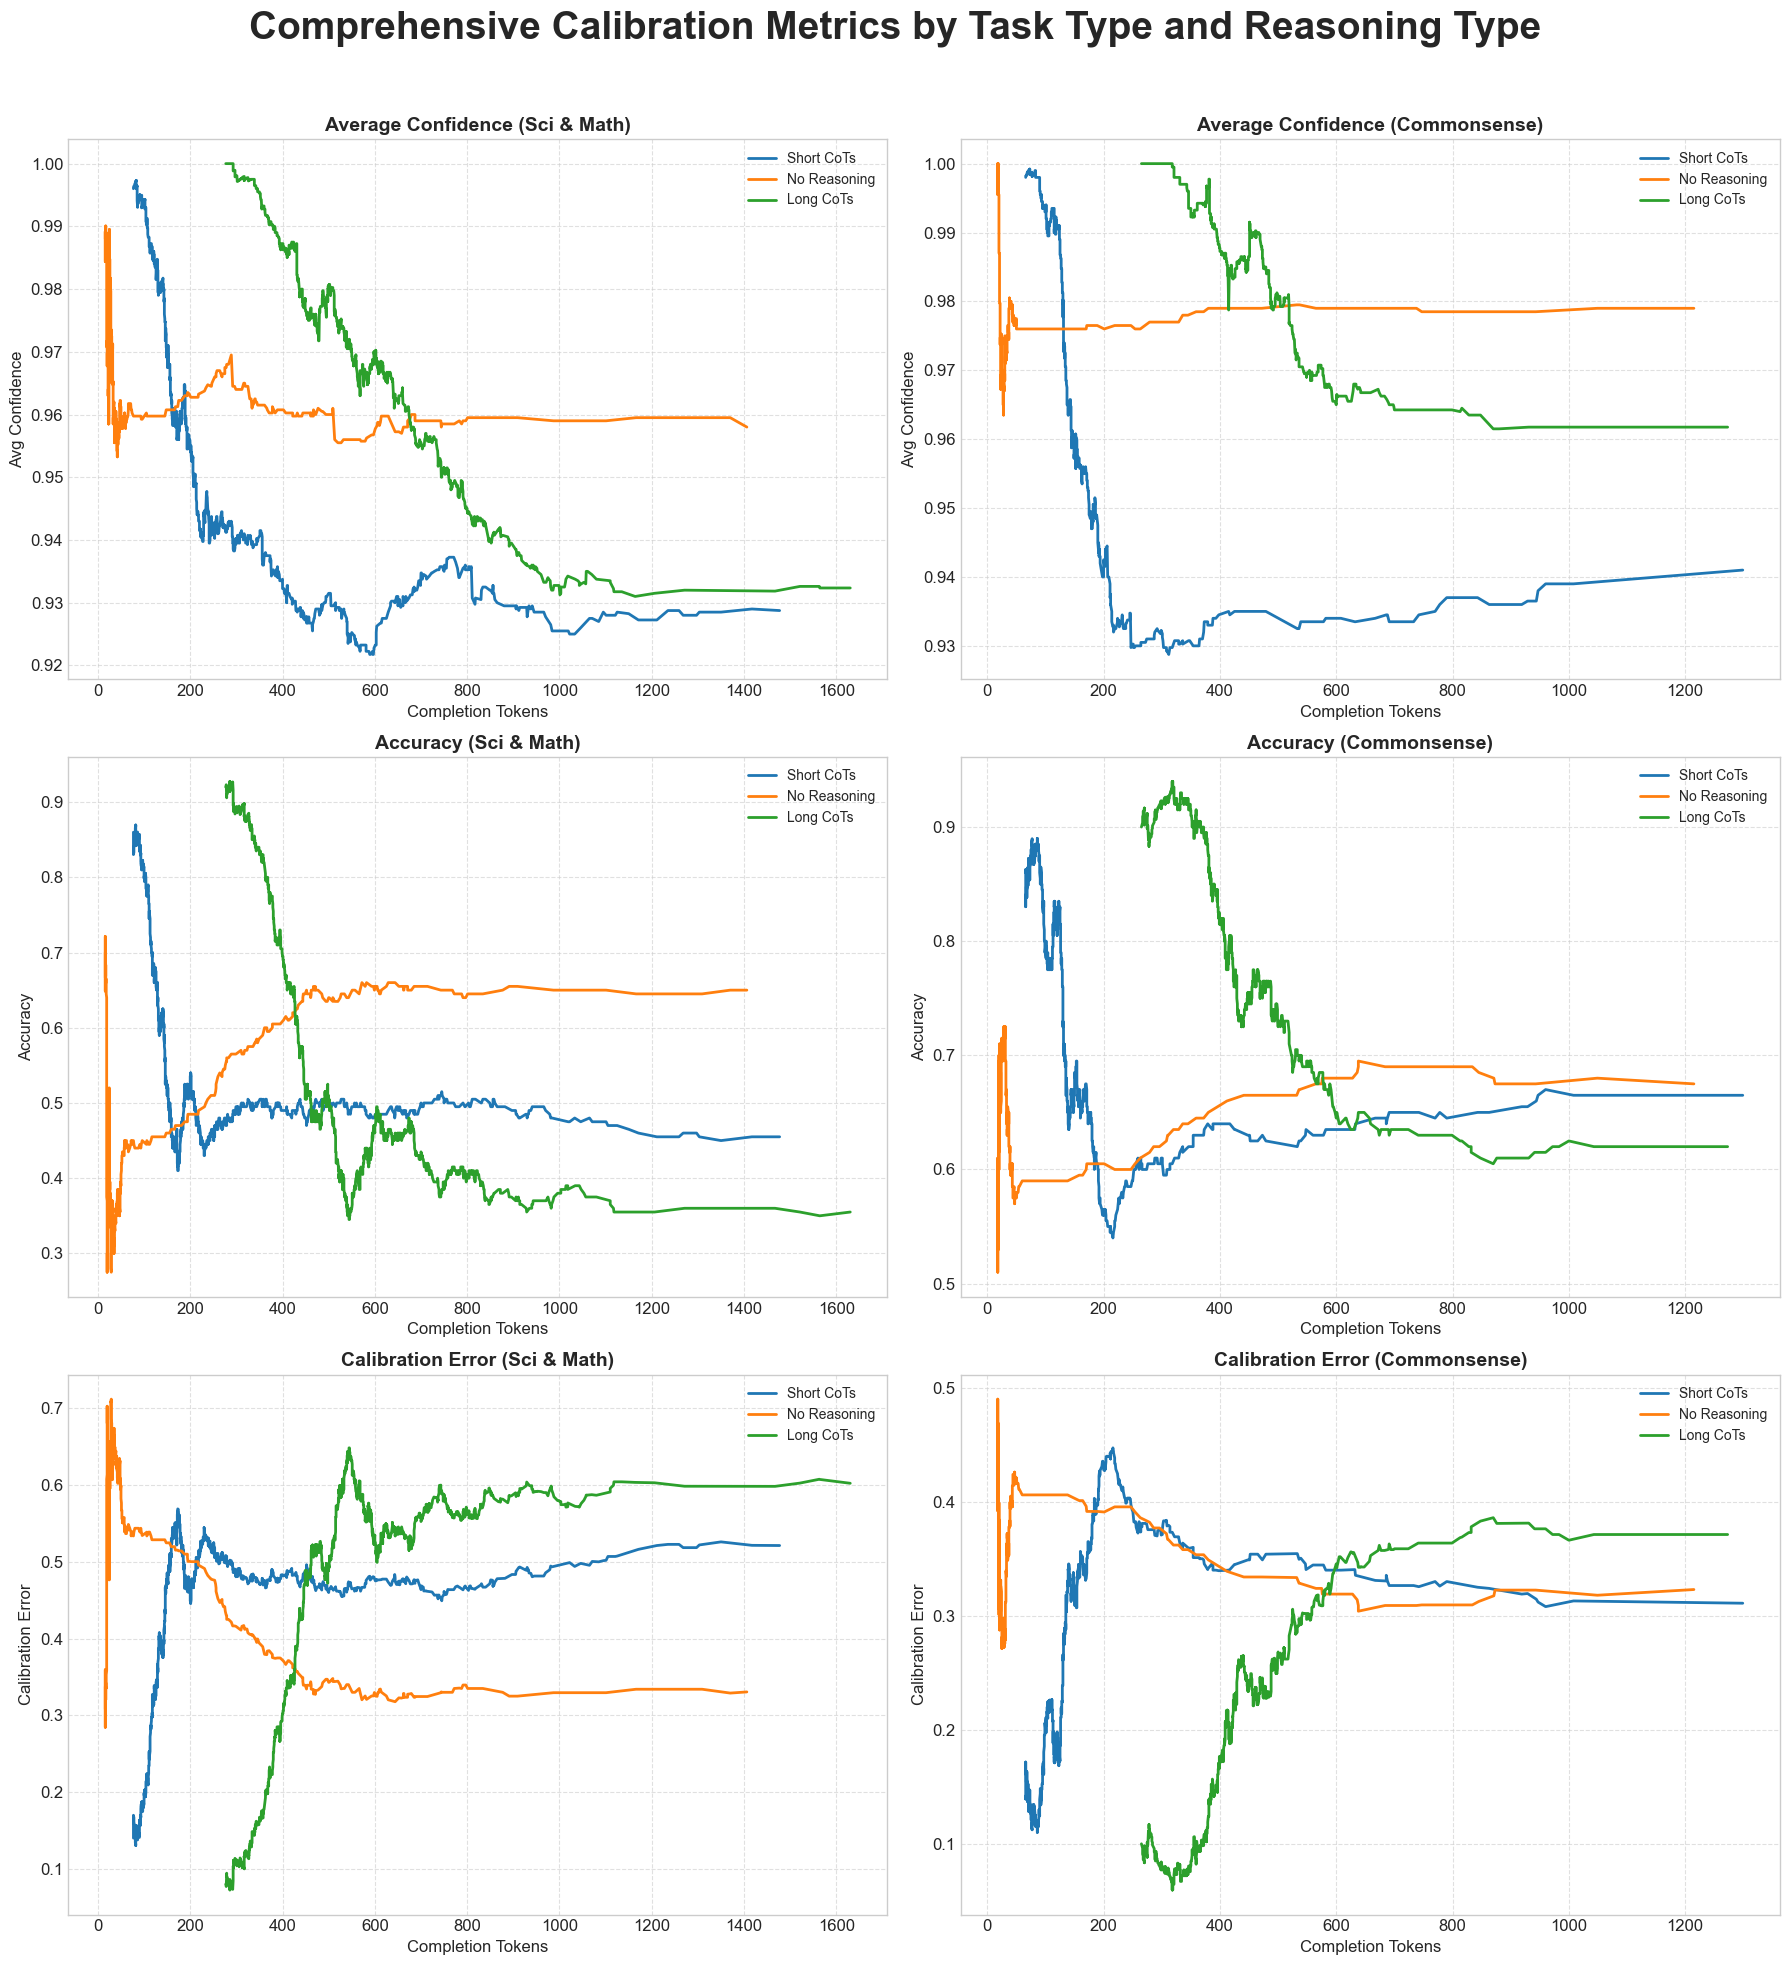

In [596]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create the Task_Type column
difficulty_map = {
    'BigBench_easy': 'Sci & Math',
    'BigBench_hard': 'Sci & Math', 
    'GPQA_main': 'Sci & Math',
    'MMLUPro_test': 'Sci & Math',
    'MMLU_test': 'Commonsense',
    'ProntoQA': 'Commonsense'
}

df_openai_4omini_cot['Reasoning_Type'] = 'Short CoT'
df_openai_4omini_no_exp['Reasoning_Type'] = 'No Reasoning'
df_openai_4omini_sc['Reasoning_Type'] = 'Long CoT'

openai_df = pd.concat([
    df_openai_4omini_cot, 
    df_openai_4omini_no_exp, 
    df_openai_4omini_sc
])

openai_df['Task_Type'] = openai_df['Name'].map(difficulty_map)

# (Optional) Remap Reasoning_Type to match older labels if desired:
openai_df['Reasoning_Type'] = openai_df['Reasoning_Type'].replace({
    'No Reasoning': 'No Reasoning',   # already fine
    'Short CoT': 'Short CoTs',
    'Long CoT': 'Long CoTs'
})

# Calculate calibration columns
openai_df['confidence_error'] = abs(openai_df['Correctness'] - openai_df['llm_confidence'])

openai_df.loc[openai_df['Correctness'] == 1, 'underconfidence_error'] = (
    1 - openai_df.loc[openai_df['Correctness'] == 1, 'llm_confidence']
)
openai_df.loc[openai_df['Correctness'] == 0, 'overconfidence_error'] = (
    openai_df.loc[openai_df['Correctness'] == 0, 'llm_confidence']
)

# Split by Task_Type
df_scimath = openai_df[openai_df['Task_Type'] == 'Sci & Math']
df_commonsense = openai_df[openai_df['Task_Type'] == 'Commonsense']

# Get unique Reasoning_Type
reasoning_types = openai_df['Reasoning_Type'].unique()

# Rolling window parameters
window_size = 200
min_periods = 50

# Helper function for rolling plot
def plot_metric_by_reasoning(ax, df_subset, metric_col, ylabel, title_suffix):
    for rtype in reasoning_types:
        df_r = df_subset[df_subset['Reasoning_Type'] == rtype]
        if df_r.empty:
            continue
        
        df_sorted = df_r.sort_values('completion_tokens')
        roll_metric = df_sorted[metric_col].rolling(
            window=window_size, 
            min_periods=min_periods
        ).mean()
        
        ax.plot(df_sorted['completion_tokens'], roll_metric, label=rtype, lw=2)
        
    ax.set_xlabel('Completion Tokens', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title_suffix, fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(labelsize=12)

# Create a 5x2 figure for Sci & Math (left) vs. Commonsense (right)
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
fig.suptitle('Comprehensive Calibration Metrics by Task Type and Reasoning Type',
             fontsize=28, fontweight='bold')

# --- Sci & Math (left column) ---
plot_metric_by_reasoning(
    axes[0, 0],
    df_scimath,
    'llm_confidence',
    'Avg Confidence',
    'Average Confidence (Sci & Math)'
)

plot_metric_by_reasoning(
    axes[1, 0],
    df_scimath,
    'Correctness',
    'Accuracy',
    'Accuracy (Sci & Math)'
)

plot_metric_by_reasoning(
    axes[2, 0],
    df_scimath,
    'confidence_error',
    'Calibration Error',
    'Calibration Error (Sci & Math)'
)

# df_scimath_corr = df_scimath[df_scimath['Correctness'] == 1]
# plot_metric_by_reasoning(
#     axes[3, 0],
#     df_scimath_corr,
#     'underconfidence_error',
#     'Underconfidence Error',
#     'Underconfidence Error (Sci & Math)'
# )

# df_scimath_incorr = df_scimath[df_scimath['Correctness'] == 0]
# plot_metric_by_reasoning(
#     axes[4, 0],
#     df_scimath_incorr,
#     'overconfidence_error',
#     'Overconfidence Error',
#     'Overconfidence Error (Sci & Math)'
# )

# --- Commonsense (right column) ---
plot_metric_by_reasoning(
    axes[0, 1],
    df_commonsense,
    'llm_confidence',
    'Avg Confidence',
    'Average Confidence (Commonsense)'
)

plot_metric_by_reasoning(
    axes[1, 1],
    df_commonsense,
    'Correctness',
    'Accuracy',
    'Accuracy (Commonsense)'
)

plot_metric_by_reasoning(
    axes[2, 1],
    df_commonsense,
    'confidence_error',
    'Calibration Error',
    'Calibration Error (Commonsense)'
)

# df_commonsense_corr = df_commonsense[df_commonsense['Correctness'] == 1]
# plot_metric_by_reasoning(
#     axes[3, 1],
#     df_commonsense_corr,
#     'underconfidence_error',
#     'Underconfidence Error',
#     'Underconfidence Error (Commonsense)'
# )

# df_commonsense_incorr = df_commonsense[df_commonsense['Correctness'] == 0]
# plot_metric_by_reasoning(
#     axes[4, 1],
#     df_commonsense_incorr,
#     'overconfidence_error',
#     'Overconfidence Error',
#     'Overconfidence Error (Commonsense)'

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../calibration_metrics_by_tasktype.pdf', dpi=300, bbox_inches='tight')
plt.show()


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_99051/1979156570.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_99051/1979156570.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)
/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_99051/1979156570.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45)


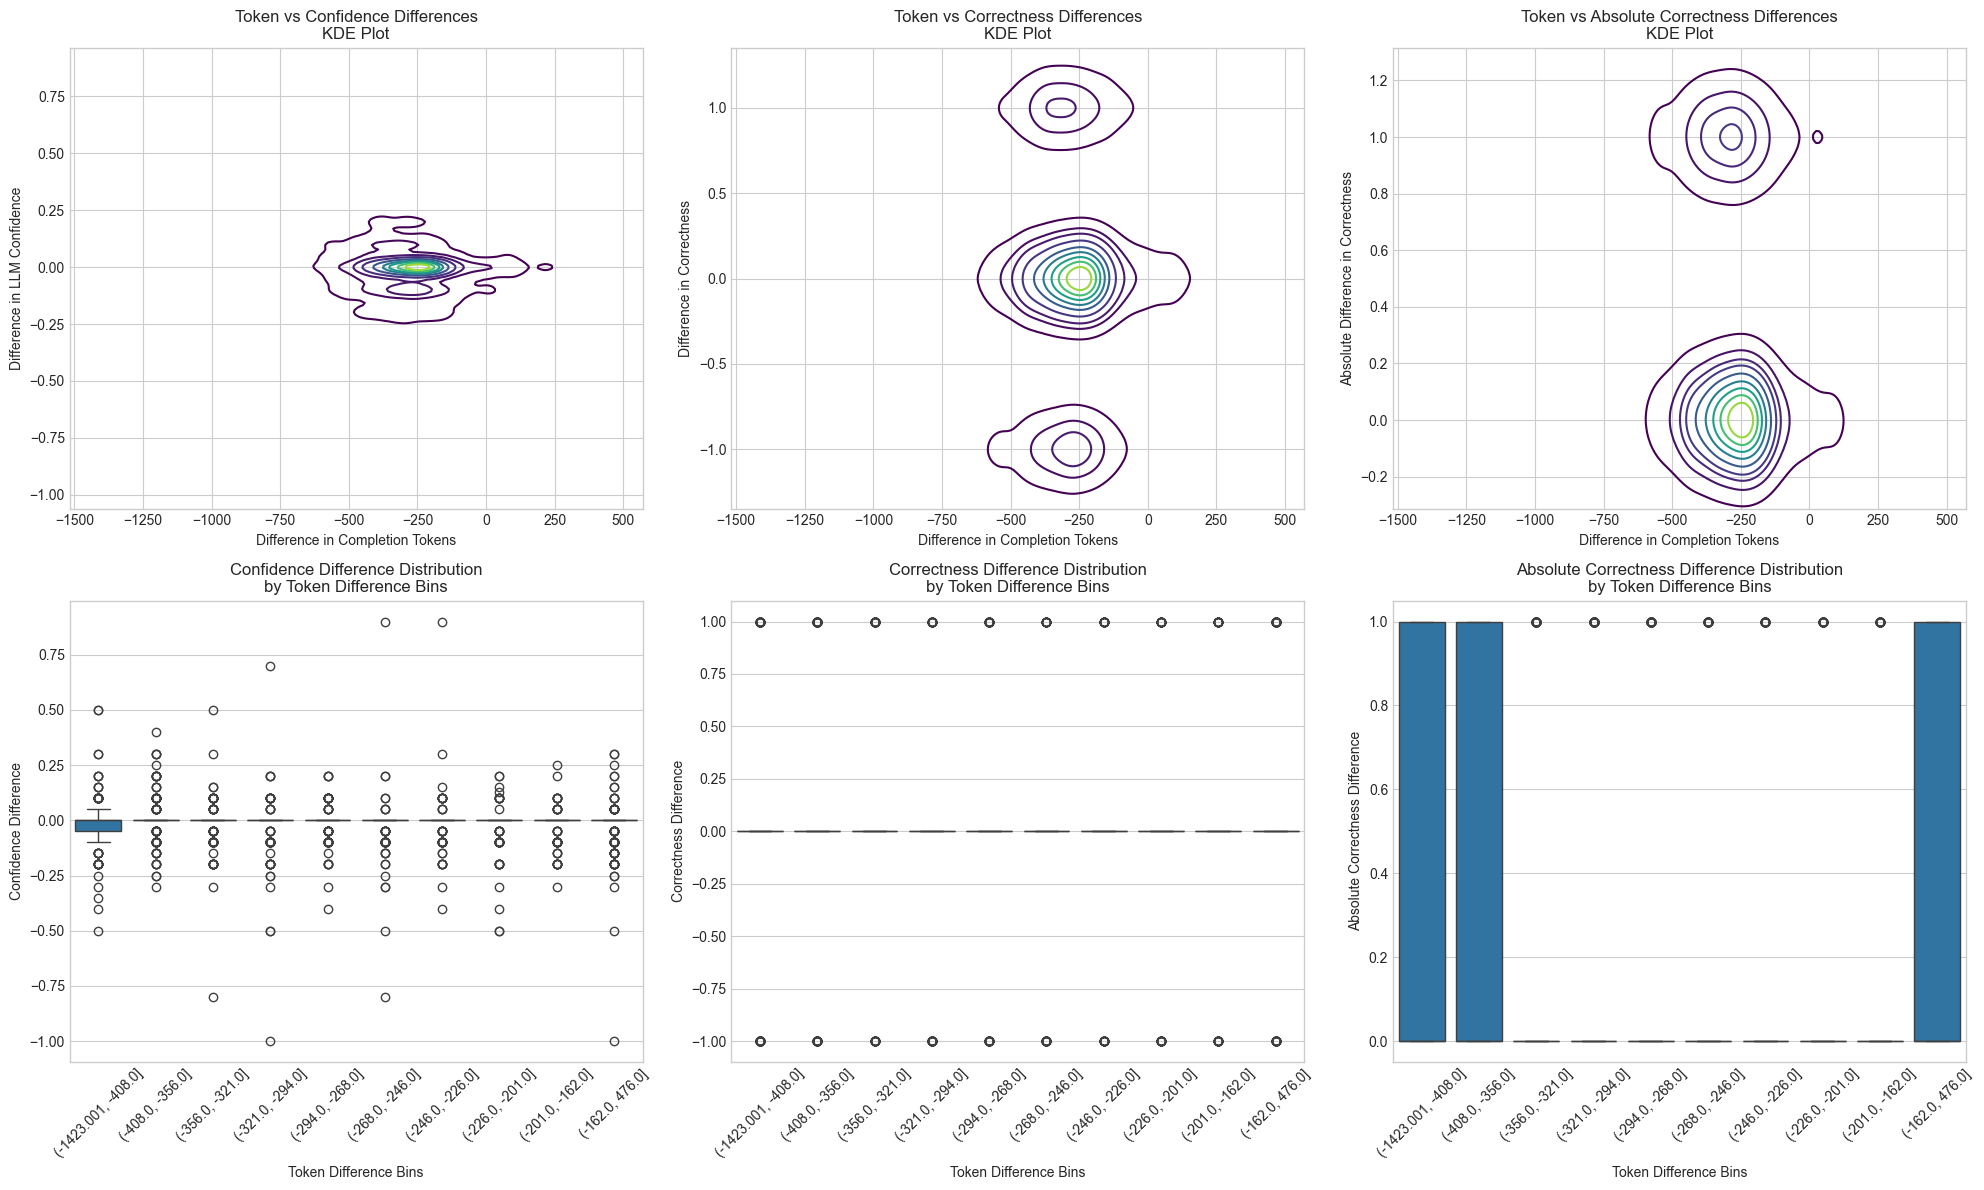


Spearman Correlation Coefficients:
Token vs Confidence: nan
Token vs Correctness: nan
Token vs Abs Correctness: nan


In [75]:
# Calculate differences between the two dataframes
token_diff = df_openai_4omini_cot['completion_tokens'] - df_openai_4omini_sc['completion_tokens']
confidence_diff = df_openai_4omini_cot['llm_confidence'] - df_openai_4omini_sc['llm_confidence'] 
correctness_diff = df_openai_4omini_cot['Correctness'] - df_openai_4omini_sc['Correctness']
abs_diff = abs(df_openai_4omini_cot['Correctness'] - df_openai_4omini_sc['Correctness'])

# Create figure with multiple visualization methods
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: Kernel Density Estimation (KDE) plots
sns.kdeplot(data=pd.DataFrame({'token_diff': token_diff, 'confidence_diff': confidence_diff}),
            x='token_diff', y='confidence_diff', ax=ax1, cmap='viridis')
ax1.set_xlabel('Difference in Completion Tokens')
ax1.set_ylabel('Difference in LLM Confidence')
ax1.set_title('Token vs Confidence Differences\nKDE Plot')

sns.kdeplot(data=pd.DataFrame({'token_diff': token_diff, 'correctness_diff': correctness_diff}),
            x='token_diff', y='correctness_diff', ax=ax2, cmap='viridis')
ax2.set_xlabel('Difference in Completion Tokens')
ax2.set_ylabel('Difference in Correctness')
ax2.set_title('Token vs Correctness Differences\nKDE Plot')

sns.kdeplot(data=pd.DataFrame({'token_diff': token_diff, 'abs_diff': abs_diff}),
            x='token_diff', y='abs_diff', ax=ax3, cmap='viridis')
ax3.set_xlabel('Difference in Completion Tokens')
ax3.set_ylabel('Absolute Difference in Correctness')
ax3.set_title('Token vs Absolute Correctness Differences\nKDE Plot')

# Row 2: Binned box plots
token_bins = pd.qcut(token_diff, q=10)

sns.boxplot(x=token_bins, y=confidence_diff, ax=ax4)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
ax4.set_xlabel('Token Difference Bins')
ax4.set_ylabel('Confidence Difference')
ax4.set_title('Confidence Difference Distribution\nby Token Difference Bins')

sns.boxplot(x=token_bins, y=correctness_diff, ax=ax5)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)
ax5.set_xlabel('Token Difference Bins')
ax5.set_ylabel('Correctness Difference')
ax5.set_title('Correctness Difference Distribution\nby Token Difference Bins')

sns.boxplot(x=token_bins, y=abs_diff, ax=ax6)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45)
ax6.set_xlabel('Token Difference Bins')
ax6.set_ylabel('Absolute Correctness Difference')
ax6.set_title('Absolute Correctness Difference Distribution\nby Token Difference Bins')

plt.tight_layout()
plt.show()

# Calculate and print correlation coefficients
correlations = {
    'Token vs Confidence': np.corrcoef(token_diff, confidence_diff)[0,1],
    'Token vs Correctness': np.corrcoef(token_diff, correctness_diff)[0,1],
    'Token vs Abs Correctness': np.corrcoef(token_diff, abs_diff)[0,1]
}

print("\nSpearman Correlation Coefficients:")
for key, value in correlations.items():
    print(f"{key}: {value:.3f}")

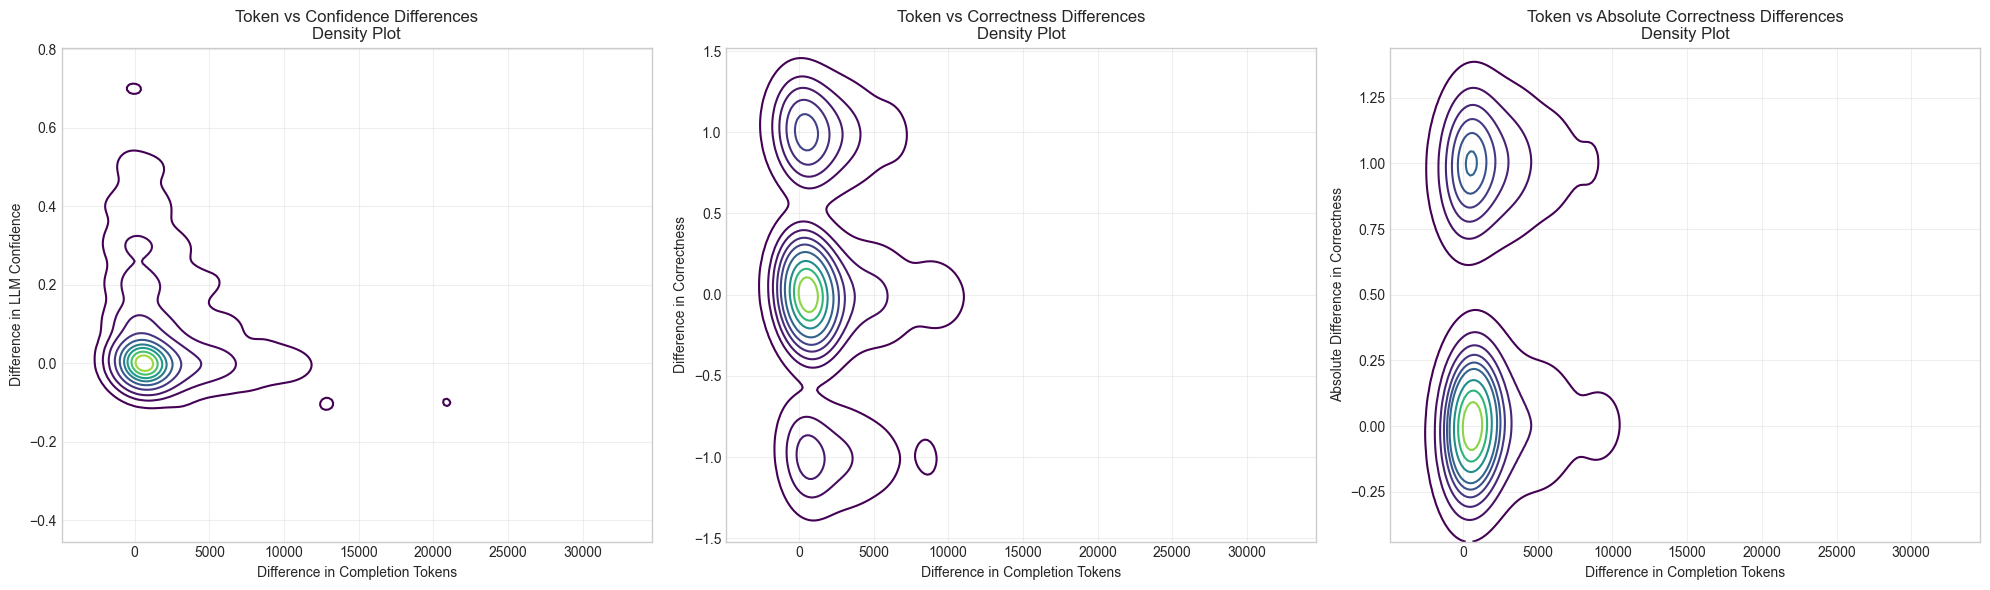

In [76]:
# Calculate differences between the two dataframes
token_diff = df_openai_o3mini_high_reason['completion_tokens'] - df_openai_o3mini_low_reason['completion_tokens']
confidence_diff = df_openai_o3mini_high_reason['llm_confidence'] - df_openai_o3mini_low_reason['llm_confidence'] 
correctness_diff = df_openai_o3mini_high_reason['Correctness'] - df_openai_o3mini_low_reason['Correctness']
abs_diff = abs(df_openai_o3mini_high_reason['Correctness'] - df_openai_o3mini_low_reason['Correctness'])

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Token diff vs Confidence diff with density estimate
sns.kdeplot(data=pd.DataFrame({'token_diff': token_diff, 'confidence_diff': confidence_diff}), 
            x='token_diff', y='confidence_diff', ax=ax1, cmap='viridis')
ax1.set_xlabel('Difference in Completion Tokens')
ax1.set_ylabel('Difference in LLM Confidence')
ax1.set_title('Token vs Confidence Differences\nDensity Plot')
ax1.grid(True, alpha=0.3)

# Plot 2: Token diff vs Correctness diff with density estimate
sns.kdeplot(data=pd.DataFrame({'token_diff': token_diff, 'correctness_diff': correctness_diff}),
            x='token_diff', y='correctness_diff', ax=ax2, cmap='viridis')
ax2.set_xlabel('Difference in Completion Tokens')
ax2.set_ylabel('Difference in Correctness')
ax2.set_title('Token vs Correctness Differences\nDensity Plot')
ax2.grid(True, alpha=0.3)

# Plot 3: Token diff vs Absolute diff with density estimate
sns.kdeplot(data=pd.DataFrame({'token_diff': token_diff, 'abs_diff': abs_diff}),
            x='token_diff', y='abs_diff', ax=ax3, cmap='viridis')
ax3.set_xlabel('Difference in Completion Tokens')
ax3.set_ylabel('Absolute Difference in Correctness')
ax3.set_title('Token vs Absolute Correctness Differences\nDensity Plot')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

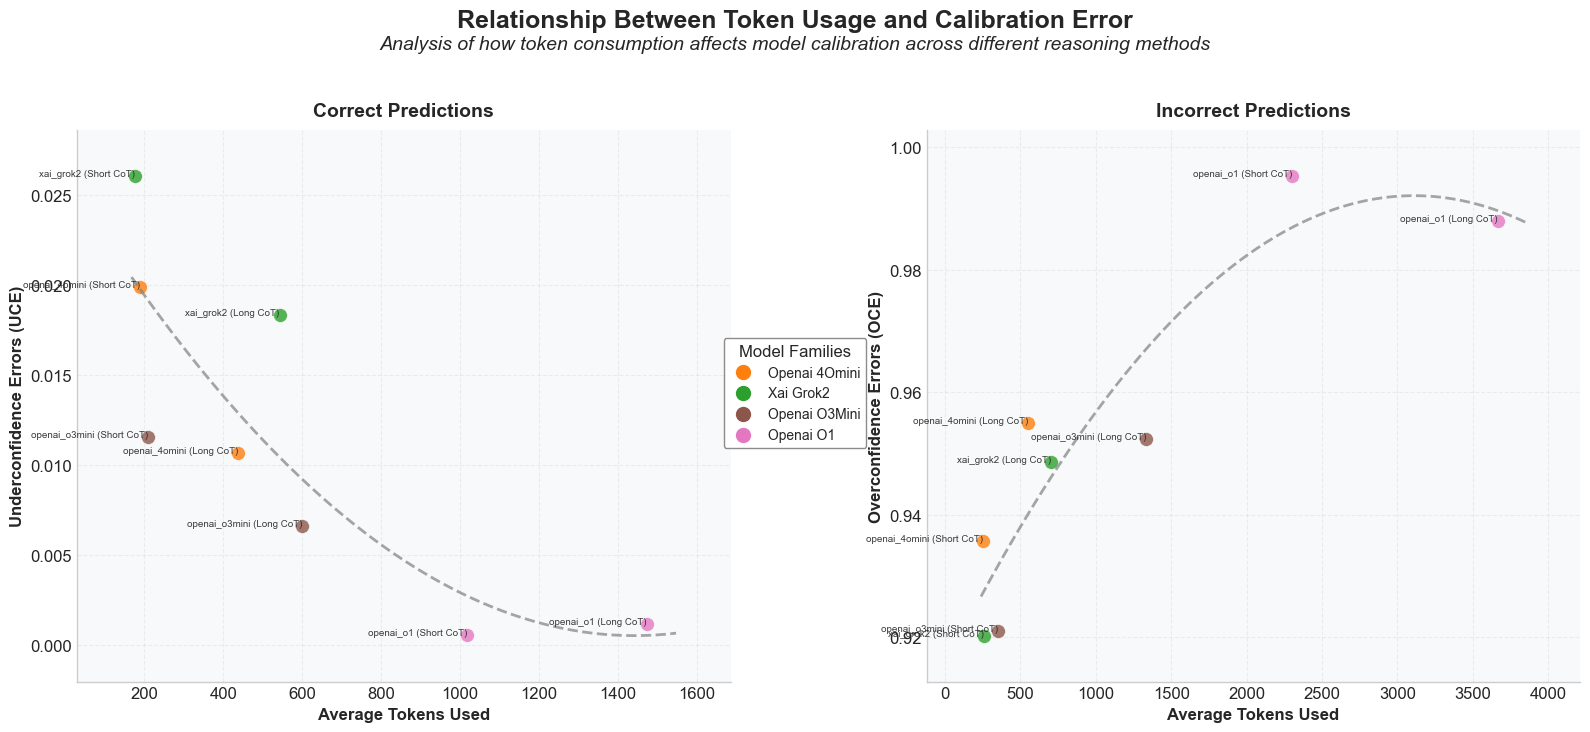

In [442]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def analyze_confidence_token_relationship(dfs, names):
    """
    Analyze how token usage relates to calibration errors separately for correct and incorrect predictions.
    For correct predictions, y-axis is Underconfidence Errors (UCE) and for incorrect predictions, it is Overconfidence Errors (OCE).
    Each model is displayed as a separate point instead of aggregating by base model.
    """
    # Create single figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Filter for models with reasoning
    reasoning_dfs = {k: v for k, v in dfs.items() if any(k.endswith(x) for x in ['_cot', '_low', '_reason', '_sc'])}
    
    # Filter model families: only keep those that have either _low, _reason or _sc
    model_families = {}
    for df_name in reasoning_dfs.keys():
        family_base = df_name
        for suffix in ['_low', '_reason', '_sc']:
            family_base = family_base.replace(suffix, '')
        
        if family_base not in model_families:
            model_families[family_base] = {'has_reason': False, 'has_sc': False, 'has_low': False}
        
        if '_reason' in df_name:
            model_families[family_base]['has_reason'] = True
        if '_sc' in df_name:
            model_families[family_base]['has_sc'] = True
        if '_low' in df_name:
            model_families[family_base]['has_low'] = True

    # Keep only families that have any of the required suffixes
    valid_families = [family for family, info in model_families.items() 
                     if info['has_reason'] or info['has_sc'] or info['has_low']]
    
    # Filter dataframes to only include valid families
    filtered_dfs = {}
    for df_name, df in reasoning_dfs.items():
        if any(family in df_name for family in valid_families):
            filtered_dfs[df_name] = df

    # Define colors for different model families
    family_colors = {
        'df_openai_4o_': '#1f77b4',      # Blue for GPT-4
        'df_openai_4omini': '#ff7f0e',   # Orange for GPT-4-mini
        'df_xai_grok2': '#2ca02c',       # Green for Grok-2
        'df_Meta_Llama': '#d62728',      # Red for Llama
        'df_claude': '#9467bd',          # Purple for Claude
        'df_openai_o3mini': '#8c564b',   # Brown for o3-mini
        'df_openai_o1': '#e377c2',       # Pink for GPT-o1
        'df_Qwen_QWQ': '#7f7f7f',        # Gray for Qwen-QWQ
    }
    
    # Adaptive ECE computation
    def compute_adaptive_ece(df, n_bins=10):
        df_clean = df.copy()
        confidences = df_clean['llm_confidence'].values
        correctness = df_clean['Correctness'].values
        sorted_indices = np.argsort(confidences)
        sorted_confidences = confidences[sorted_indices]
        sorted_correctness = correctness[sorted_indices]
        bin_boundaries = np.linspace(0, len(sorted_confidences), n_bins + 1).astype(int)
        ece = 0
        for i in range(n_bins):
            start_idx = bin_boundaries[i]
            end_idx = bin_boundaries[i + 1]
            if start_idx == end_idx:
                continue
            bin_confidences = sorted_confidences[start_idx:end_idx]
            bin_correctness = sorted_correctness[start_idx:end_idx]
            bin_conf = np.mean(bin_confidences)
            bin_acc = np.mean(bin_correctness)
            bin_size = len(bin_confidences)
            ece += (bin_size / len(confidences)) * abs(bin_conf - bin_acc)
        return ece

    # Process each model individually
    all_results = []
    
    for df_name, df in filtered_dfs.items():
        # Find the appropriate model family for color
        model_family = next((k for k in family_colors.keys() if k.lower() in df_name.lower()), 'Other')
        # Special case for o3-mini variants
        if 'o3mini' in df_name.lower():
            model_family = 'df_openai_o3mini'
        
        # Format display name with method suffix
        display_name = df_name.replace('df_', '')
        if '_cot' in display_name:
            display_name = display_name.replace('_cot', ' (Short CoT)')
        if '_low' in display_name:
            display_name = display_name.replace('_low', ' (Short CoT)')
        elif '_reason' in display_name:
            display_name = display_name.replace('_reason', ' (Long CoT)')
        elif '_sc' in display_name:
            display_name = display_name.replace('_sc', ' (Long CoT)')
            
        # Process dataframe
        df_clean = df.copy()
        df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
        
        # Split by correct/incorrect predictions
        df_correct = df_clean[df_clean['Correctness'] == 1]
        df_incorrect = df_clean[df_clean['Correctness'] == 0]
        
        # Compute metrics for correct predictions
        tokens_correct = df_correct['completion_tokens'].mean() if not df_correct.empty else np.nan
        ece_correct = compute_adaptive_ece(df_correct, n_bins=10) if not df_correct.empty else np.nan
        
        # Compute metrics for incorrect predictions
        tokens_incorrect = df_incorrect['completion_tokens'].mean() if not df_incorrect.empty else np.nan
        ece_incorrect = compute_adaptive_ece(df_incorrect, n_bins=10) if not df_incorrect.empty else np.nan
        
        # Store results
        all_results.append({
            'model': display_name,
            'avg_tokens_correct': tokens_correct,
            'ece_correct': ece_correct,
            'avg_tokens_incorrect': tokens_incorrect,
            'ece_incorrect': ece_incorrect,
            'color': family_colors.get(model_family, '#000000'),  # Default to black if family not found
            'marker': 'o',
            'family': model_family
        })
    
    # Plot data for correct (UCE) and incorrect (OCE) predictions
    for ax, metric in zip([ax1, ax2], ['correct', 'incorrect']):
        # Extract valid data points for this metric
        valid_results = [r for r in all_results 
                        if not np.isnan(r[f'avg_tokens_{metric}']) and not np.isnan(r[f'ece_{metric}'])]
        
        # Plot each individual point
        for result in valid_results:
            ax.scatter(
                result[f'avg_tokens_{metric}'], 
                result[f'ece_{metric}'],
                marker='o',
                c=result['color'], 
                s=100,
                alpha=0.8,
                edgecolors='white', 
                linewidths=0.5
            )
            
            # Label each point
            ax.text(
                result[f'avg_tokens_{metric}'], 
                result[f'ece_{metric}'],
                result['model'], 
                fontsize=7,
                fontweight='normal', 
                alpha=0.9, 
                ha='right'
            )
        
        # Add trend line if enough points
        if len(valid_results) >= 3:
            x_vals = [r[f'avg_tokens_{metric}'] for r in valid_results]
            y_vals = [r[f'ece_{metric}'] for r in valid_results]
            z = np.polyfit(x_vals, y_vals, 2)
            p = np.poly1d(z)
            x_smooth = np.linspace(min(x_vals)*0.95, max(x_vals)*1.05, 100)
            ax.plot(x_smooth, p(x_smooth), '--', color='gray', alpha=0.7, lw=2)
        
        # Customize axis labels and titles
        ax.set_xlabel('Average Tokens Used', fontsize=12, fontweight='bold')
        if metric == 'correct':
            ax.set_ylabel('Underconfidence Errors (UCE)', fontsize=12, fontweight='bold')
            ax.set_title('Correct Predictions', fontsize=14, fontweight='bold', pad=10)
        else:
            ax.set_ylabel('Overconfidence Errors (OCE)', fontsize=12, fontweight='bold')
            ax.set_title('Incorrect Predictions', fontsize=14, fontweight='bold', pad=10)
            
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_facecolor('#f8f9fa')
        ax.margins(0.1)
    
    # Create legend for model families
    unique_families = {result['family']: result['color'] for result in all_results}
    legend_elements = [plt.Line2D([0], [0], marker='o', color=color,
                                 label=family.replace('df_','').replace('_', ' ').title(), 
                                 markersize=10, linestyle='None')
                      for family, color in unique_families.items()]
    
    # Add legend
    fig.legend(handles=legend_elements, title='Model Families', 
               loc='center', bbox_to_anchor=(0.5, 0.5),
               ncol=1, fontsize=10, title_fontsize=12, 
               frameon=True, framealpha=0.9, edgecolor='gray')
    
    # Add titles
    fig.suptitle('Relationship Between Token Usage and Calibration Error', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.figtext(0.5, 0.93, 'Analysis of how token consumption affects model calibration across different reasoning methods', 
                ha='center', fontsize=14, fontstyle='italic')
    
    plt.tight_layout(rect=[0, 0.07, 1, 0.93])
    plt.subplots_adjust(wspace=0.3)
    
    fig.savefig('../token_calibration_analysis.pdf', bbox_inches='tight', dpi=300, 
                facecolor='white', edgecolor='none')
    
    return fig

# Run the analysis
fig = analyze_confidence_token_relationship(dfs, list(dfs.keys()))
plt.show()






{'Comparison': '4omini_sc vs 4omini_cot', 'Improved Count': 173, 'Total Unchanged (>0.5)': 2218}
{'Comparison': '4omini_cot vs 4omini_noexp', 'Improved Count': 413, 'Total Unchanged (>0.5)': 2346}
{'Comparison': 'grok2_sc vs grok2_cot', 'Improved Count': 70, 'Total Unchanged (>0.5)': 2033}
{'Comparison': 'grok2_cot vs grok2_noexp', 'Improved Count': 452, 'Total Unchanged (>0.5)': 2311}
{'Comparison': 'o1_reason vs o1_mini', 'Improved Count': 95, 'Total Unchanged (>0.5)': 2875}


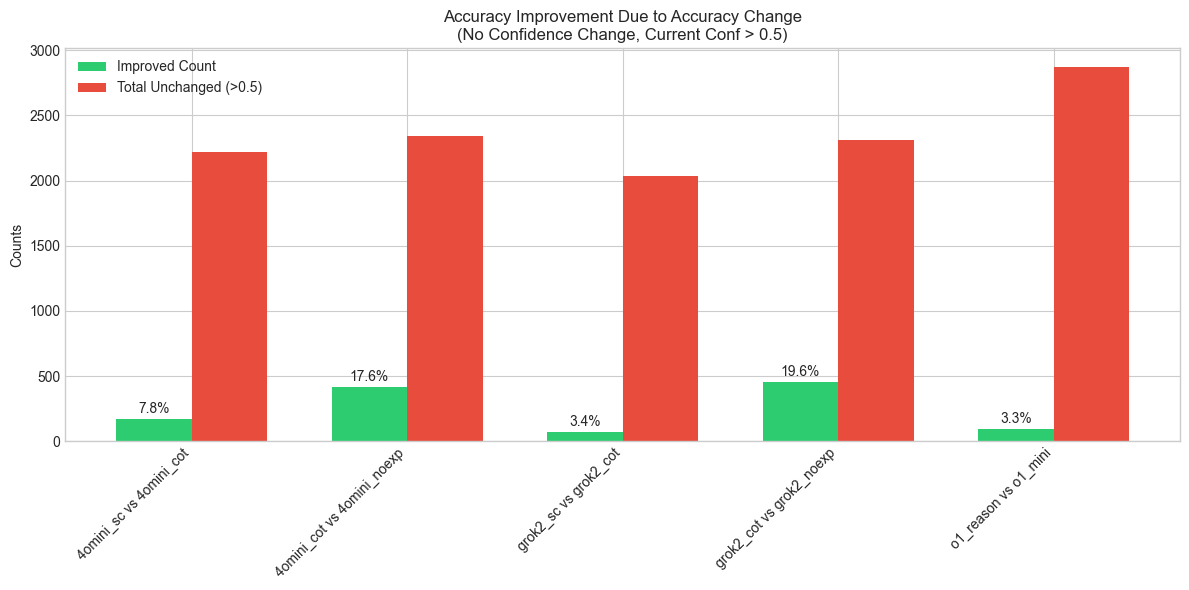

In [345]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_accuracy_improvement(dfs_and_names):
    """
    For each comparison, count the number of samples that improved in correctness
    (i.e. changed from incorrect to correct) where the confidence value remained unchanged 
    and the current confidence is > 0.5.
    
    Args:
        dfs_and_names: List of tuples containing:
            - (df_current, df_old)
            - (df_current, df_old, name_current)
            - (df_current, df_old, name_current, name_old)
            where df_current is the current DataFrame and df_old is the old DataFrame.
    
    Returns:
        A list of dictionaries, one per comparison, with keys:
          "Comparison", "Improved Count", "Total Unchanged (>0.5)"
    """
    results = []
    for item in dfs_and_names:
        # Unpack tuple based on its length.
        if len(item) == 4:
            df_current, df_old, name_current, name_old = item
        elif len(item) == 3:
            df_current, df_old, name_current = item
            name_old = "Old Approach"
        elif len(item) == 2:
            df_current, df_old = item
            name_current, name_old = "Current", "Old"
        else:
            raise ValueError("Each tuple must have 2, 3, or 4 elements.")
        
        # Restrict to common indices.
        aligned_indices = df_current.index.intersection(df_old.index)
        df_current_common = df_current.loc[aligned_indices]
        df_old_common = df_old.loc[aligned_indices]
        
        # Mask for unchanged confidence.
        same_conf_mask = (df_current_common['llm_confidence'] == df_old_common['llm_confidence'])
        # Focus only on samples with current confidence > 0.5.
        conf_mask = (df_current_common['llm_confidence'] > 0.5)
        # Focus on samples whose correctness improved: from incorrect (0) to correct (1).
        improvement_mask = (df_old_common['Correctness'] == 0) & (df_current_common['Correctness'] == 1)
        
        combined_mask = same_conf_mask & conf_mask & improvement_mask
        
        improved_count = int(combined_mask.sum())
        total_unchanged = int((same_conf_mask & conf_mask).sum())
        
        results.append({
            "Comparison": f"{name_current} vs {name_old}",
            "Improved Count": improved_count,
            "Total Unchanged (>0.5)": total_unchanged
        })
    
    return results

def plot_accuracy_improvement(results):
    """
    Plot a bar chart showing, for each comparison, the number of samples that improved (accuracy change only)
    versus the total number of samples with unchanged confidence (and current confidence > 0.5). 
    Also display the percentage improvement on top of each bar.
    """
    comparisons = [res["Comparison"] for res in results]
    improved_counts = [res["Improved Count"] for res in results]
    total_counts = [res["Total Unchanged (>0.5)"] for res in results]
    # Calculate ratio; if total is zero, set ratio to zero.
    ratios = [imp/total if total > 0 else 0 for imp, total in zip(improved_counts, total_counts)]
    
    x = np.arange(len(comparisons))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, improved_counts, width, label='Improved Count', color='#2ecc71')
    bars2 = ax.bar(x + width/2, total_counts, width, label='Total Unchanged (>0.5)', color='#e74c3c')
    
    ax.set_ylabel('Counts')
    ax.set_title('Accuracy Improvement Due to Accuracy Change\n(No Confidence Change, Current Conf > 0.5)')
    ax.set_xticks(x)
    ax.set_xticklabels(comparisons, rotation=45, ha='right')
    ax.legend()
    
    for i, (imp, tot, ratio) in enumerate(zip(improved_counts, total_counts, ratios)):
        ax.text(x[i] - width/2, imp + 0.05*max(improved_counts) if improved_counts else 0, f"{ratio*100:.1f}%", 
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Ensure your DataFrames (e.g., df_openai_4omini_sc, etc.) are defined.
comparisons = [
    (df_openai_4omini_sc, df_openai_4omini_cot, "4omini_sc", "4omini_cot"),
    (df_openai_4omini_cot, df_openai_4omini_noexp, "4omini_cot", "4omini_noexp"),
    (df_xai_grok2_sc, df_xai_grok2_cot, "grok2_sc", "grok2_cot"),
    (df_xai_grok2_cot, df_xai_grok2_noexp, "grok2_cot", "grok2_noexp"),
    (df_openai_o1_reason, df_openai_o1_low, "o1_reason", "o1_mini")
    # You can add more comparisons as needed.
]

results = analyze_accuracy_improvement(comparisons)
for res in results:
    print(res)

plot_accuracy_improvement(results)


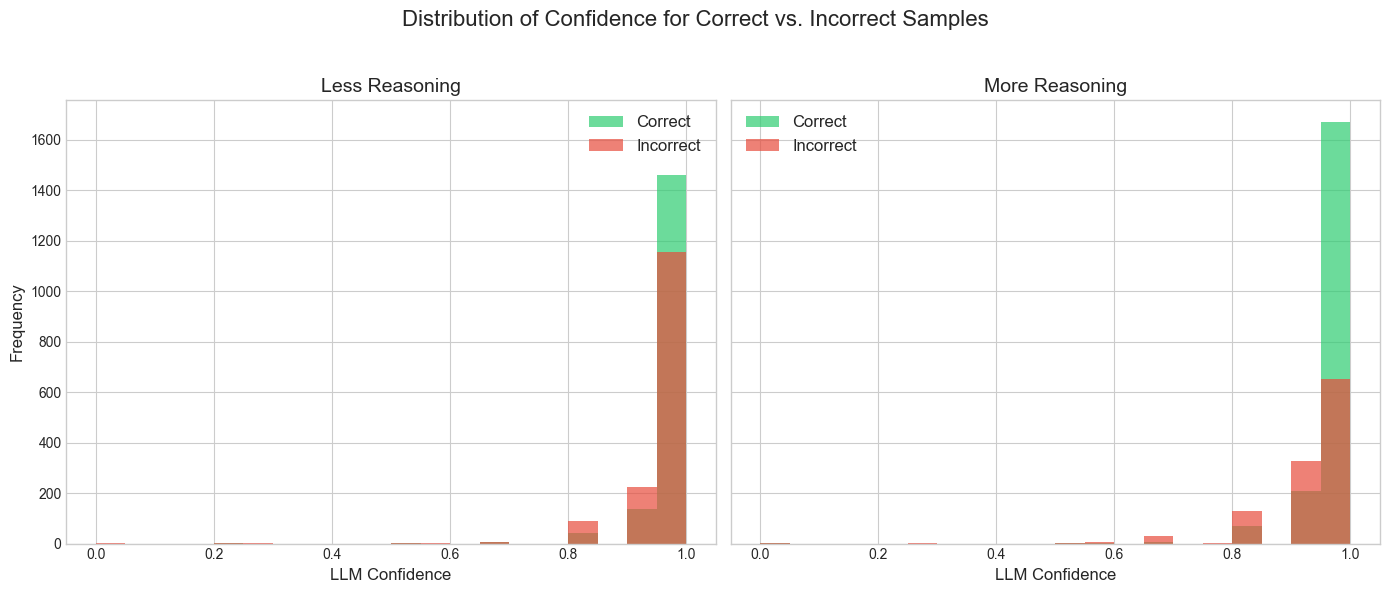

In [348]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confidence_distribution(df_less, df_more, label_less="Less Reasoning", label_more="More Reasoning"):
    """
    Plot the distribution of llm_confidence for correct and incorrect samples
    for two DataFrames representing less reasoning and more reasoning approaches.
    
    Args:
       df_less: DataFrame for less reasoning, must include columns 'llm_confidence' and 'Correctness'
       df_more: DataFrame for more reasoning, must include columns 'llm_confidence' and 'Correctness'
       label_less: Title label for the less reasoning panel.
       label_more: Title label for the more reasoning panel.
    """
    # Separate the confidence values for correct and incorrect samples for each DataFrame.
    less_correct = df_less[df_less['Correctness'] == 1]['llm_confidence']
    less_incorrect = df_less[df_less['Correctness'] == 0]['llm_confidence']
    
    more_correct = df_more[df_more['Correctness'] == 1]['llm_confidence']
    more_incorrect = df_more[df_more['Correctness'] == 0]['llm_confidence']
    
    # Determine a common set of bins. Adjust the range if your confidences are not between 0 and 1.
    bins = np.linspace(min(df_less['llm_confidence'].min(), df_more['llm_confidence'].min()),
                       max(df_less['llm_confidence'].max(), df_more['llm_confidence'].max()),
                       21)
    
    # Create a figure with two subplots side by side.
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # Plot for less reasoning (left panel)
    axes[0].hist(less_correct, bins=bins, alpha=0.7, label='Correct', color='#2ecc71')
    axes[0].hist(less_incorrect, bins=bins, alpha=0.7, label='Incorrect', color='#e74c3c')
    axes[0].set_title(label_less, fontsize=14)
    axes[0].set_xlabel('LLM Confidence', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].legend(fontsize=12)
    
    # Plot for more reasoning (right panel)
    axes[1].hist(more_correct, bins=bins, alpha=0.7, label='Correct', color='#2ecc71')
    axes[1].hist(more_incorrect, bins=bins, alpha=0.7, label='Incorrect', color='#e74c3c')
    axes[1].set_title(label_more, fontsize=14)
    axes[1].set_xlabel('LLM Confidence', fontsize=12)
    axes[1].legend(fontsize=12)
    
    # Add a common title for the entire figure.
    fig.suptitle('Distribution of Confidence for Correct vs. Incorrect Samples', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

df_less_reasoning = df_openai_4omini_noexp  # less reasoning
df_more_reasoning = df_openai_4omini_cot      # more reasoning

plot_confidence_distribution(df_less_reasoning, df_more_reasoning, "Less Reasoning", "More Reasoning")


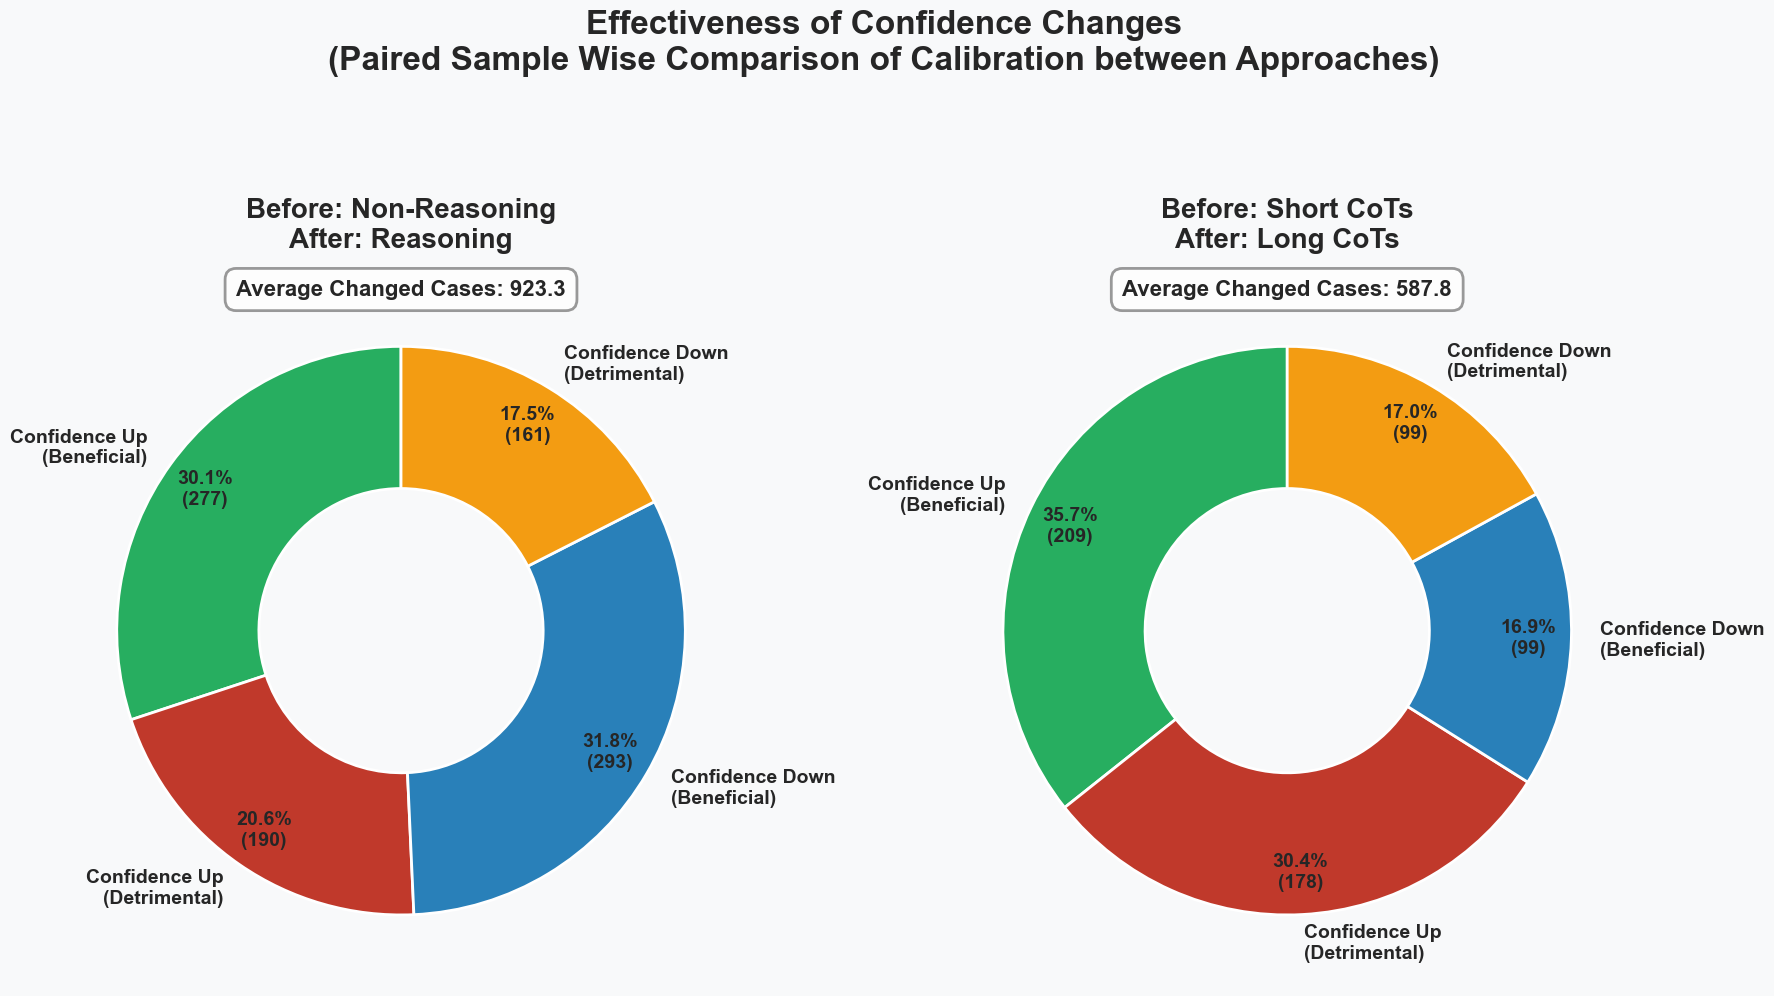

In [428]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def analyze_and_plot_grouped_calibration_changes(dfs_and_names):
    """
    For each comparison (where the first DataFrame is After and the second is Before),
    count the number of cases in each of 4 categories:
    
      1. Confidence Up (Beneficial): After confidence increased and After answer is correct.
      2. Confidence Up (Detrimental): After confidence increased and After answer is incorrect.
      3. Confidence Down (Beneficial): After confidence decreased and After answer is incorrect.
      4. Confidence Down (Detrimental): After confidence decreased and After answer is correct.
    
    Then, split the comparisons into two groups:
      - Group 1 ("Reasoning vs. Non-Reasoning"): Comparisons where one name indicates chain-of-thought ("cot")
         and the other indicates non–reasoning ("noexp" or "no_exp").
      - Group 2 ("Long CoTs vs. Short CoTs"): All other comparisons.
    
    For each group, the counts are averaged over the number of comparisons in that group,
    and a single pie chart is plotted to show the proportion of each category.
    
    Below each pie chart, only the average total number of changed cases is displayed.
    An overall title is added to describe the figure.
    """
    # Initialize accumulators for the two groups.
    group1_counts = np.array([0, 0, 0, 0], dtype=float)  # For Reasoning vs Non-Reasoning comparisons.
    group2_counts = np.array([0, 0, 0, 0], dtype=float)  # For other comparisons.
    group1_n = 0
    group2_n = 0
    
    for item in dfs_and_names:
        # Unpack tuple.
        if len(item) == 4:
            df_after, df_before, name_after, name_before = item
        elif len(item) == 3:
            df_after, df_before, name_after = item
            name_before = "Before Approach"
        elif len(item) == 2:
            df_after, df_before = item
            name_after, name_before = "After", "Before"
        else:
            raise ValueError("Each tuple must have 2, 3, or 4 elements.")
        
        # Determine grouping based on the names (lowercase).
        na = str(name_after).lower()
        nb = str(name_before).lower()
        # Group 1: if one name contains "cot" and the other contains "noexp" or "no_exp".
        is_group1 = (("cot" in na and ("noexp" in nb or "no_exp" in nb)) or 
                     ("cot" in nb and ("noexp" in na or "no_exp" in na)))
        
        # Restrict both DataFrames to common indices.
        aligned_indices = df_after.index.intersection(df_before.index)
        df_after_common = df_after.loc[aligned_indices]
        df_before_common = df_before.loc[aligned_indices]
        
        # Initialize counts for the 4 categories for this comparison.
        beneficial_up = 0      # Confidence increased and After answer is correct.
        detrimental_up = 0     # Confidence increased and After answer is incorrect.
        beneficial_down = 0    # Confidence decreased and After answer is incorrect.
        detrimental_down = 0   # Confidence decreased and After answer is correct.
        
        for idx in aligned_indices:
            conf_before = df_before_common['llm_confidence'].loc[idx]
            conf_after = df_after_common['llm_confidence'].loc[idx]
            after_corr = df_after_common['Correctness'].loc[idx]
            
            if conf_after > conf_before:
                if after_corr == 1:
                    beneficial_up += 1
                else:
                    detrimental_up += 1
            elif conf_after < conf_before:
                if after_corr == 0:
                    beneficial_down += 1
                else:
                    detrimental_down += 1
        
        counts = np.array([beneficial_up, detrimental_up, beneficial_down, detrimental_down], dtype=float)
        
        if is_group1:
            group1_counts += counts
            group1_n += 1
        else:
            group2_counts += counts
            group2_n += 1

    # Compute average counts per comparison for each group.
    avg_group1 = group1_counts / group1_n if group1_n > 0 else np.array([0, 0, 0, 0], dtype=float)
    avg_group2 = group2_counts / group2_n if group2_n > 0 else np.array([0, 0, 0, 0], dtype=float)
    
    # Compute total average changed cases.
    total_group1 = avg_group1.sum()
    total_group2 = avg_group2.sum()
    
    # Labels and colors with improved contrast
    labels = [
        "Confidence Up\n(Beneficial)",
        "Confidence Up\n(Detrimental)",
        "Confidence Down\n(Beneficial)",
        "Confidence Down\n(Detrimental)"
    ]
    colors = ['#27ae60', '#c0392b', '#2980b9', '#f39c12']  # Deeper, more vibrant colors
    
    # Create figure with increased size
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    # Group 1: Reasoning vs. Non-Reasoning
    if total_group1 == 0:
        sizes1 = [1, 1, 1, 1]
        autopct1 = None
    else:
        sizes1 = avg_group1
        autopct1 = lambda pct: f'{pct:.1f}%\n({int(pct*total_group1/100):.0f})'
    
    wedges1, texts1, autotexts1 = axes[0].pie(
        sizes1, labels=labels, colors=colors, autopct=autopct1,
        startangle=90, pctdistance=0.85,
        wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2),
        textprops={'fontsize': 14, 'fontweight': 'bold'}
    )
    axes[0].set_title("Before: Non-Reasoning\nAfter: Reasoning", fontsize=20, fontweight='bold', pad=20)
    
    # Add shadow effect to text box
    axes[0].text(0, 1.2, f"Average Changed Cases: {total_group1:.1f}", 
                 ha='center', va='center', fontsize=16, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', 
                          boxstyle='round,pad=0.5', linewidth=2))
    
    # Group 2: Long CoTs vs. Short CoTs
    if total_group2 == 0:
        sizes2 = [1, 1, 1, 1]
        autopct2 = None
    else:
        sizes2 = avg_group2
        autopct2 = lambda pct: f'{pct:.1f}%\n({int(pct*total_group2/100):.0f})'
    
    wedges2, texts2, autotexts2 = axes[1].pie(
        sizes2, labels=labels, colors=colors, autopct=autopct2,
        startangle=90, pctdistance=0.85,
        wedgeprops=dict(width=0.5, edgecolor='white', linewidth=2),
        textprops={'fontsize': 14, 'fontweight': 'bold'}
    )
    axes[1].set_title("Before: Short CoTs\nAfter: Long CoTs", fontsize=20, fontweight='bold', pad=20)
    
    axes[1].text(0, 1.2, f"Average Changed Cases: {total_group2:.1f}", 
                 ha='center', va='center', fontsize=16, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', 
                          boxstyle='round,pad=0.5', linewidth=2))
    
    # Overall figure title with improved styling
    fig.suptitle("Effectiveness of Confidence Changes\n(Paired Sample Wise Comparison of Calibration between Approaches)", 
                 fontsize=24, fontweight='bold', y=1.05)
    
    # Add a subtle background color
    fig.patch.set_facecolor('#f8f9fa')
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    plt.savefig('../calibration_changes_grouped.png', dpi=300, bbox_inches='tight', format='png', facecolor='white')
    
    plt.show()

# Example usage:
comparisons = [
    (df_openai_o3mini_medium_reason, df_openai_o3mini_low_reason, "o3mini_medium", "o3mini_low"),
    (df_openai_o1_reason, df_openai_o1_low, "o1_reason", "o1_mini"),
    (df_Meta_Llama_3_1_70B_Instruct_noexp, df_Meta_Llama_3_1_70B_Instruct_cot, "llama_noexp", "llama_cot"),
    (df_xai_grok2_cot, df_xai_grok2_noexp, "grok2_cot", "grok2_noexp"),
    (df_xai_grok2_sc, df_xai_grok2_cot, "grok2_sc", "grok2_cot"),
    (df_openai_4omini_cot, df_openai_4omini_noexp, "4omini_cot", "4omini_noexp"),
    (df_openai_4omini_sc, df_openai_4omini_cot, "4omini_sc", "4omini_cot")
]

analyze_and_plot_grouped_calibration_changes(comparisons)


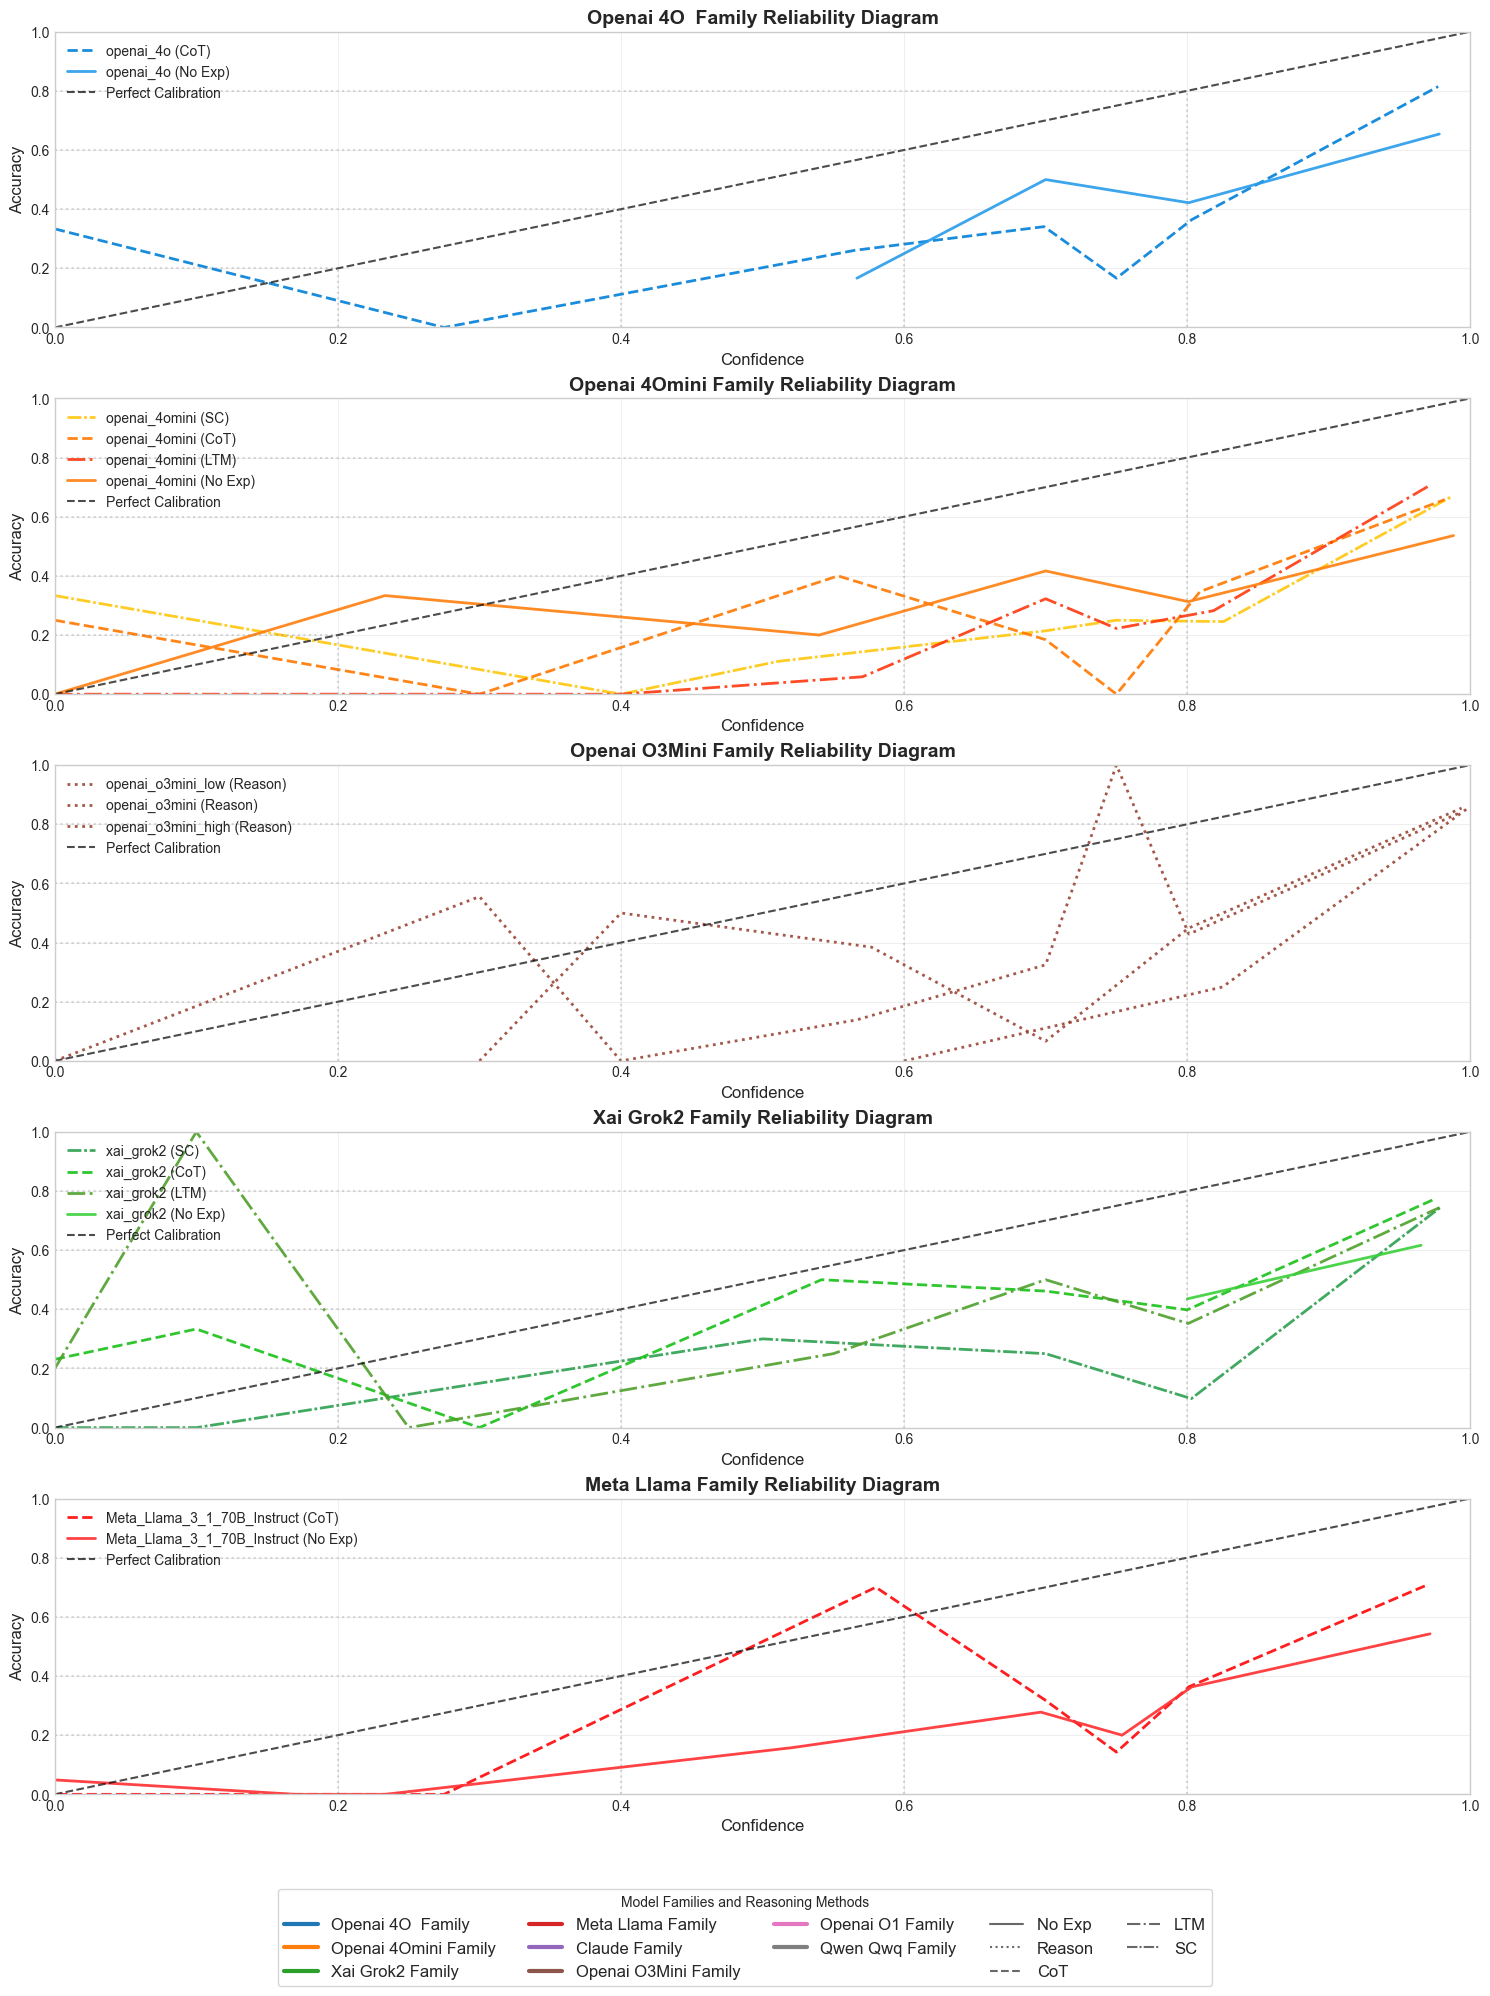

In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

def draw_reliability_diagrams(dfs):
    """
    Draw reliability diagrams for models grouped by family.
    Models of the same family are plotted on the same subplot.
    """
    # Filter for models with reasoning
    reasoning_dfs = {k: v for k, v in dfs.items() if any(k.endswith(x) for x in ['_no_exp', '_reason', '_cot', '_ltm', '_sc'])}
    
    # Define colors for different model families
    family_colors = {
        'df_openai_4o_': '#1f77b4',      # Blue for GPT-4
        'df_openai_4omini': '#ff7f0e',   # Orange for GPT-4-mini
        'df_xai_grok2': '#2ca02c',       # Green for Grok-2
        'df_Meta_Llama': '#d62728',      # Red for Llama
        'df_claude': '#9467bd',          # Purple for Claude
        'df_openai_o3mini': '#8c564b',   # Brown for o3-mini
        'df_openai_o1': '#e377c2',       # Pink for GPT-o1
        'df_Qwen_QWQ': '#7f7f7f',        # Gray for Qwen-QWQ
    }
    
    # Get model families and categorize dataframes by family
    family_dfs = {}
    for df_name, df in reasoning_dfs.items():
        # Find which family this model belongs to
        family = next((k for k in family_colors.keys() if k.lower() in df_name.lower()), 'Other')
        
        # Special case for o3-mini variants
        if 'o3mini' in df_name.lower():
            family = 'df_openai_o3mini'
            
        # Add to family group
        if family not in family_dfs:
            family_dfs[family] = {}
        
        # Format model name
        model_name = df_name.replace('df_', '')
        if '_no_exp' in model_name:
            model_name = model_name.replace('_no_exp', ' (No Exp)')
        elif '_reason' in model_name:
            model_name = model_name.replace('_reason', ' (Reason)')
        elif '_cot' in model_name:
            model_name = model_name.replace('_cot', ' (CoT)')
        elif '_ltm' in model_name:
            model_name = model_name.replace('_ltm', ' (LTM)')
        elif '_sc' in model_name:
            model_name = model_name.replace('_sc', ' (SC)')
            
        family_dfs[family][model_name] = df
    
    # Create a figure with subplots for each family
    num_families = len(family_dfs)
    fig = plt.figure(figsize=(15, 4 * num_families))
    gs = GridSpec(num_families, 1, figure=fig)
    
    # Function to compute calibration curve
    def compute_calibration_curve(df, n_bins=10):
        df_clean = df.copy()
        df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
        
        # Filter out any NaN values
        df_clean = df_clean.dropna(subset=['llm_confidence', 'Correctness'])
        
        # Create bins based on confidence
        bins = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(df_clean['llm_confidence'], bins) - 1
        bin_indices = np.clip(bin_indices, 0, n_bins - 1)  # Ensure all indices are valid
        
        # Calculate average confidence and accuracy for each bin
        bin_confidences = []
        bin_accuracies = []
        bin_sizes = []
        
        for i in range(n_bins):
            bin_mask = (bin_indices == i)
            if np.sum(bin_mask) > 0:
                bin_conf = df_clean.loc[bin_mask, 'llm_confidence'].mean()
                bin_acc = df_clean.loc[bin_mask, 'Correctness'].mean()
                bin_size = np.sum(bin_mask)
                
                bin_confidences.append(bin_conf)
                bin_accuracies.append(bin_acc)
                bin_sizes.append(bin_size)
            else:
                # Empty bin
                bin_confidences.append(np.nan)
                bin_accuracies.append(np.nan)
                bin_sizes.append(0)
        
        return bin_confidences, bin_accuracies, bin_sizes
    
    # Draw perfect calibration line style (same for all plots)
    perfect_calibration_style = {
        'color': 'black',
        'linestyle': '--',
        'linewidth': 1.5,
        'alpha': 0.7
    }
    
    # Plot each family in its own subplot
    for i, (family, models) in enumerate(family_dfs.items()):
        ax = fig.add_subplot(gs[i, 0])
        
        # Define a color map for different reasoning methods within the same family
        # We'll use different shades/variations of the family's base color
        family_base_color = family_colors[family]
        
        # Color variations for different reasoning methods within a family
        # Creating a set of related colors derived from the base family color
        import matplotlib.colors as mcolors
        
        # Convert the base color to HSV, which is more intuitive for color variations
        base_rgb = mcolors.to_rgb(family_base_color)
        base_hsv = mcolors.rgb_to_hsv(base_rgb)
        
        # Method-specific colors - vary saturation and value to create distinct but related colors
        method_colors = {
            'No Exp': mcolors.hsv_to_rgb([base_hsv[0], max(0.5, base_hsv[1]), min(1.0, base_hsv[2]*1.3)]),
            'Reason': mcolors.hsv_to_rgb([base_hsv[0], min(1.0, base_hsv[1]*1.4), max(0.6, base_hsv[2])]),
            'CoT': mcolors.hsv_to_rgb([base_hsv[0], min(1.0, base_hsv[1]*1.2), min(1.0, base_hsv[2]*1.2)]),
            'LTM': mcolors.hsv_to_rgb([max(0, base_hsv[0]-0.05), base_hsv[1], base_hsv[2]]),
            'SC': mcolors.hsv_to_rgb([min(1.0, base_hsv[0]+0.05), base_hsv[1], base_hsv[2]])
        }
        
        # Line styles for different methods (still useful for distinguishing when printed in black and white)
        line_styles = {
            'No Exp': '-',
            'Reason': ':',
            'CoT': '--',
            'LTM': '-.',
            'SC': (0, (5, 1, 1, 1))  # loosely dashdotdotted
        }
        
        # Plot each model in this family
        for model_name, df in models.items():
            # Determine method type and corresponding color/style
            method_type = 'No Exp'  # default
            if '(No Exp)' in model_name:
                method_type = 'No Exp'
            elif '(Reason)' in model_name:
                method_type = 'Reason'
            elif '(CoT)' in model_name:
                method_type = 'CoT'
            elif '(LTM)' in model_name:
                method_type = 'LTM'
            elif '(SC)' in model_name:
                method_type = 'SC'
            
            method_color = method_colors[method_type]
            line_style = line_styles[method_type]
            
            # Compute calibration curve
            bin_confidences, bin_accuracies, bin_sizes = compute_calibration_curve(df, n_bins=10)
            
            # Filter out NaN values before plotting
            valid_indices = ~np.isnan(bin_confidences) & ~np.isnan(bin_accuracies)
            if np.sum(valid_indices) > 1:  # Need at least 2 points to draw a line
                conf = np.array(bin_confidences)[valid_indices]
                acc = np.array(bin_accuracies)[valid_indices]
                
                # Plot the calibration curve with method-specific color
                ax.plot(conf, acc, 
                       linestyle=line_style,
                       color=method_color,
                       linewidth=2,
                       label=model_name,
                       alpha=0.9)
        
        # Plot perfect calibration line (y=x)
        ax.plot([0, 1], [0, 1], **perfect_calibration_style, label='Perfect Calibration')
        
        # Customize the plot
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_xlabel('Confidence', fontsize=12)
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.set_title(f'{family.replace("df_", "").replace("_", " ").title()} Family Reliability Diagram', 
                    fontsize=14, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.legend(loc='upper left', fontsize=10)
        
        # Add diagonal gridlines for better reference
        ax.plot([0.2, 0.2], [0, 0.2], color='gray', linestyle=':', alpha=0.3)
        ax.plot([0.4, 0.4], [0, 0.4], color='gray', linestyle=':', alpha=0.3)
        ax.plot([0.6, 0.6], [0, 0.6], color='gray', linestyle=':', alpha=0.3)
        ax.plot([0.8, 0.8], [0, 0.8], color='gray', linestyle=':', alpha=0.3)
        ax.plot([0, 0.2], [0.2, 0.2], color='gray', linestyle=':', alpha=0.3)
        ax.plot([0, 0.4], [0.4, 0.4], color='gray', linestyle=':', alpha=0.3)
        ax.plot([0, 0.6], [0.6, 0.6], color='gray', linestyle=':', alpha=0.3)
        ax.plot([0, 0.8], [0.8, 0.8], color='gray', linestyle=':', alpha=0.3)
    
    # Create a legend for the different reasoning methods
    fig.tight_layout()
    
    # Create a unified color legend for the different reasoning methods
    # We'll use a neutral color for each family to show the patterns
    method_legend_elements = []
    
    # Add entries for each family first
    for family, color in family_colors.items():
        family_name = family.replace("df_", "").replace("_", " ").title()
        method_legend_elements.append(
            plt.Line2D([0], [0], color=color, linestyle='-', linewidth=3, 
                     label=f"{family_name} Family")
        )
    
    # Add a separator in the legend
    method_legend_elements.append(
        plt.Line2D([0], [0], color='none', label=" ")
    )
    
    # Now add entries for each method with both color and line style
    # We'll use a neutral shade for demonstration
    method_legend_elements.extend([
        plt.Line2D([0], [0], color='dimgray', linestyle='-', label='No Exp'),
        plt.Line2D([0], [0], color='dimgray', linestyle=':', label='Reason'),
        plt.Line2D([0], [0], color='dimgray', linestyle='--', label='CoT'),
        plt.Line2D([0], [0], color='dimgray', linestyle='-.', label='LTM'),
        plt.Line2D([0], [0], color='dimgray', linestyle=(0, (5, 1, 1, 1)), label='SC'),
    ])
    
    # Add the method legend at the bottom with two rows
    # First row: family colors, Second row: method line styles
    fig.legend(handles=method_legend_elements, 
              loc='lower center', 
              ncol=min(5, len(family_colors) + 1), 
              bbox_to_anchor=(0.5, 0), 
              fontsize=12,
              frameon=True,
              title="Model Families and Reasoning Methods")
    
    # Add extra space at the bottom for the legend
    fig.subplots_adjust(bottom=0.1)
    
    # Save the figure
    fig.savefig("../reliability_diagrams_by_family.pdf", bbox_inches='tight', dpi=300)
    
    return fig

# Example usage:
fig = draw_reliability_diagrams(dfs)
plt.show()

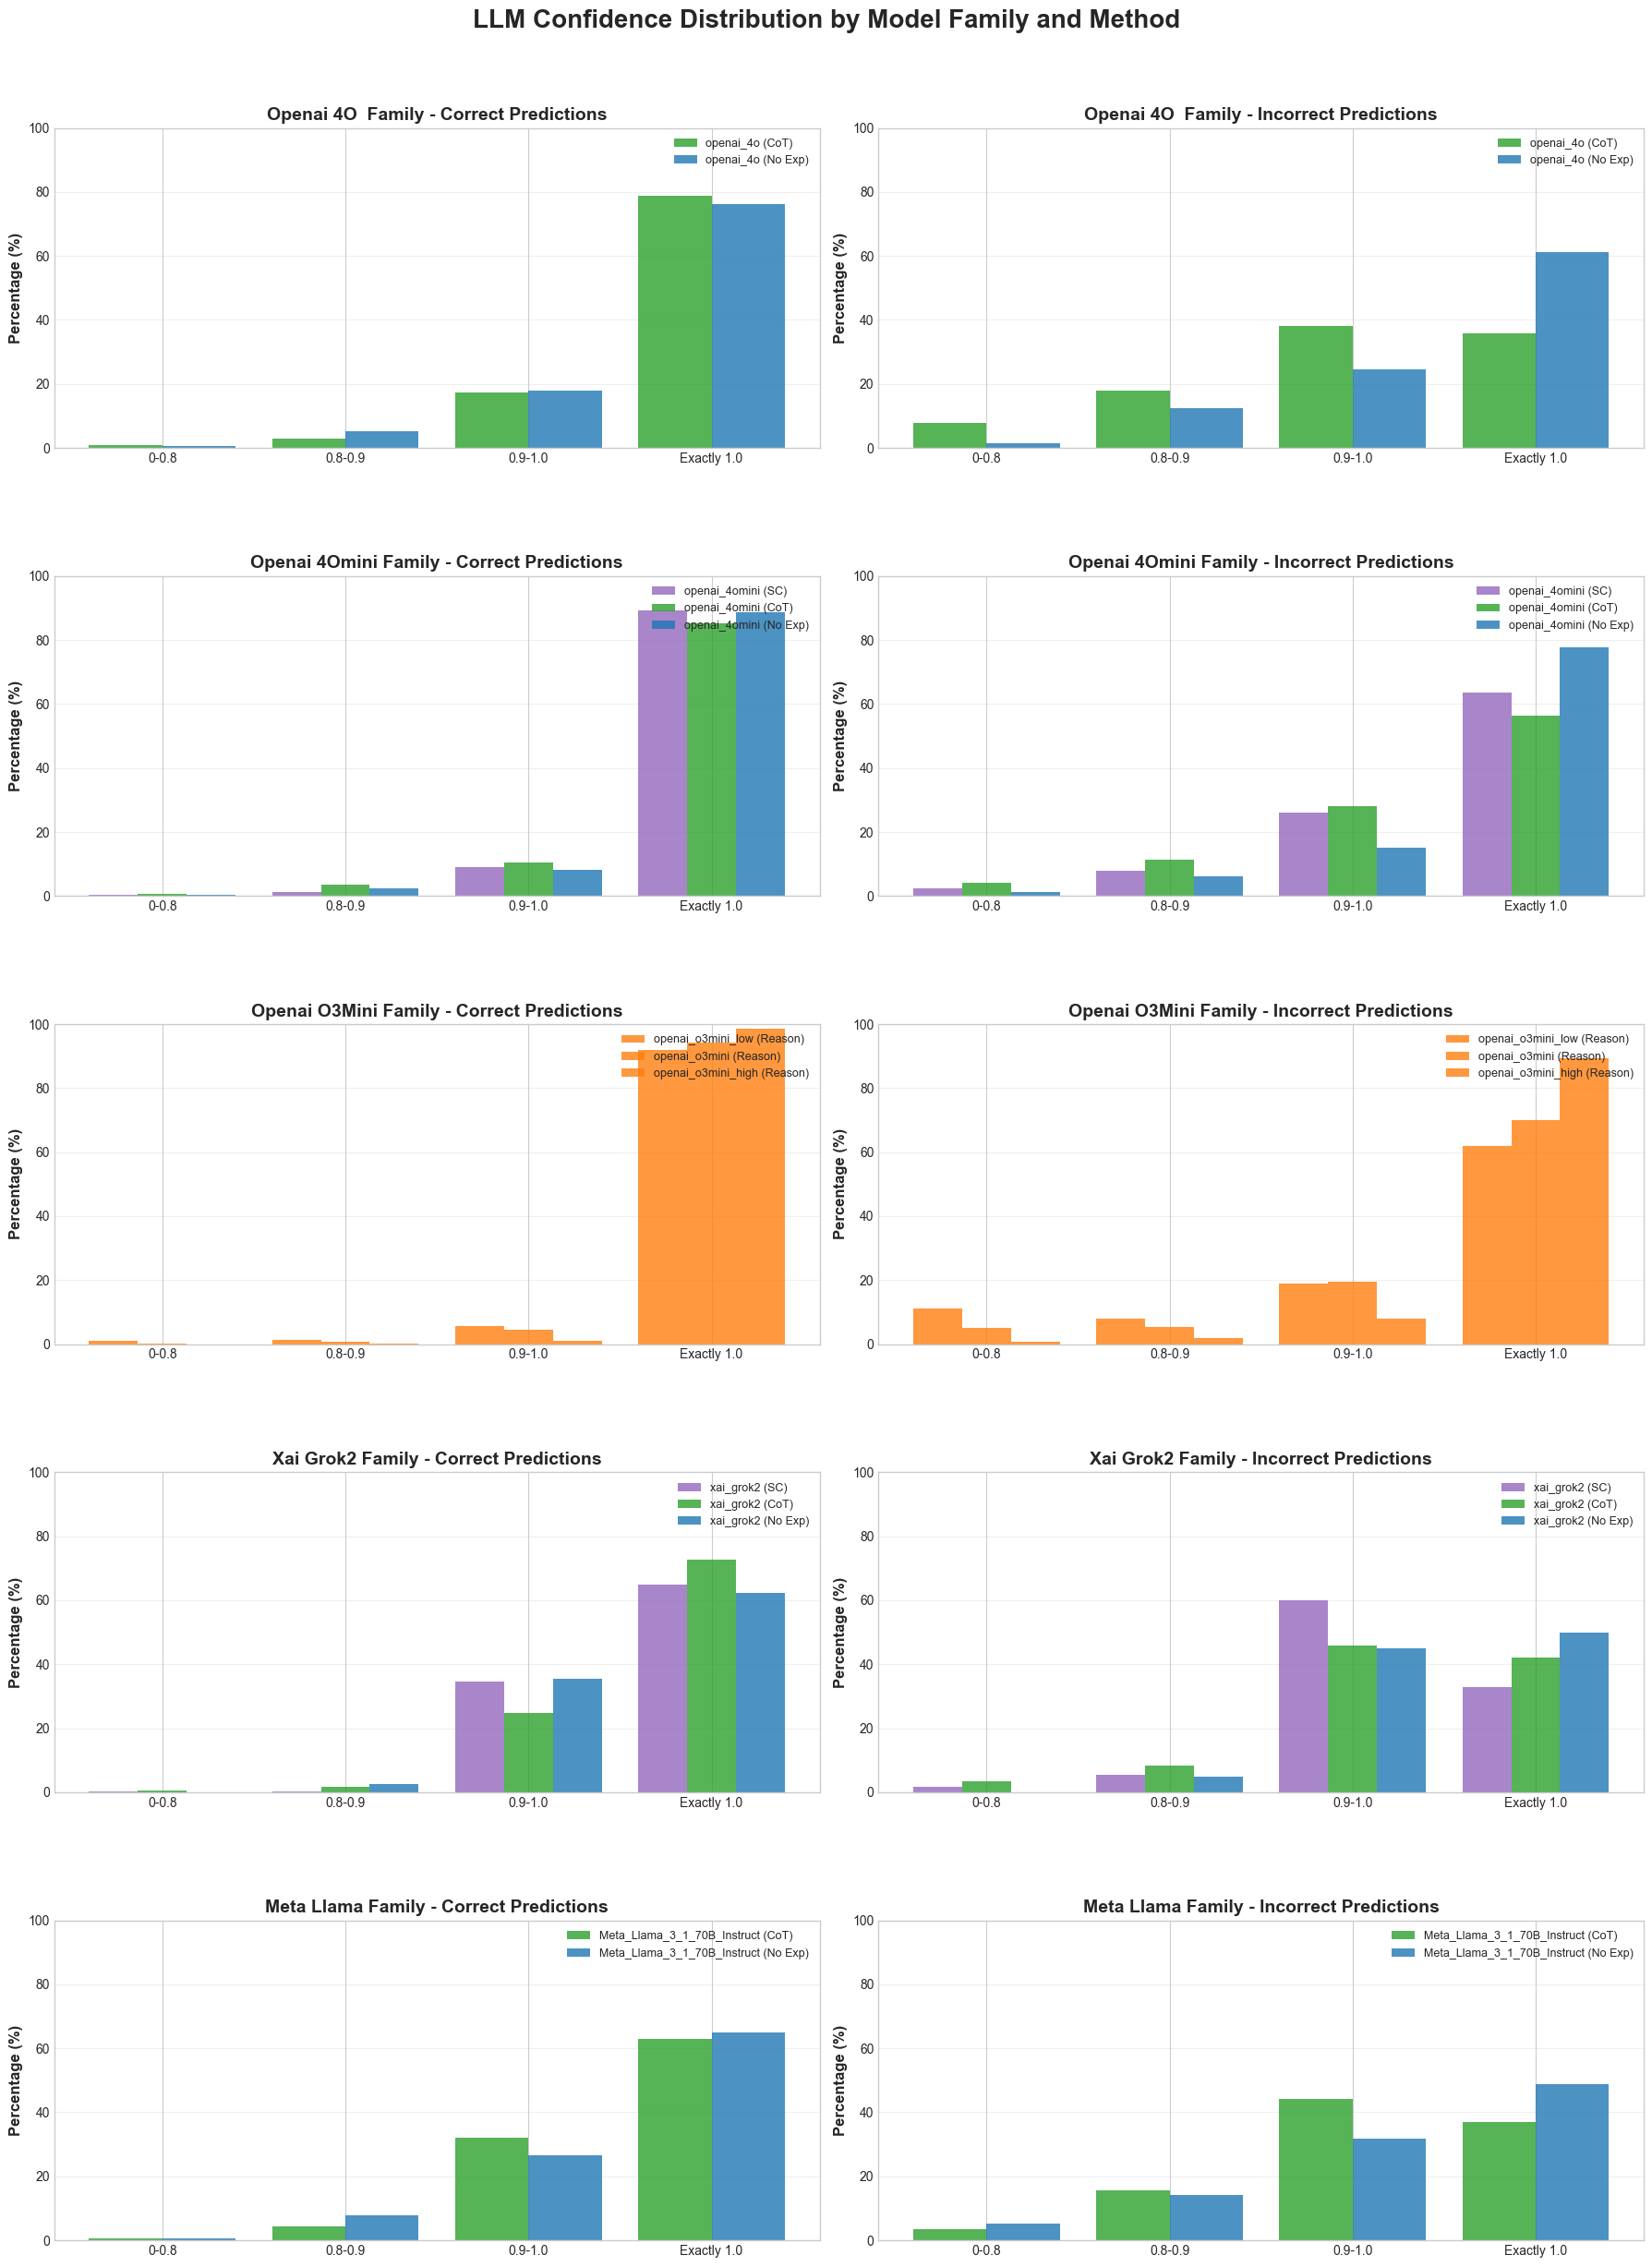

In [158]:
# Create a unified legend for method colors
method_colors = {
    'No Exp': '#1f77b4',  # Blue
    'Reason': '#ff7f0e',  # Orange
    'CoT': '#2ca02c',     # Green
    'LTM': '#d62728',     # Red
    'SC': '#9467bd'       # Purple
}

# Add a method legend at the bottom
method_legend_elements = []
for method, color in method_colors.items():
    method_legend_elements.append(
        plt.Line2D([0], [0], color=color, lw=4, label=method)
    )

fig.legend(handles=method_legend_elements, 
            loc='lower center', 
            ncol=5, 
            bbox_to_anchor=(0.5, 0), 
            fontsize=12,
            frameon=True,
            title="Reasoning Methods")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

def plot_confidence_distribution_barplot(dfs):
    """
    Create bar plots showing the distribution of LLM confidence in specified bins:
    0-0.8, 0.8-0.9, 0.9-1.0, and exactly 1.0.
    Models are grouped by family, with each reasoning method shown as a separate bar.
    """
    # Filter for models with reasoning
    reasoning_dfs = {k: v for k, v in dfs.items() if any(k.endswith(x) for x in ['_no_exp', '_reason', '_cot', '_sc'])}
    
    # Define colors for different model families
    family_colors = {
        'df_openai_4o_': '#1f77b4',      # Blue for GPT-4
        'df_openai_4omini': '#ff7f0e',   # Orange for GPT-4-mini
        'df_xai_grok2': '#2ca02c',       # Green for Grok-2
        'df_Meta_Llama': '#d62728',      # Red for Llama
        'df_claude': '#9467bd',          # Purple for Claude
        'df_openai_o3mini': '#8c564b',   # Brown for o3-mini
        'df_openai_o1': '#e377c2',       # Pink for GPT-o1
        'df_Qwen_QWQ': '#7f7f7f',        # Gray for Qwen-QWQ
    }
    
    # Define the confidence bins
    confidence_bins = [0, 0.8, 0.9, 1.0]
    confidence_bin_labels = ['0-0.8', '0.8-0.9', '0.9-1.0', 'Exactly 1.0']
    
    # Get model families and categorize dataframes by family
    family_dfs = {}
    for df_name, df in reasoning_dfs.items():
        # Find which family this model belongs to
        family = next((k for k in family_colors.keys() if k.lower() in df_name.lower()), 'Other')
        
        # Special case for o3-mini variants
        if 'o3mini' in df_name.lower():
            family = 'df_openai_o3mini'
            
        # Add to family group
        if family not in family_dfs:
            family_dfs[family] = {}
        
        # Determine method type
        if '_no_exp' in df_name:
            method_type = 'No Exp'
        elif '_reason' in df_name:
            method_type = 'Reason'
        elif '_cot' in df_name:
            method_type = 'CoT'
        elif '_ltm' in df_name:
            method_type = 'LTM'
        elif '_sc' in df_name:
            method_type = 'SC'
        else:
            method_type = 'Other'
            
        # Format model name
        model_name = df_name.replace('df_', '')
        model_name = model_name.replace('_no_exp', '').replace('_reason', '').replace('_cot', '').replace('_ltm', '').replace('_sc', '')
        
        # Add to family dictionary with method as key
        if model_name not in family_dfs[family]:
            family_dfs[family][model_name] = {}
        
        family_dfs[family][model_name][method_type] = df
    
    # Create a figure with subplots for each family
    num_families = len(family_dfs)
    fig = plt.figure(figsize=(18, 5 * num_families))
    gs = GridSpec(num_families, 2, figure=fig, width_ratios=[1, 1])
    
    # Function to get distinct colors for different methods
    def get_method_color(method_type):
        # Map each method type to a distinct color, completely different from other methods
        method_colors = {
            'No Exp': '#1f77b4',  # Blue
            'Reason': '#ff7f0e',  # Orange
            'CoT': '#2ca02c',     # Green
            'LTM': '#d62728',     # Red
            'SC': '#9467bd'       # Purple
        }
        return method_colors.get(method_type, '#7f7f7f')  # Default gray for unknown methods
    
    # Define function to plot grouped bars before using it
    def plot_grouped_bars(ax, data_list, bin_labels):
        if not data_list:
            ax.text(0.5, 0.5, "No data available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            return
            
        num_bins = len(bin_labels)
        num_methods = len(data_list)
        
        # Calculate bar width and positions
        bar_width = 0.8 / num_methods
        
        # Plot each method's bars
        for i, data in enumerate(data_list):
            x = np.arange(num_bins)
            offset = i * bar_width - (num_methods * bar_width / 2) + (bar_width / 2)
            ax.bar(x + offset, data['distribution'], width=bar_width, 
                  label=data['label'], color=data['color'], alpha=0.8)
        
        # Set x-axis labels
        ax.set_xticks(np.arange(num_bins))
        ax.set_xticklabels(bin_labels)
    
    # Process each family
    for i, (family, models) in enumerate(family_dfs.items()):
        # Create subplots for correct and incorrect predictions
        ax_correct = fig.add_subplot(gs[i, 0])
        ax_incorrect = fig.add_subplot(gs[i, 1])
        
        # Base color for this family
        family_base_color = family_colors[family]
        
        # Collect data for bar positions
        correct_data = []
        incorrect_data = []
        
        # Process each model in this family
        for model_name, methods in models.items():
            # Process each method for this model
            for method_type, df in methods.items():
                # Get method-specific color (now independent of family)
                method_color = get_method_color(method_type)
                
                # Clean data
                df_clean = df.copy()
                df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
                
                # Split by correctness
                df_correct = df_clean[df_clean['Correctness'] == 1]
                df_incorrect = df_clean[df_clean['Correctness'] == 0]
                
                # Function to compute confidence distribution for a dataframe
                def compute_confidence_distribution(df_subset):
                    if df_subset.empty:
                        return [0, 0, 0, 0]  # Return zeros if no data
                    
                    # Count values in each bin
                    bin_0_to_0_8 = ((df_subset['llm_confidence'] >= 0) & (df_subset['llm_confidence'] < 0.8)).sum()
                    bin_0_8_to_0_9 = ((df_subset['llm_confidence'] >= 0.8) & (df_subset['llm_confidence'] < 0.9)).sum()
                    bin_0_9_to_1_0 = ((df_subset['llm_confidence'] >= 0.9) & (df_subset['llm_confidence'] < 1.0)).sum()
                    bin_exactly_1 = (df_subset['llm_confidence'] == 1.0).sum()
                    
                    # Convert to percentages
                    total = len(df_subset)
                    if total > 0:
                        return [
                            bin_0_to_0_8 / total * 100,
                            bin_0_8_to_0_9 / total * 100,
                            bin_0_9_to_1_0 / total * 100,
                            bin_exactly_1 / total * 100
                        ]
                    else:
                        return [0, 0, 0, 0]
                
                # Compute distributions
                correct_distribution = compute_confidence_distribution(df_correct)
                incorrect_distribution = compute_confidence_distribution(df_incorrect)
                
                # Store for plotting
                label = f"{model_name} ({method_type})"
                correct_data.append({
                    'label': label,
                    'distribution': correct_distribution,
                    'color': method_color
                })
                incorrect_data.append({
                    'label': label,
                    'distribution': incorrect_distribution,
                    'color': method_color
                })
        
        # Plot the bars with proper spacing
        plot_grouped_bars(ax_correct, correct_data, confidence_bin_labels)
        plot_grouped_bars(ax_incorrect, incorrect_data, confidence_bin_labels)
        
        # Set titles and customize plots
        ax_correct.set_title(f"{family.replace('df_', '').replace('_', ' ').title()} Family - Correct Predictions", 
                            fontsize=14, fontweight='bold')
        ax_incorrect.set_title(f"{family.replace('df_', '').replace('_', ' ').title()} Family - Incorrect Predictions", 
                              fontsize=14, fontweight='bold')
        
        # Customize both plots
        for ax in [ax_correct, ax_incorrect]:
            ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
            ax.set_ylim(0, 100)
            ax.grid(axis='y', alpha=0.3)
            ax.legend(loc='upper right', fontsize=9)
    
    # Function to plot grouped bars
    def plot_grouped_bars(ax, data_list, bin_labels):
        if not data_list:
            ax.text(0.5, 0.5, "No data available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            return
            
        num_bins = len(bin_labels)
        num_methods = len(data_list)
        
        # Calculate bar width and positions
        bar_width = 0.8 / num_methods
        
        # Plot each method's bars
        for i, data in enumerate(data_list):
            x = np.arange(num_bins)
            offset = i * bar_width - (num_methods * bar_width / 2) + (bar_width / 2)
            ax.bar(x + offset, data['distribution'], width=bar_width, 
                  label=data['label'], color=data['color'], alpha=0.8)
        
        # Set x-axis labels
        ax.set_xticks(np.arange(num_bins))
        ax.set_xticklabels(bin_labels)
    def plot_grouped_bars(ax, data_list, bin_labels):
        if not data_list:
            ax.text(0.5, 0.5, "No data available", 
                   ha='center', va='center', transform=ax.transAxes, fontsize=14)
            return
            
        num_bins = len(bin_labels)
        num_methods = len(data_list)
        
        # Calculate bar width and positions
        bar_width = 0.8 / num_methods
        
        # Plot each method's bars
        for i, data in enumerate(data_list):
            x = np.arange(num_bins)
            offset = i * bar_width - (num_methods * bar_width / 2) + (bar_width / 2)
            ax.bar(x + offset, data['distribution'], width=bar_width, 
                  label=data['label'], color=data['color'], alpha=0.8)
        
        # Set x-axis labels
        ax.set_xticks(np.arange(num_bins))
        ax.set_xticklabels(bin_labels)
    
    # Add a title to the entire figure
    plt.suptitle('LLM Confidence Distribution by Model Family and Method', 
                fontsize=20, fontweight='bold', y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(hspace=0.4)
    
    # Save the figure
    fig.savefig("../llm_confidence_distribution_barplot.pdf", bbox_inches='tight', dpi=300)
    
    return fig

fig = plot_confidence_distribution_barplot(dfs)
plt.show()

AttributeError: 'list' object has no attribute 'items'

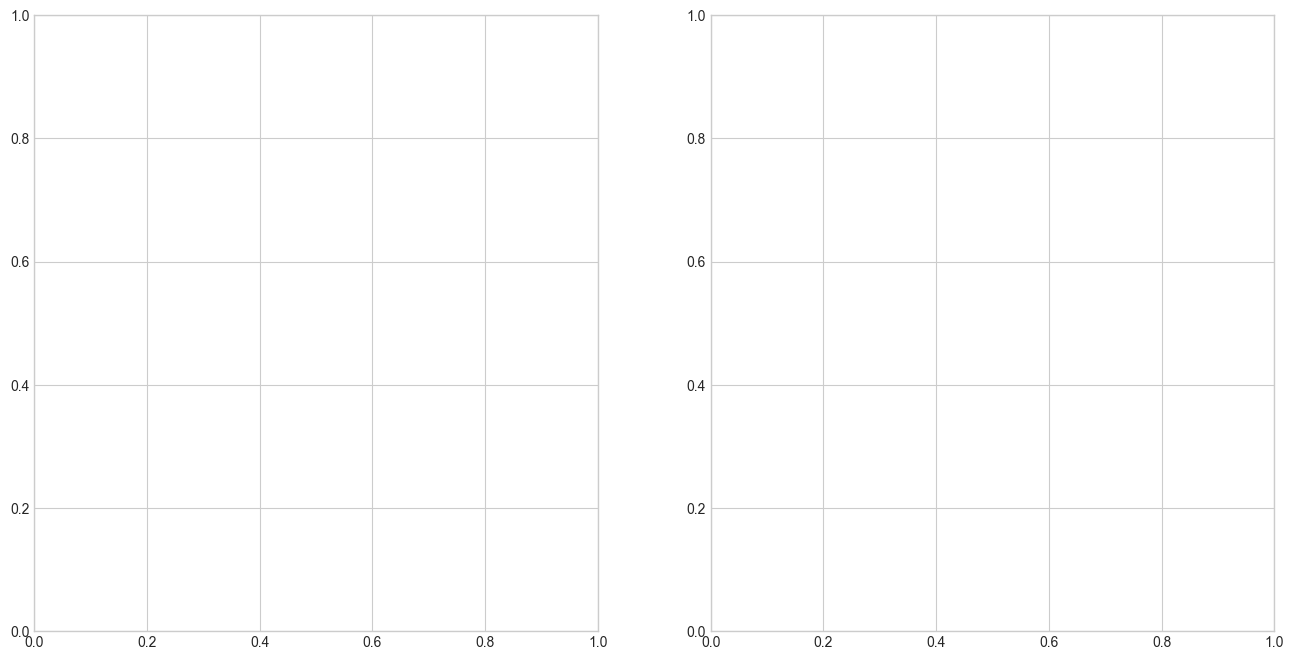

In [436]:
def analyze_confidence_distributions(dfs_dict):
    """
    Analyze and visualize confidence distributions for correct and incorrect predictions across different models.
    Also calculates overconfidence and underconfidence errors by prediction type and question category.
    
    Args:
        dfs_dict: Dictionary mapping model names to dataframes
        
    Returns:
        matplotlib figure object and results table
    """
    from scipy.stats import gaussian_kde
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Generate colors for different models
    colors = plt.cm.rainbow(np.linspace(0, 1, len(dfs_dict)))
    
    # Initialize results table
    results = []
    
    # Plot confidence distribution for incorrect predictions
    for (name, df), color in zip(dfs_dict.items(), colors):
        # Combine Logical, Spatial, and Knowledge into Commonsense
        df = df.copy()
        df.loc[df['Type'].isin(['Logical', 'Spatial', 'Knowledge']), 'Type'] = 'Commonsense'
        
        df_incorrect = df[df['Correctness'] == 0]
        df_correct = df[df['Correctness'] == 1]
        
        # Calculate overall errors
        avg_conf_incorrect = df_incorrect['llm_confidence'].mean()
        avg_conf_correct = df_correct['llm_confidence'].mean()
        
        # Add overall metrics to results
        results.append({
            'Model': name,
            'Question Type': 'Overall',
            'Avg Conf Incorrect': f"{avg_conf_incorrect:.3f}",
            'Overconfidence Error': f"{avg_conf_incorrect:.3f}",
            'Avg Conf Correct': f"{avg_conf_correct:.3f}", 
            'Underconfidence Error': f"{(1.0 - avg_conf_correct):.3f}"
        })
        
        # Calculate errors by question type
        for qtype in df['Type'].unique():
            df_type = df[df['Type'] == qtype]
            df_type_incorrect = df_type[df_type['Correctness'] == 0]
            df_type_correct = df_type[df_type['Correctness'] == 1]
            
            avg_conf_incorrect_type = df_type_incorrect['llm_confidence'].mean()
            avg_conf_correct_type = df_type_correct['llm_confidence'].mean()
            
            results.append({
                'Model': name,
                'Question Type': qtype,
                'Avg Conf Incorrect': f"{avg_conf_incorrect_type:.3f}",
                'Overconfidence Error': f"{avg_conf_incorrect_type:.3f}",
                'Avg Conf Correct': f"{avg_conf_correct_type:.3f}",
                'Underconfidence Error': f"{(1.0 - avg_conf_correct_type):.3f}"
            })
        
        # Calculate kernel density estimate for incorrect predictions
        density = gaussian_kde(df_incorrect['llm_confidence'])
        xs = np.linspace(0, 1, 200)
        ax1.plot(xs, density(xs), label=name, color=color)

    ax1.set_title('LLM Confidence Distribution\nfor Incorrect Predictions')
    ax1.set_xlabel('Confidence')
    ax1.set_ylabel('Density')
    ax1.legend()

    # Plot confidence distribution for correct predictions
    for (name, df), color in zip(dfs_dict.items(), colors):
        # Combine Logical, Spatial, and Knowledge into Commonsense
        df = df.copy()
        df.loc[df['Type'].isin(['Logical', 'Spatial', 'Knowledge']), 'Type'] = 'Commonsense'
        
        df_correct = df[df['Correctness'] == 1]
        # Calculate kernel density estimate
        density = gaussian_kde(df_correct['llm_confidence'])
        xs = np.linspace(0, 1, 200)
        ax2.plot(xs, density(xs), label=name, color=color)

    ax2.set_title('LLM Confidence Distribution\nfor Correct Predictions')
    ax2.set_xlabel('Confidence')
    ax2.set_ylabel('Density')
    ax2.legend()

    plt.tight_layout()
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return fig, results_df

fig, results_table = analyze_confidence_distributions(dfs)
display(results_table)

In [333]:
def analyze_confidence_calibration_ratios(dfs):
    """
    Calculate and print the ratio of perfectly calibrated, overconfident, and 
    underconfident samples for each model, organized in a table format.
    Also includes average token usage and correctness.
    """
    # Initialize results list
    results = []
    
    # Map model names to more readable format
    name_mapping = {
        'df_openai_4o_cot': '4o (CoT)',
        'df_openai_4omini_sc': '4o-mini (SC)', 
        'df_openai_o3mini_medium_reason': 'o3-mini-med',
        'df_openai_o3mini_low_reason': 'o3-mini-low',
        'df_xai_grok2_sc': 'Grok-2 (SC)',
        'df_Meta_Llama_3_1_8B_Instruct_cot': 'Llama-3-8B',
        'df_openai_4omini_cot': '4o-mini (CoT)',
        'df_claude_haiku_cot': 'Haiku (CoT)',
        'df_Meta_Llama_3_1_70B_Instruct_cot': 'Llama-3-70B',
        'df_claude_sonnet_thinking_reason': 'Sonnet',
        'df_xai_grok2_cot': 'Grok-2 (CoT)',
        'df_openai_o3mini_high_reason': 'o3-mini-high',
        'df_openai_o1_reason': 'GPT-o1',
        'df_openai_4omini_ltm': '4o-mini (LtM)',
        'df_xai_grok2_ltm': 'Grok-2 (LtM)',
        'df_Qwen_QWQ_reason': 'Qwen-QWQ',
    }
    
    # Process each model
    for df_name, df in dfs.items():
        # Get the mapped name with a more flexible approach
        # Extract key components from the name
        if 'Meta_Llama' in df_name:
            model_name = df_name.replace('df_', '').replace('_Instruct', '')
        elif 'openai' in df_name:
            model_name = df_name.replace('df_openai_', '')
        elif 'claude' in df_name:
            model_name = df_name.replace('df_claude_', '')
        elif 'xai' in df_name:
            model_name = df_name.replace('df_xai_', '')
        elif 'Qwen' in df_name:
            model_name = df_name.replace('df_Qwen_', '')
        else:
            model_name = df_name.replace('df_', '')
            
        df_clean = df.copy()
        df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
        
        # Drop rows with NaN confidence
        df_clean = df_clean.dropna(subset=['llm_confidence'])
        
        if df_clean.empty:
            continue
            
        # Calculate mean confidence as threshold
        confidence_threshold = df_clean['llm_confidence'].mean()
        
        # Calculate average tokens and correctness
        avg_tokens = df_clean['completion_tokens'].mean()
        avg_correctness = df_clean['Correctness'].mean()
        
        # Determine reasoning type
        if df_name.endswith('_reason'):
            reasoning_type = 'Reasoning'
        elif any(df_name.endswith(x) for x in ['_cot', '_sc', '_ltm']):
            reasoning_type = 'Prompt-based'
        else:
            reasoning_type = 'Other'
        
        # Calculate metrics
        total_samples = len(df_clean)
        
        # Perfectly calibrated: confidence ≈ mean for correct and confidence ≈ mean for incorrect
        perfect_cal = (
            ((df_clean['Correctness'] == 1) & (df_clean['llm_confidence'] >= confidence_threshold)) | 
            ((df_clean['Correctness'] == 0) & (df_clean['llm_confidence'] < confidence_threshold))
        ).sum()
        
        # Overconfident: confidence > mean when incorrect
        overconfident = ((df_clean['Correctness'] == 0) & 
                        (df_clean['llm_confidence'] >= confidence_threshold)).sum()
        
        # Underconfident: confidence < mean when correct
        underconfident = ((df_clean['Correctness'] == 1) & 
                         (df_clean['llm_confidence'] < confidence_threshold)).sum()
        
        # Calculate ratios
        perfect_ratio = perfect_cal / total_samples
        over_ratio = overconfident / total_samples
        under_ratio = underconfident / total_samples
        
        # Add to results
        results.append({
            'Model Name': model_name,
            'Reasoning Type': reasoning_type,
            'Total Samples': total_samples,
            'Perfect Calibration': perfect_cal,
            'Overconfident': overconfident,
            'Underconfident': underconfident,
            'Perfect Ratio': perfect_ratio,
            'Over Ratio': over_ratio,
            'Under Ratio': under_ratio,
            'Confidence Threshold': confidence_threshold,
            'Avg Tokens': avg_tokens,
            'Avg Correctness': avg_correctness
        })
    
    # Convert to DataFrame for nice printing
    results_df = pd.DataFrame(results)
    
    # Sort by reasoning type and then by perfect calibration ratio (descending)
    results_df = results_df.sort_values(by=['Reasoning Type', 'Perfect Ratio'], ascending=[True, False])
    
    # Format ratios as percentages
    results_df['Perfect Ratio'] = results_df['Perfect Ratio'].map('{:.1%}'.format)
    results_df['Over Ratio'] = results_df['Over Ratio'].map('{:.1%}'.format)
    results_df['Under Ratio'] = results_df['Under Ratio'].map('{:.1%}'.format)
    
    # Display the results
    print("\nConfidence Calibration Ratios by Model\n")
    print("Using mean confidence as threshold for each model\n")
    
    # Print table with fixed-width formatting
    print(f"{'Model Name':<25} {'Reasoning Type':<15} {'Total':<8} {'Perfect':<10} {'Over':<10} {'Under':<10} {'Threshold':<10} {'Avg Tokens':<12} {'Correctness':<10}")
    print(f"{'-'*25} {'-'*15} {'-'*8} {'-'*10} {'-'*10} {'-'*10} {'-'*10} {'-'*12} {'-'*10}")
    
    for _, row in results_df.iterrows():
        print(f"{row['Model Name']:<25} {row['Reasoning Type']:<15} {row['Total Samples']:<8} "
              f"{row['Perfect Ratio']:<10} {row['Over Ratio']:<10} {row['Under Ratio']:<10} "
              f"{row['Confidence Threshold']:.3f}    {row['Avg Tokens']:<12.1f} {row['Avg Correctness']:.3f}")
    
    # Calculate averages by reasoning type
    print("\nAverages by Reasoning Type:\n")
    print(f"{'Reasoning Type':<15} {'Total':<8} {'Perfect':<10} {'Over':<10} {'Under':<10} {'Avg Tokens':<12} {'Correctness':<10}")
    print(f"{'-'*15} {'-'*8} {'-'*10} {'-'*10} {'-'*10} {'-'*12} {'-'*10}")
    
    for reasoning_type in ['Reasoning', 'Prompt-based', 'Other']:
        type_rows = results_df[results_df['Reasoning Type'] == reasoning_type]
        if not type_rows.empty:
            # Convert string percentages back to floats for averaging
            perfect_avg = type_rows['Perfect Ratio'].str.rstrip('%').astype('float') / 100
            over_avg = type_rows['Over Ratio'].str.rstrip('%').astype('float') / 100
            under_avg = type_rows['Under Ratio'].str.rstrip('%').astype('float') / 100
            
            avg_total = type_rows['Total Samples'].mean()
            avg_perfect = perfect_avg.mean()
            avg_over = over_avg.mean()
            avg_under = under_avg.mean()
            avg_tokens = type_rows['Avg Tokens'].mean()
            avg_correctness = type_rows['Avg Correctness'].mean()
            
            print(f"{reasoning_type:<15} {avg_total:<8.1f} {avg_perfect:<10.1%} {avg_over:<10.1%} "
                  f"{avg_under:<10.1%} {avg_tokens:<12.1f} {avg_correctness:.3f}")
    
    return results_df

# Run the analysis
results = analyze_confidence_calibration_ratios(dfs)


Confidence Calibration Ratios by Model

Using mean confidence as threshold for each model

Model Name                Reasoning Type  Total    Perfect    Over       Under      Threshold  Avg Tokens   Correctness
------------------------- --------------- -------- ---------- ---------- ---------- ---------- ------------ ----------
o1_low                    Other           1001     87.2%      12.4%      0.4%       0.999    1181.7       0.872
o3mini_low                Other           3148     81.8%      11.7%      6.5%       0.976    236.0        0.811
4o_noexp                  Other           3148     62.5%      22.5%      15.1%      0.961    25.2         0.633
grok2_noexp               Other           3148     57.4%      19.5%      23.1%      0.960    25.6         0.610
4omini_noexp              Other           3133     57.2%      36.9%      5.9%       0.977    61.4         0.525
Meta_Llama_3_1_70B_noexp  Other           3142     56.4%      28.7%      14.9%      0.934    25.7         0.5

In [214]:
df_openai_o3mini_high[df_openai_o3mini_high['Correctness'] == 0]['completion_tokens'].mean()

np.float64(3666.463087248322)

In [230]:
df_openai_4o_cot['llm_confidence'] - df_openai_4o_noexp ['llm_confidence']

llm_confidence
 0.00    2343
 0.10     287
-0.10     229
-0.05      44
 0.05      44
-0.20      39
 0.20      31
-0.20      20
-0.30      19
 0.05      15
 0.10      13
-0.40      10
-0.05       9
-0.10       8
-0.15       7
 0.20       6
 0.15       4
-1.00       3
-0.25       3
-0.50       3
-0.40       2
 0.40       2
 0.30       2
-0.15       1
-0.60       1
-0.01       1
Name: count, dtype: int64

In [307]:
# Calculate calibration error for each approach
def analyze_calibration_changes(dfs_and_names):
    """
    Analyze calibration changes between pairs of dataframes.
    
    Args:
        dfs_and_names: List of tuples containing (df1, df2, name1, name2)
    """
    # Create a figure with subplots arranged in a grid
    n_comparisons = len(dfs_and_names)
    n_cols = 3
    n_rows = (n_comparisons + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(20, 6*n_rows))
    
    for i, (df1, df2, name1, name2) in enumerate(dfs_and_names, 1):
        # Calculate calibration error for each approach
        error1 = abs(df1['Correctness'] - df1['llm_confidence'])
        error2 = abs(df2['Correctness'] - df2['llm_confidence'])

        # Get confidence differences
        conf_diff = df1['llm_confidence'] - df2['llm_confidence']

        # For non-zero confidence changes, check if calibration improved
        nonzero_changes = conf_diff[conf_diff != 0]
        reduced_under_inc = 0  # Reduced underconfidence by increasing confidence
        reduced_over_dec = 0  # Reduced overconfidence by decreasing confidence  
        increased_under_dec = 0  # Increased underconfidence by decreasing confidence
        increased_over_inc = 0  # Increased overconfidence by increasing confidence

        # Align indices between errors before comparison
        aligned_indices = nonzero_changes.index.intersection(error1.index).intersection(error2.index)

        for idx in aligned_indices:
            if error1[idx] < error2[idx]:  # Improved calibration
                if conf_diff[idx] > 0:
                    reduced_under_inc += 1
                else:
                    reduced_over_dec += 1
            elif error1[idx] > error2[idx]:  # Worsened calibration
                if conf_diff[idx] > 0:
                    increased_over_inc += 1
                else:
                    increased_under_dec += 1

        # Create subplot
        ax = plt.subplot(n_rows, n_cols, i)

        # Create pie chart with 4 categories
        labels = ['Reduced Underconfidence\n(Increased Conf)', 
                 'Reduced Overconfidence\n(Decreased Conf)',
                 'Increased Overconfidence\n(Increased Conf)', 
                 'Increased Underconfidence\n(Decreased Conf)']
        sizes = [reduced_under_inc, reduced_over_dec, increased_over_inc, increased_under_dec]
        colors = ['#2ecc71', '#27ae60', '#e74c3c', '#c0392b']
        ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

        ax.set_title(f'Calibration Changes: {name1} vs {name2}\n' +
                    f'(Total {len(aligned_indices)} cases)', pad=20)

        # Print detailed statistics
        print(f"\nComparison {i}: {name1} vs {name2}")
        print(f"Out of {len(aligned_indices)} cases where confidence changed:")
        print("\nImproved calibration cases:")
        print(f"- Reduced underconfidence by increasing confidence: {reduced_under_inc} cases ({reduced_under_inc/len(aligned_indices)*100:.1f}%)")
        print(f"- Reduced overconfidence by decreasing confidence: {reduced_over_dec} cases ({reduced_over_dec/len(aligned_indices)*100:.1f}%)")
        print("\nWorsened calibration cases:")
        print(f"- Increased overconfidence by increasing confidence: {increased_over_inc} cases ({increased_over_inc/len(aligned_indices)*100:.1f}%)")
        print(f"- Increased underconfidence by decreasing confidence: {increased_under_dec} cases ({increased_under_dec/len(aligned_indices)*100:.1f}%)")

    plt.tight_layout()
    plt.show()

# Define comparisons
comparisons = [
    (df_openai_4omini_sc, df_openai_4omini_cot, "4omini_sc", "4omini_cot"),
    (df_openai_4omini_cot, df_openai_4omini_noexp, "4omini_cot", "4omini_noexp"),
    (df_xai_grok2_sc, df_xai_grok2_cot, "grok2_sc", "grok2_cot"),
    (df_xai_grok2_cot, df_xai_grok2_noexp, "grok2_cot", "grok2_noexp"),
    (df_openai_o1_reason, df_openai_o3mini_high, "o1_reason", "o1_mini"),
    (df_openai_o3mini_medium_reason, df_openai_o3mini_low_reason, "o3mini_medium", "o3mini_low")
]

analyze_calibration_changes(comparisons)


Comparison 1: 4omini_sc vs 4omini_cot
Out of 789 cases where confidence changed:

Improved calibration cases:
- Reduced underconfidence by increasing confidence: 255 cases (32.3%)
- Reduced overconfidence by decreasing confidence: 149 cases (18.9%)

Worsened calibration cases:
- Increased overconfidence by increasing confidence: 283 cases (35.9%)
- Increased underconfidence by decreasing confidence: 101 cases (12.8%)

Comparison 2: 4omini_cot vs 4omini_noexp
Out of 766 cases where confidence changed:

Improved calibration cases:
- Reduced underconfidence by increasing confidence: 117 cases (15.3%)
- Reduced overconfidence by decreasing confidence: 352 cases (46.0%)

Worsened calibration cases:
- Increased overconfidence by increasing confidence: 117 cases (15.3%)
- Increased underconfidence by decreasing confidence: 177 cases (23.1%)

Comparison 3: grok2_sc vs grok2_cot
Out of 1086 cases where confidence changed:

Improved calibration cases:
- Reduced underconfidence by increasing con

/Users/guangyawan/miniconda3/envs/langchain_env/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3343: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 2000x1200 with 5 Axes>


Comparison 1: 4omini_sc vs 4omini_cot
Out of 789 cases where confidence changed:

Improved calibration cases:
- Reduced underconfidence by increasing confidence: 255 cases (32.3%)
- Reduced overconfidence by decreasing confidence: 149 cases (18.9%)

Worsened calibration cases:
- Increased overconfidence by increasing confidence: 283 cases (35.9%)
- Increased underconfidence by decreasing confidence: 101 cases (12.8%)

Comparison 2: 4omini_cot vs 4omini_noexp
Out of 766 cases where confidence changed:

Improved calibration cases:
- Reduced underconfidence by increasing confidence: 117 cases (15.3%)
- Reduced overconfidence by decreasing confidence: 352 cases (46.0%)

Worsened calibration cases:
- Increased overconfidence by increasing confidence: 117 cases (15.3%)
- Increased underconfidence by decreasing confidence: 177 cases (23.1%)

Comparison 3: grok2_sc vs grok2_cot
Out of 1086 cases where confidence changed:

Improved calibration cases:
- Reduced underconfidence by increasing con

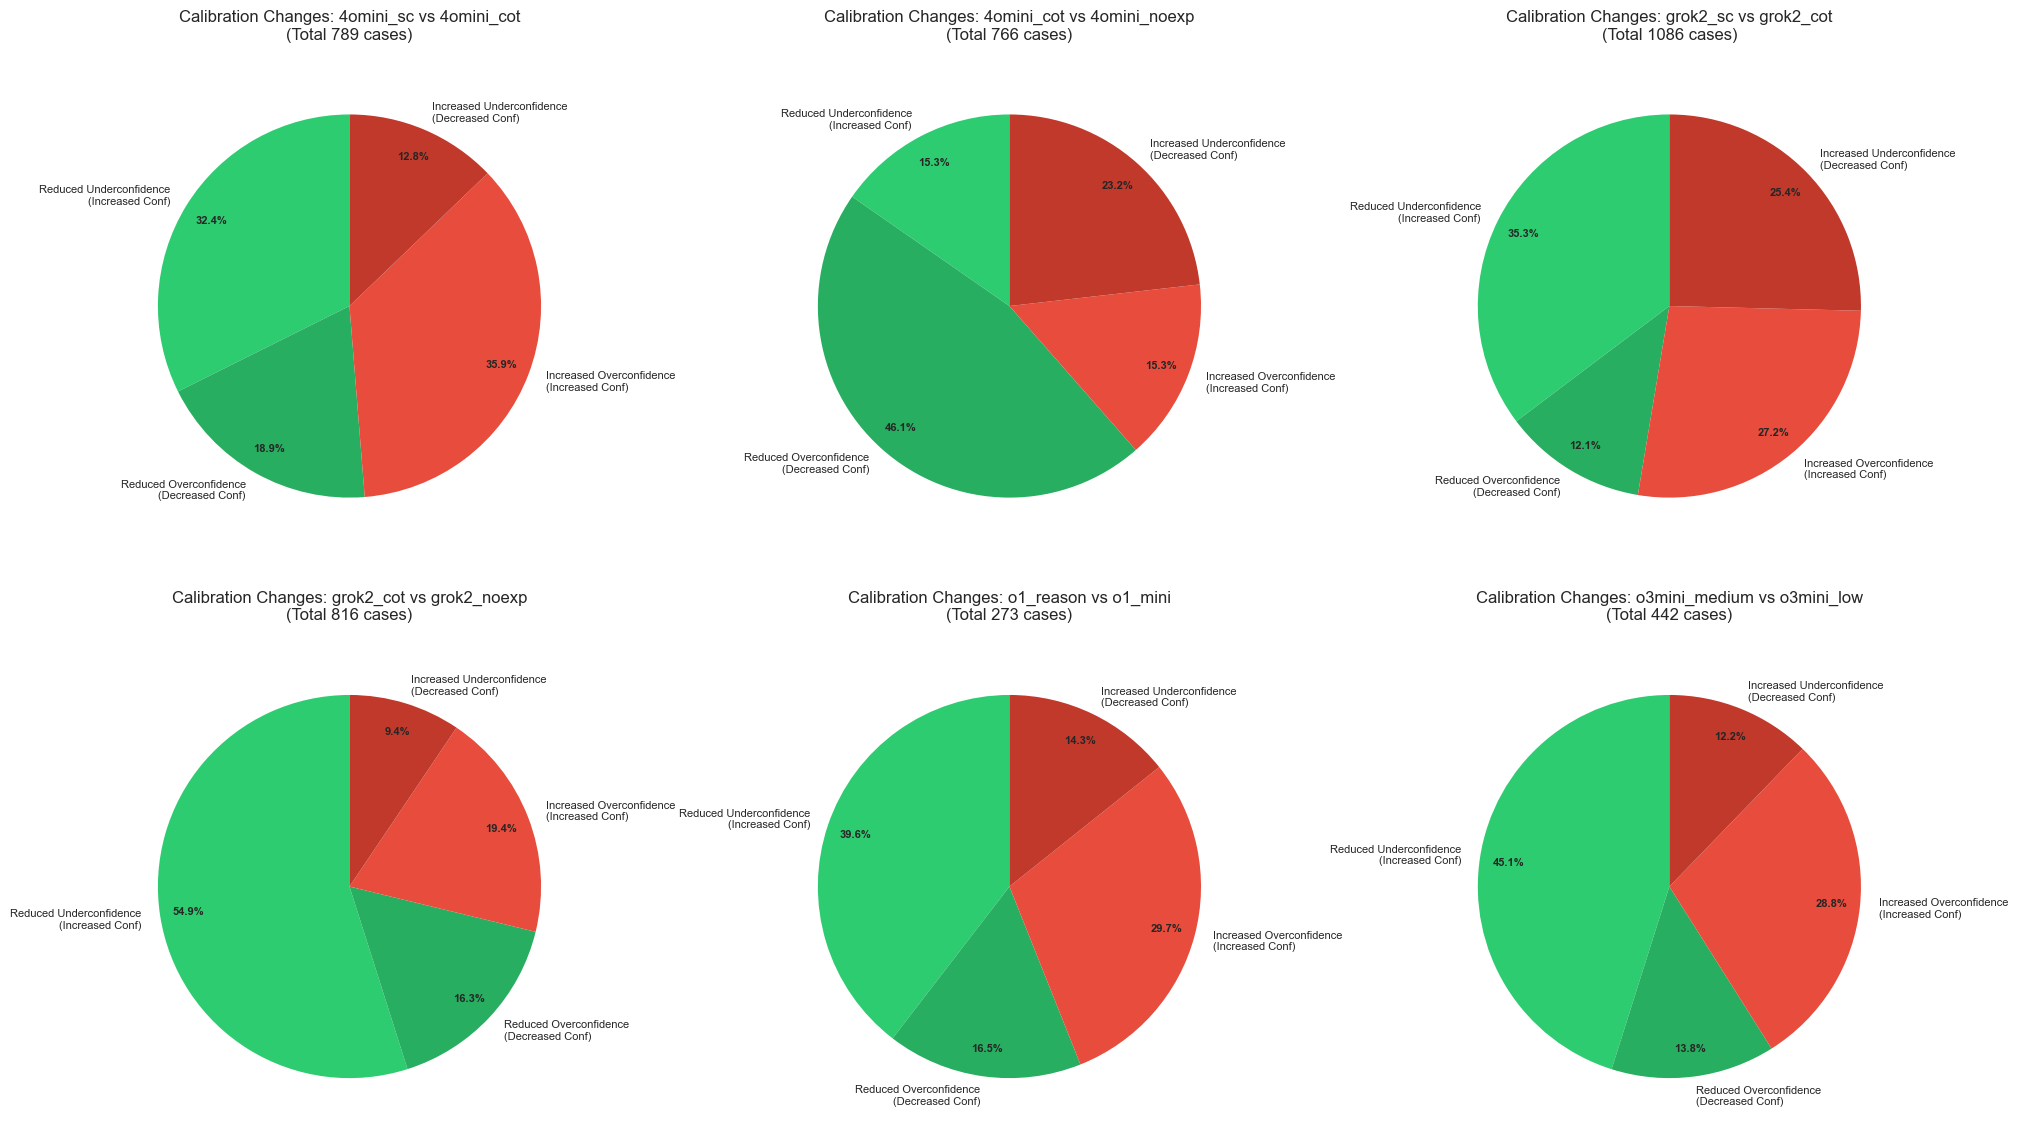

In [312]:
# Calculate calibration error for each approach
def analyze_calibration_changes(dfs_and_names):
    """
    Analyze calibration changes between pairs of dataframes.
    
    Args:
        dfs_and_names: List of tuples containing (df1, df2, name1, name2)
    """
    # Create a figure with subplots arranged in a grid
    n_comparisons = len(dfs_and_names)
    n_cols = 3
    n_rows = (n_comparisons + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(20, 6*n_rows))
    
    for i, (df1, df2, name1, name2) in enumerate(dfs_and_names, 1):
        # Calculate calibration error for each approach
        error1 = abs(df1['Correctness'] - df1['llm_confidence'])
        error2 = abs(df2['Correctness'] - df2['llm_confidence'])

        # Get confidence differences
        conf_diff = df1['llm_confidence'] - df2['llm_confidence']

        # For non-zero confidence changes, check if calibration improved
        nonzero_changes = conf_diff[conf_diff != 0]
        reduced_under_inc = 0  # Reduced underconfidence by increasing confidence
        reduced_over_dec = 0  # Reduced overconfidence by decreasing confidence  
        increased_under_dec = 0  # Increased underconfidence by decreasing confidence
        increased_over_inc = 0  # Increased overconfidence by increasing confidence

        # Align indices between errors before comparison
        aligned_indices = nonzero_changes.index.intersection(error1.index).intersection(error2.index)

        if len(aligned_indices) == 0:
            print(f"\nSkipping comparison {i}: {name1} vs {name2} - No aligned indices found")
            continue

        for idx in aligned_indices:
            if error1[idx] < error2[idx]:  # Improved calibration
                if conf_diff[idx] > 0:
                    reduced_under_inc += 1
                else:
                    reduced_over_dec += 1
            elif error1[idx] > error2[idx]:  # Worsened calibration
                if conf_diff[idx] > 0:
                    increased_over_inc += 1
                else:
                    increased_under_dec += 1

        # Create subplot
        ax = plt.subplot(n_rows, n_cols, i)

        # Create pie chart with 4 categories
        labels = ['Reduced Underconfidence\n(Increased Conf)', 
                 'Reduced Overconfidence\n(Decreased Conf)',
                 'Increased Overconfidence\n(Increased Conf)', 
                 'Increased Underconfidence\n(Decreased Conf)']
        sizes = [reduced_under_inc, reduced_over_dec, increased_over_inc, increased_under_dec]
        
        # Check if all sizes are 0
        if sum(sizes) == 0:
            print(f"\nSkipping pie chart for comparison {i}: {name1} vs {name2} - All sizes are 0")
            continue
            
        colors = ['#2ecc71', '#27ae60', '#e74c3c', '#c0392b']
        wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
                                        startangle=90, pctdistance=0.85)

        # Enhance text appearance
        plt.setp(autotexts, size=8, weight="bold")
        plt.setp(texts, size=8)

        ax.set_title(f'Calibration Changes: {name1} vs {name2}\n' +
                    f'(Total {len(aligned_indices)} cases)', pad=20)

        # Print detailed statistics
        print(f"\nComparison {i}: {name1} vs {name2}")
        print(f"Out of {len(aligned_indices)} cases where confidence changed:")
        print("\nImproved calibration cases:")
        print(f"- Reduced underconfidence by increasing confidence: {reduced_under_inc} cases ({reduced_under_inc/len(aligned_indices)*100:.1f}%)")
        print(f"- Reduced overconfidence by decreasing confidence: {reduced_over_dec} cases ({reduced_over_dec/len(aligned_indices)*100:.1f}%)")
        print("\nWorsened calibration cases:")
        print(f"- Increased overconfidence by increasing confidence: {increased_over_inc} cases ({increased_over_inc/len(aligned_indices)*100:.1f}%)")
        print(f"- Increased underconfidence by decreasing confidence: {increased_under_dec} cases ({increased_under_dec/len(aligned_indices)*100:.1f}%)")

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Define comparisons
comparisons = [
    (df_openai_4omini_sc, df_openai_4omini_cot, "4omini_sc", "4omini_cot"),
    (df_openai_4omini_cot, df_openai_4omini_noexp, "4omini_cot", "4omini_noexp"),
    (df_xai_grok2_sc, df_xai_grok2_cot, "grok2_sc", "grok2_cot"),
    (df_xai_grok2_cot, df_xai_grok2_noexp, "grok2_cot", "grok2_noexp"),
    (df_openai_o1_reason, df_openai_o1_low, "o1_reason", "o1_mini"),
    (df_openai_o3mini_medium_reason, df_openai_o3mini_low_reason, "o3mini_medium", "o3mini_low")
]

analyze_calibration_changes(comparisons)

In [308]:
analyze_calibration_changes(df_openai_4omini_sc, df_openai_4omini_cot)
analyze_calibration_changes(df_openai_4omini_cot, df_openai_4omini_noexp)
analyze_calibration_changes(df_xai_grok2_sc, df_xai_grok2_cot)
analyze_calibration_changes(df_xai_grok2_cot, df_xai_grok2_noexp)
analyze_calibration_changes(df_openai_4omini_cot, df_openai_4omini_noexp)
analyze_calibration_changes(df_openai_o3mini_medium_reason, df_openai_o3mini_low_reason)

TypeError: analyze_calibration_changes() takes 1 positional argument but 2 were given

In [ ]:
calibra

Question  \
0     Scientist 1 is studying linkage maps in Drosop...   
1     Proteins were shown to move about in a plane o...   
2     Which is a characteristic unique to angiosperm...   
3     A rigid, solid container of constant volume ho...   
4     You tag the inner capsid proteins of rotavirus...   
...                                                 ...   
3143  A land development company was the owner of a4...   
3144   There are three main types of buying situatio...   
3145  A department store distributes its overhead ba...   
3146  Field and Co. purchased 100 dolls at $3.25 eac...   
3147  The Argo Scholarship Fund consists of twenty s...   

                       Category          Name       Type Correct Answer  \
0                      Genetics     GPQA_main    Science              C   
1               college_biology     MMLU_test    Science              A   
2               college_biology     MMLU_test    Science              D   
3           high_school_physics     MMLU_test    Science              D   
4             Molecular Biology     GPQA_main    Science              B   
...                         ...           ...        ...            ...   
3143  ori_mmlu-professional_law  MMLUPro_test  Knowledge              G   
3144         ori_mmlu-marketing  MMLUPro_test  Knowledge              J   
3145            stemez-Business  MMLUPro_test  Knowledge              G   
3146            stemez-Business  MMLUPro_test  Knowledge              E   
3147            stemez-Business  MMLUPro_test  Knowledge              A   

                                         llm_answer  llm_confidence  \
0                       C) A double crossover event             1.0   
1                       A) Producing a heterokaryon             1.0   
2                           D) Double fertilization             1.0   
3                          D) The volume increases.             1.0   
4                          B) somatic hypermutation             1.0   
...                                             ...             ...   
3143  G) Fee simple subject to condition subsequent             1.0   
3144                                 J) Buyclasses.             0.8   
3145                                G) 12%, $640.80             1.0   
3146                                       E) $4.67             1.0   
3147                                     A) $12,462             1.0   

                                      llm_full_response  \
0     <answer>C) A double crossover event</answer>\n...   
1     <answer>A) Producing a heterokaryon</answer>\n...   
2     <answer>D) Double fertilization</answer>\n<con...   
3     <answer>D) The volume increases.</answer>\n<co...   
4     <answer>B) somatic hypermutation</answer>\n<co...   
...                                                 ...   
3143  <answer>G) Fee simple subject to condition sub...   
3144  <answer>J) Buyclasses.</answer>\n<confidence>0...   
3145  <answer>G) 12%, $640.80</answer>\n<confidence>...   
3146  <answer>E) $4.67</answer>\n<confidence>1.0</co...   
3147  <answer>A) $12,462</answer>\n<confidence>1.0</...   

                                            token_usage  logprobs  \
0     {'completion_tokens': 1728, 'prompt_tokens': 3...       NaN   
1     {'completion_tokens': 738, 'prompt_tokens': 26...       NaN   
2     {'completion_tokens': 286, 'prompt_tokens': 19...       NaN   
3     {'completion_tokens': 165, 'prompt_tokens': 23...       NaN   
4     {'completion_tokens': 415, 'prompt_tokens': 27...       NaN   
...                                                 ...       ...   
3143  {'completion_tokens': 674, 'prompt_tokens': 63...       NaN   
3144  {'completion_tokens': 1182, 'prompt_tokens': 2...       NaN   
3145  {'completion_tokens': 291, 'prompt_tokens': 33...       NaN   
3146  {'completion_tokens': 1119, 'prompt_tokens': 2...       NaN   
3147  {'completion_tokens': 735, 'prompt_tokens': 27...       NaN   

      completion_tokens  Correctness  \
0     

In [311]:
df_openai_o1_low

Question  \
0     Scientist 1 is studying linkage maps in Drosop...   
1     Proteins were shown to move about in a plane o...   
2     Which is a characteristic unique to angiosperm...   
3     A rigid, solid container of constant volume ho...   
4     You tag the inner capsid proteins of rotavirus...   
...                                                 ...   
3143  A land development company was the owner of a4...   
3144   There are three main types of buying situatio...   
3145  A department store distributes its overhead ba...   
3146  Field and Co. purchased 100 dolls at $3.25 eac...   
3147  The Argo Scholarship Fund consists of twenty s...   

                       Category          Name       Type Correct Answer  \
0                      Genetics     GPQA_main    Science              C   
1               college_biology     MMLU_test    Science              A   
2               college_biology     MMLU_test    Science              D   
3           high_school_physics     MMLU_test    Science              D   
4             Molecular Biology     GPQA_main    Science              B   
...                         ...           ...        ...            ...   
3143  ori_mmlu-professional_law  MMLUPro_test  Knowledge              G   
3144         ori_mmlu-marketing  MMLUPro_test  Knowledge              J   
3145            stemez-Business  MMLUPro_test  Knowledge              G   
3146            stemez-Business  MMLUPro_test  Knowledge              E   
3147            stemez-Business  MMLUPro_test  Knowledge              A   

                                             llm_answer  llm_confidence  \
0                           C) A double crossover event             1.0   
1                           A) Producing a heterokaryon             1.0   
2                               D) Double fertilization             1.0   
3                              D) The volume increases.             1.0   
4                              B) somatic hypermutation             1.0   
...                                                 ...             ...   
3143     G) Fee simple subject to condition subsequent.             1.0   
3144  None of the above; they are known as straight ...             1.0   
3145                                    G) 12%, $640.80             1.0   
3146                                           E) $4.67             1.0   
3147                                         A) $12,462             1.0   

                                      llm_full_response  \
0     <answer>C) A double crossover event</answer>\n...   
1     <answer>A) Producing a heterokaryon</answer>\n...   
2     <answer>D) Double fertilization</answer>\n<con...   
3     <answer>D) The volume increases.</answer>\n<co...   
4     <answer>B) somatic hypermutation</answer>\n<co...   
...                                                 ...   
3143  <answer>G) Fee simple subject to condition sub...   
3144  <answer>None of the above; they are known as s...   
3145  <answer>G) 12%, $640.80</answer>\n<confidence>...   
3146  <answer>E) $4.67</answer>\n<confidence>1.0</co...   
3147  <answer>A) $12,462</answer>\n<confidence>1.0</...   

                                            token_usage  logprobs  \
0     {'completion_tokens': 429, 'prompt_tokens': 36...       NaN   
1     {'completion_tokens': 739, 'prompt_tokens': 26...       NaN   
2     {'completion_tokens': 227, 'prompt_tokens': 19...       NaN   
3     {'completion_tokens': 224, 'prompt_tokens': 23...       NaN   
4     {'completion_tokens': 422, 'prompt_tokens': 27...       NaN   
...                                                 ...       ...   
3143  {'completion_tokens': 226, 'prompt_tokens': 63...       NaN   
3144  {'completion_tokens': 622, 'prompt_tokens': 23...       NaN   
3145  {'completion_tokens': 35, 'prompt_tokens': 334...       NaN   
3146  {'completion_tokens': 1631, 'prompt_tokens': 2...       NaN   
3147  {'completion_tokens': 415, 'prompt_tokens': 27...       NaN   

In [215]:
df_openai_o3mini_high[df_openai_o3mini_high['Correctness'] == 1]['completion_tokens'].mean()

np.float64(1473.0328638497654)

In [216]:
df_openai_o3mini_high[df_openai_o3mini_high['Correctness'] == 1]['llm_confidence'].mean()

np.float64(0.9988262910798122)

In [218]:
df_openai_o3mini_high[df_openai_o3mini_high['completion_tokens'] >= 2000]['llm_confidence'].mean()

np.float64(0.986904761904762)

In [221]:
df_openai_o3mini_high[df_openai_o3mini_high['completion_tokens'] < 2000]['llm_confidence'].mean()

np.float64(0.999936788874842)

## Individual model analysis

In [360]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os

# Create output directory if it doesn't exist
output_dir = "calibration_analysis_plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Set style for better visualization
sns.set_theme(style="darkgrid")

# Custom color palette
colors = {
    'perfect_line': '#2C3E50',  # Dark blue-gray
    'scatter': '#3498DB',       # Bright blue
    'trend': '#E74C3C',         # Red
    'correct': '#27AE60',       # Green
    'incorrect': '#C0392B'      # Dark red
}

# Common styling function
def style_axis(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=14, pad=20, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=12, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=12, labelpad=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

def plot_token_analysis(ax, data, color, title):
    n_token_bins = 20
    min_tokens = data['completion_tokens'].min()
    max_tokens = data['completion_tokens'].max()
    token_bin_edges = np.linspace(min_tokens, max_tokens, n_token_bins + 1)
    token_bin_centers = (token_bin_edges[:-1] + token_bin_edges[1:]) / 2

    mean_abs_error, _, _ = binned_statistic(
        data['completion_tokens'], 
        data['abs_calibration_error'], 
        statistic='mean', 
        bins=token_bin_edges
    )
    
    counts, _, _ = binned_statistic(
        data['completion_tokens'], 
        data['abs_calibration_error'], 
        statistic='count', 
        bins=token_bin_edges
    )

    valid_indices = ~np.isnan(mean_abs_error)
    valid_centers = token_bin_centers[valid_indices]
    valid_errors = mean_abs_error[valid_indices]
    valid_counts = counts[valid_indices]

    ax.scatter(valid_centers, valid_errors, 
              s=200*valid_counts/np.max(counts), 
              color=color, alpha=0.6)
    ax.plot(valid_centers, valid_errors, '-o', 
            color=color, alpha=0.5, linewidth=1.5)

    if len(valid_centers) > 2:
        degree = min(3, len(valid_centers) - 1)
        coeffs = polyfit(valid_centers, valid_errors, degree)
        x_smooth = np.linspace(min(valid_centers), max(valid_centers), 100)
        y_smooth = np.polynomial.polynomial.polyval(x_smooth, coeffs)
        ax.plot(x_smooth, y_smooth, '-', color=color, 
                linewidth=2.5, label='Trend', alpha=0.8)

    style_axis(ax, title, 'Completion Tokens', 'Mean Absolute Calibration Error')
    ax.legend(fontsize=10)

# Process each dataframe
for model_name, df in dfs.items():
    # Skip if df doesn't have required columns
    if not all(col in df.columns for col in ['completion_tokens', 'llm_confidence', 'Correctness']):
        continue
        
    # Calculate absolute calibration error
    df['abs_calibration_error'] = abs(df['llm_confidence'] - df['Correctness'])
    
    # Create figure
    fig = plt.figure(figsize=(20, 16))
    gs = plt.GridSpec(2, 2, figure=fig, hspace=0.25, wspace=0.25)
    axes = [fig.add_subplot(gs[i]) for i in range(4)]

    # Plot 1: Reliability Diagram
    ax1 = axes[0]
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    bin_indices = np.digitize(df['llm_confidence'], bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins-1)

    mean_predicted_probs = np.zeros(n_bins)
    true_fractions = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)

    for i in range(n_bins):
        mask = bin_indices == i
        if np.any(mask):
            mean_predicted_probs[i] = df['llm_confidence'][mask].mean()
            true_fractions[i] = df['Correctness'][mask].mean()
            bin_counts[i] = np.sum(mask)

    ax1.plot([0, 1], [0, 1], '--', color=colors['perfect_line'], label='Perfect calibration', linewidth=2)
    ax1.scatter(mean_predicted_probs, true_fractions, 
                s=200*bin_counts/np.max(bin_counts),
                color=colors['scatter'], alpha=0.6)
    ax1.plot(mean_predicted_probs, true_fractions, '-o', color=colors['scatter'], linewidth=2)

    style_axis(ax1, 'Overall Reliability Diagram', 
              'Mean Predicted Probability', 'True Fraction of Positives')
    ax1.legend(fontsize=10)

    # Plot remaining analyses
    plot_token_analysis(axes[1], df, colors['scatter'], 
                       'Overall: Tokens vs Calibration Error')
    plot_token_analysis(axes[2], df[df['Correctness'] == 1], 
                       colors['correct'], 'Correct Predictions: Tokens vs Calibration Error')
    plot_token_analysis(axes[3], df[df['Correctness'] == 0], 
                       colors['incorrect'], 'Incorrect Predictions: Tokens vs Calibration Error')

    # Ensure y-axis scales are the same for the bottom plots
    y_min = min(axes[2].get_ylim()[0], axes[3].get_ylim()[0])
    y_max = max(axes[2].get_ylim()[1], axes[3].get_ylim()[1])
    axes[2].set_ylim(y_min, y_max)
    axes[3].set_ylim(y_min, y_max)

    # Clean up model name for title
    display_name = model_name.replace('df_', '').replace('_', ' ').upper()
    plt.suptitle(f'Calibration Analysis: {display_name}', 
                 fontsize=16, y=0.995, fontweight='bold')

    # Save plot
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig(os.path.join(output_dir, f'calibration_analysis_{model_name}.png'))
    plt.close()

    # Print correlation analysis
    print(f"\nCorrelation Analysis for {display_name}:")
    print("-" * 50)
    print(f"Overall correlation: {df['completion_tokens'].corr(df['abs_calibration_error']):.3f}")
    if len(df_correct := df[df['Correctness'] == 1]) > 0:
        print(f"Correlation for correct predictions: {df_correct['completion_tokens'].corr(df_correct['abs_calibration_error']):.3f}")
    if len(df_incorrect := df[df['Correctness'] == 0]) > 0:
        print(f"Correlation for incorrect predictions: {df_incorrect['completion_tokens'].corr(df_incorrect['abs_calibration_error']):.3f}")

/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for OPENAI 4O COT:
--------------------------------------------------
Overall correlation: 0.245
Correlation for correct predictions: 0.246
Correlation for incorrect predictions: -0.262


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for OPENAI 4OMINI SC:
--------------------------------------------------
Overall correlation: 0.327
Correlation for correct predictions: 0.236
Correlation for incorrect predictions: -0.178


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for OPENAI O3MINI MEDIUM REASON:
--------------------------------------------------
Overall correlation: 0.235
Correlation for correct predictions: 0.620
Correlation for incorrect predictions: -0.590


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for OPENAI O3MINI LOW REASON:
--------------------------------------------------
Overall correlation: 0.180
Correlation for correct predictions: 0.384
Correlation for incorrect predictions: -0.424


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for XAI GROK2 SC:
--------------------------------------------------
Overall correlation: 0.252
Correlation for correct predictions: 0.304
Correlation for incorrect predictions: -0.308


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for META LLAMA 3 1 8B INSTRUCT COT:
--------------------------------------------------
Overall correlation: 0.125
Correlation for correct predictions: 0.084
Correlation for incorrect predictions: -0.069


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for OPENAI 4OMINI COT:
--------------------------------------------------
Overall correlation: 0.154
Correlation for correct predictions: 0.176
Correlation for incorrect predictions: -0.147


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for CLAUDE HAIKU COT:
--------------------------------------------------
Overall correlation: 0.348
Correlation for correct predictions: 0.353
Correlation for incorrect predictions: -0.160


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for META LLAMA 3 1 70B INSTRUCT COT:
--------------------------------------------------
Overall correlation: 0.150
Correlation for correct predictions: 0.205
Correlation for incorrect predictions: -0.383


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for CLAUDE SONNET THINKING REASON:
--------------------------------------------------
Overall correlation: 0.211
Correlation for correct predictions: 0.349
Correlation for incorrect predictions: -0.107


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for XAI GROK2 COT:
--------------------------------------------------
Overall correlation: 0.200
Correlation for correct predictions: 0.161
Correlation for incorrect predictions: -0.148


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for OPENAI O3MINI HIGH REASON:
--------------------------------------------------
Overall correlation: 0.266
Correlation for correct predictions: 0.516
Correlation for incorrect predictions: -0.624


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for OPENAI O1 REASON:
--------------------------------------------------
Overall correlation: 0.261
Correlation for correct predictions: 0.152
Correlation for incorrect predictions: -0.066


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for OPENAI 4OMINI LTM:
--------------------------------------------------
Overall correlation: 0.347
Correlation for correct predictions: 0.373
Correlation for incorrect predictions: -0.173


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for QWEN QWQ REASON:
--------------------------------------------------
Overall correlation: 0.218
Correlation for correct predictions: 0.246
Correlation for incorrect predictions: -0.274


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for XAI GROK2 LTM:
--------------------------------------------------
Overall correlation: 0.296
Correlation for correct predictions: 0.333
Correlation for incorrect predictions: -0.186


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for META LLAMA 3 1 70B INSTRUCT NO EXP:
--------------------------------------------------
Overall correlation: 0.063
Correlation for correct predictions: 0.215
Correlation for incorrect predictions: -0.024


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for XAI GROK2 NO EXP:
--------------------------------------------------
Overall correlation: 0.068
Correlation for correct predictions: 0.349
Correlation for incorrect predictions: -0.252


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for OPENAI 4OMINI NO EXP:
--------------------------------------------------
Overall correlation: -0.056
Correlation for correct predictions: 0.063
Correlation for incorrect predictions: -0.092


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for CLAUDE HAIKU NO EXP:
--------------------------------------------------
Overall correlation: 0.225
Correlation for correct predictions: 0.138
Correlation for incorrect predictions: -0.145


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for OPENAI 4O NO EXP:
--------------------------------------------------
Overall correlation: 0.063
Correlation for correct predictions: 0.276
Correlation for incorrect predictions: -0.248


/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/308312384.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.98])



Correlation Analysis for META LLAMA 3 1 8B INSTRUCT NO EXP:
--------------------------------------------------
Overall correlation: 0.018
Correlation for correct predictions: -0.055
Correlation for incorrect predictions: 0.020


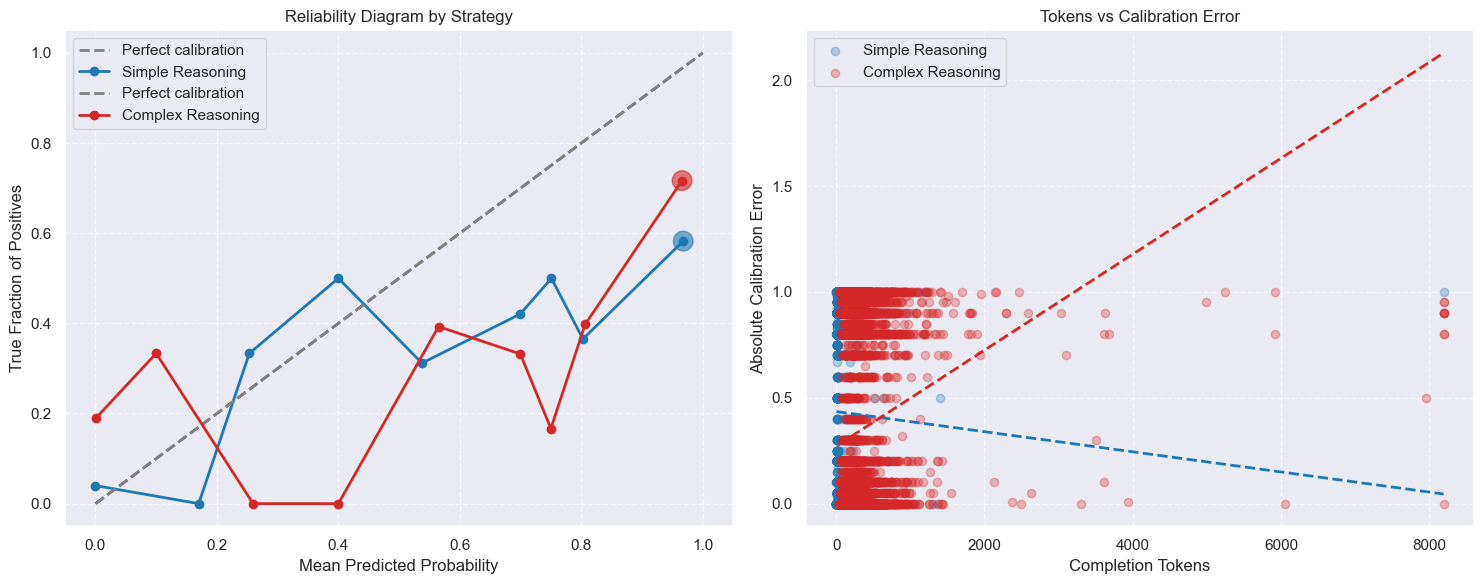

In [367]:
# Create reliability diagrams for different reasoning strategies
strategy_map = {
    'no_exp': 'Simple Reasoning', 
    'cot': 'Complex Reasoning',
}

# Combine all dataframes and add model identifier
combined_df = pd.concat([df.assign(model_id=name) for name, df in dfs.items()], ignore_index=True)

# Assign strategy to each row based on model_id
def get_strategy(model_id):
    for key, value in strategy_map.items():
        if key in model_id.lower():
            return value
    return 'Other'
    
combined_df['Strategy'] = combined_df['model_id'].apply(get_strategy)

# Filter for models with defined strategies
filtered_df = combined_df[combined_df['Strategy'] != 'Other'].copy()

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
strategies = ['Simple Reasoning', 'Complex Reasoning']
colors = ['#1f77b4', '#d62728']

# First subplot: Reliability diagram
for idx, strategy in enumerate(strategies):
    df_strat = filtered_df[filtered_df['Strategy'] == strategy]
    
    # Calculate reliability diagram data
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    bin_indices = np.digitize(df_strat['llm_confidence'], bin_edges) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins-1)
    
    mean_predicted_probs = np.zeros(n_bins)
    true_fractions = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)
    
    for i in range(n_bins):
        mask = bin_indices == i
        if np.any(mask):
            mean_predicted_probs[i] = df_strat['llm_confidence'][mask].mean()
            true_fractions[i] = df_strat['Correctness'][mask].mean()
            bin_counts[i] = np.sum(mask)
    
    # Sort points by predicted probability
    sort_idx = np.argsort(mean_predicted_probs)
    mean_predicted_probs = mean_predicted_probs[sort_idx]
    true_fractions = true_fractions[sort_idx]
    bin_counts = bin_counts[sort_idx]
    
    # Remove points with zero counts
    valid_points = bin_counts > 0
    mean_predicted_probs = mean_predicted_probs[valid_points]
    true_fractions = true_fractions[valid_points]
    bin_counts = bin_counts[valid_points]
    
    # Plot reliability diagram
    axes[0].plot([0, 1], [0, 1], '--', color='gray', label='Perfect calibration', linewidth=2)
    axes[0].scatter(mean_predicted_probs, true_fractions,
                   s=200*bin_counts/np.max(bin_counts),
                   color=colors[idx], alpha=0.6)
    axes[0].plot(mean_predicted_probs, true_fractions, '-o', 
                color=colors[idx], linewidth=2, label=strategy)

axes[0].set_title('Reliability Diagram by Strategy')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('True Fraction of Positives')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

# Second subplot: Tokens vs Calibration Error with trend lines
for idx, strategy in enumerate(strategies):
    df_strat = filtered_df[filtered_df['Strategy'] == strategy]
    
    # Plot scatter
    axes[1].scatter(df_strat['completion_tokens'], 
                   df_strat['abs_calibration_error'],
                   alpha=0.3, color=colors[idx], label=strategy)
    
    # Fit and plot trend line
    z = np.polyfit(df_strat['completion_tokens'], 
                   df_strat['abs_calibration_error'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(df_strat['completion_tokens'].min(),
                         df_strat['completion_tokens'].max(), 100)
    axes[1].plot(x_trend, p(x_trend), color=colors[idx], 
                 linestyle='--', linewidth=2)

axes[1].set_title('Tokens vs Calibration Error')
axes[1].set_xlabel('Completion Tokens')
axes[1].set_ylabel('Absolute Calibration Error')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.show()

In [364]:
combined_df['Strategy'].value_counts()

Strategy
Simple Reasoning    37616
Other               22549
Name: count, dtype: int64

# Impacts on Other Features

## 1: Reasoning Eliciation Methods


Complex Reasoning:
  Average Correctness: 0.782
  Average Tokens: 691.6

Simple Reasoning:
  Average Correctness: 0.679
  Average Tokens: 248.9


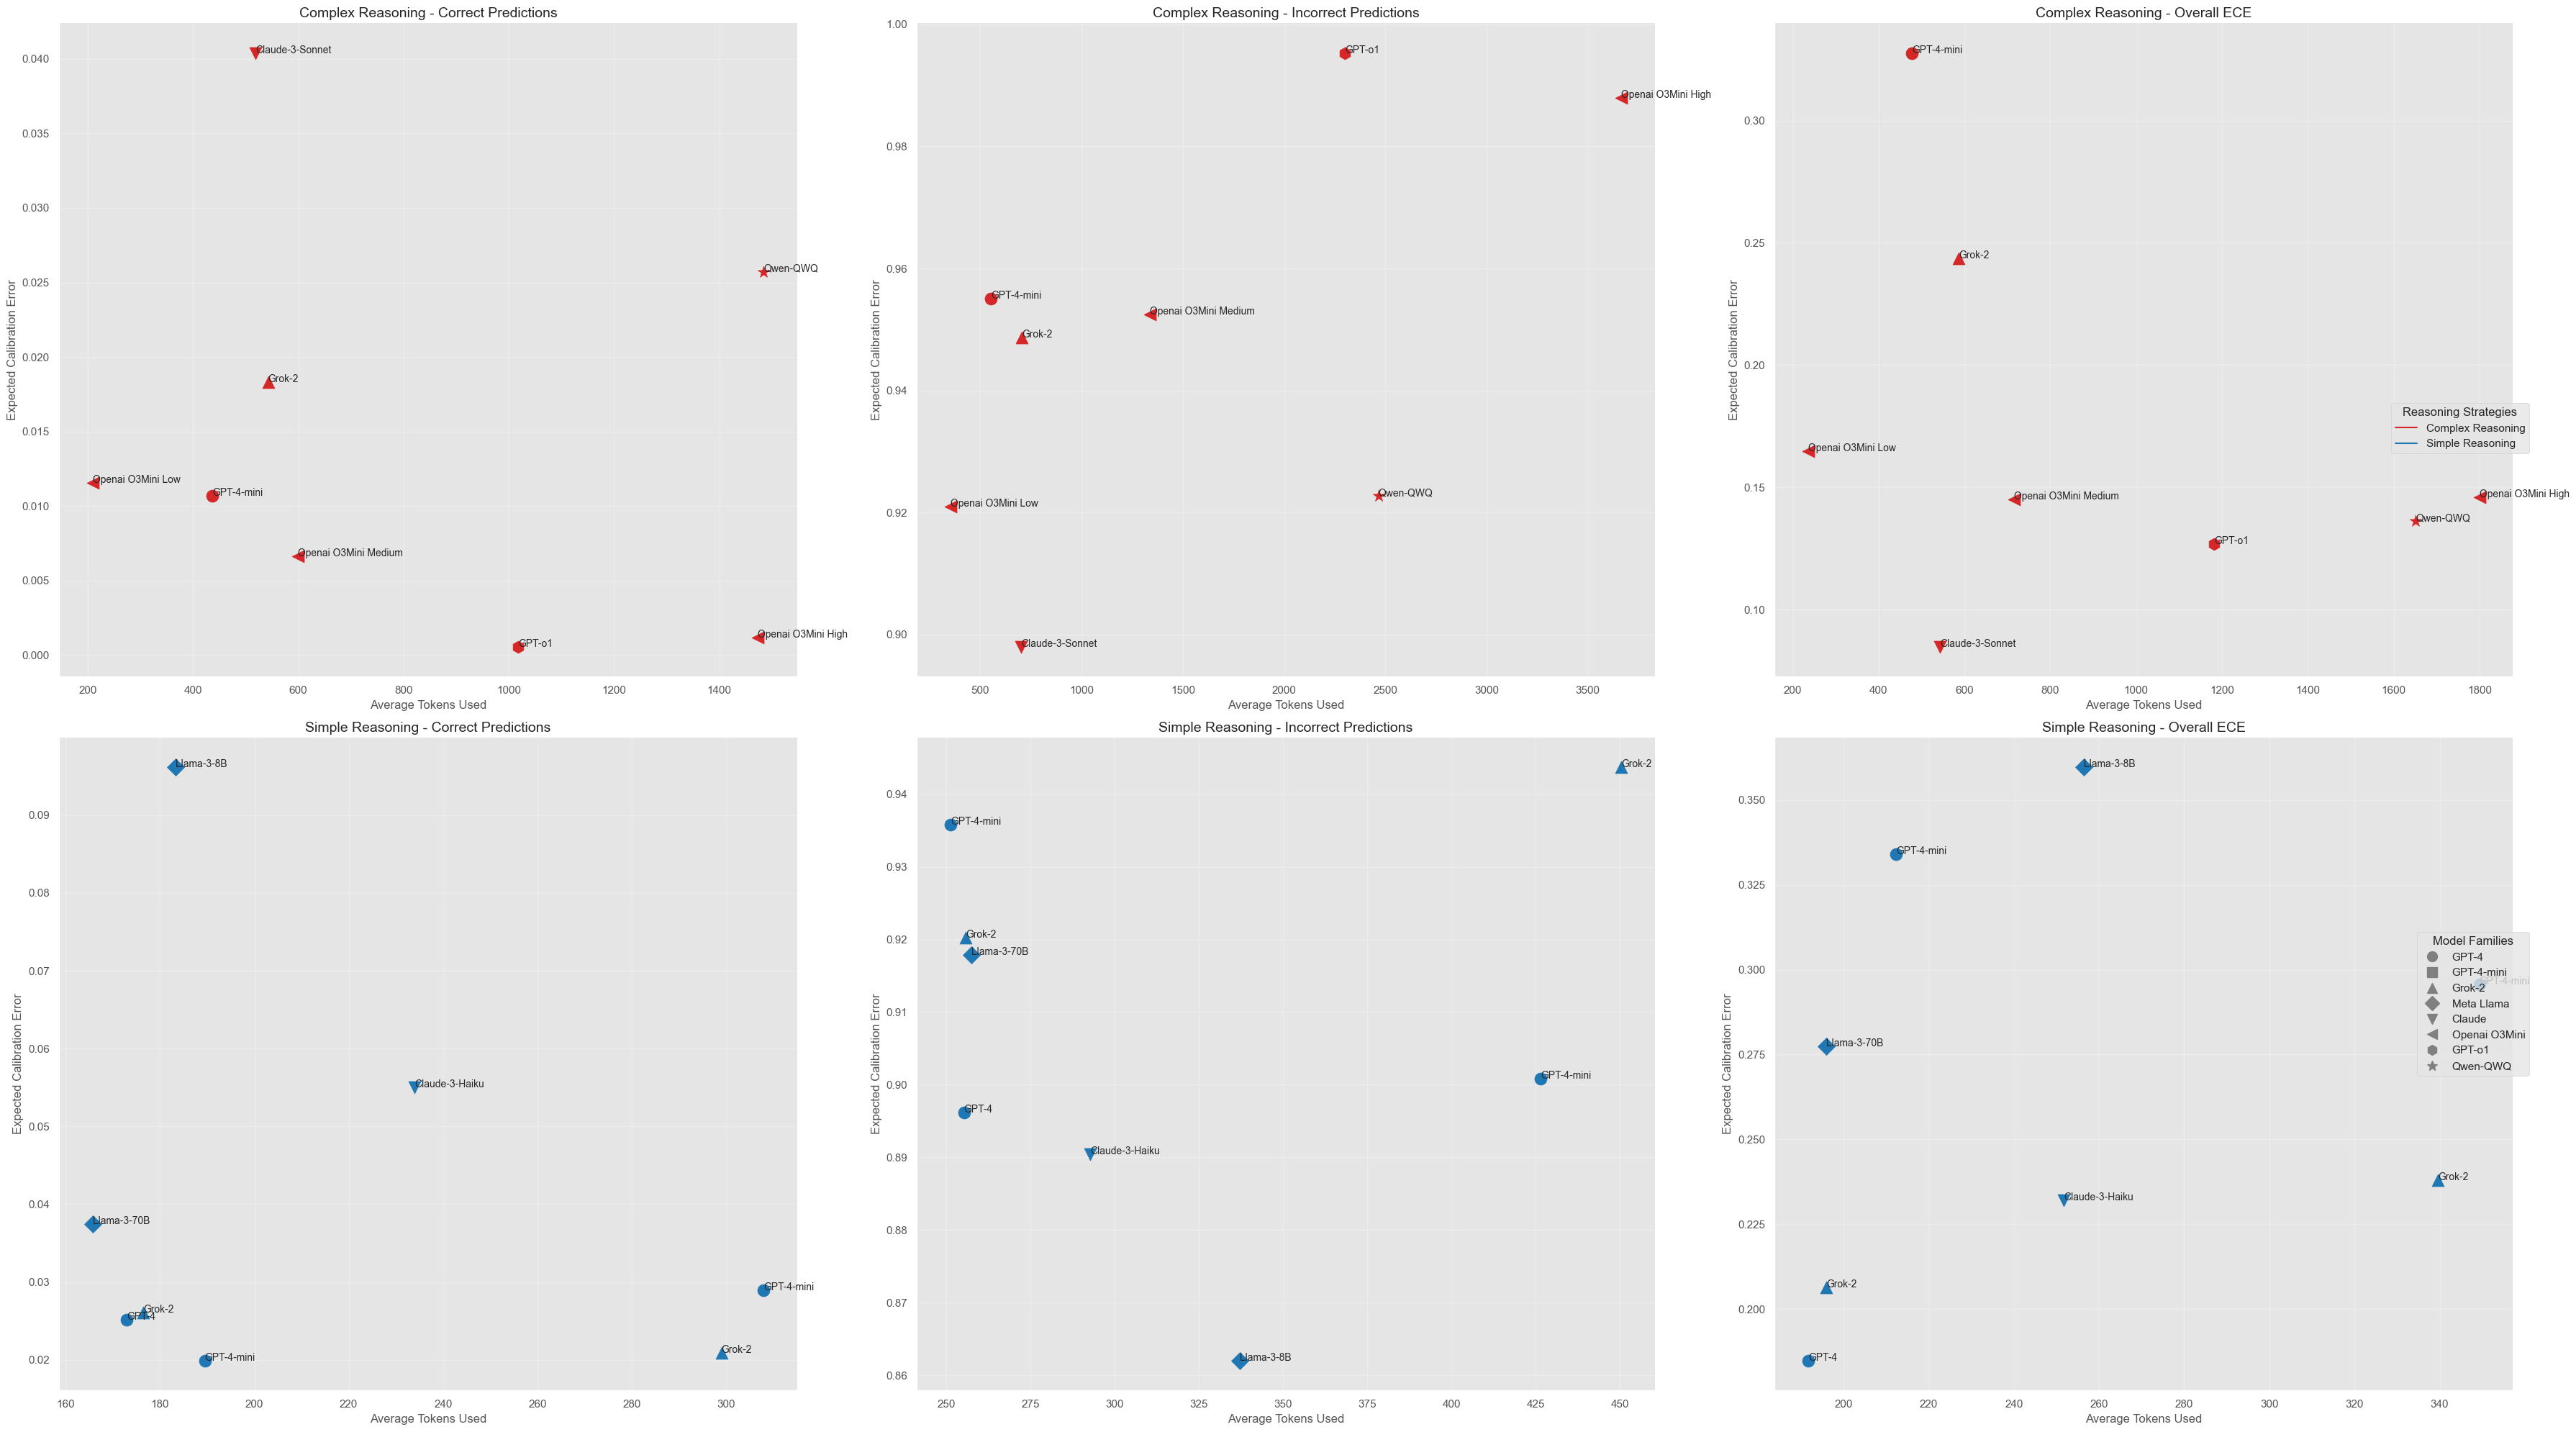

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_calibration_by_reasoning(dfs, names):
    """
    Analyze how token usage relates to calibration errors with distinct shapes and colors,
    split by reasoning strategy (Simple vs Complex Reasoning), with overall ECE plot.
    """
    # Reasoning strategy mapping
    strategy_map = {
        'reason': 'Complex Reasoning',
        'cot': 'Simple Reasoning', 
        'ltm': 'Simple Reasoning',
        'sc': 'Complex Reasoning'
    }
    
    # Combine all dataframes, add model identifier
    combined_df = pd.concat([df.assign(model_id=name) for name, df in dfs.items()], ignore_index=True)
    
    # Assign strategy to each row based on model_id
    def get_strategy(model_id):
        for key, value in strategy_map.items():
            if key in model_id.lower():
                return value
        return 'Other'
        
    combined_df['Strategy'] = combined_df['model_id'].apply(get_strategy)
    
    # Filter for models with defined strategies
    filtered_df = combined_df[combined_df['Strategy'] != 'Other'].copy()
    
    # Calculate and print average correctness for each strategy
    for strategy in sorted(filtered_df['Strategy'].unique()):
        df_strat = filtered_df[filtered_df['Strategy'] == strategy]
        if not df_strat.empty:
            avg_correct = df_strat['Correctness'].mean()
            avg_tokens = df_strat['completion_tokens'].mean()
            
            print(f"\n{strategy}:")
            print(f"  Average Correctness: {avg_correct:.3f}")
            print(f"  Average Tokens: {avg_tokens:.1f}")
    
    # Get unique strategies
    all_strategies = sorted(filtered_df['Strategy'].unique())
    n_strategies = len(all_strategies)

    # Create figure with subplots
    fig, axes = plt.subplots(n_strategies, 3, figsize=(36, 10*n_strategies))
    
    # Define colors and markers
    method_colors = {
        'Complex Reasoning': '#d62728',
        'Simple Reasoning': '#1f77b4'
    }
    
    model_markers = {
        'df_openai_4o': 'o',
        'df_openai_4omini': 's', 
        'df_xai_grok2': '^',
        'df_Meta_Llama': 'D',
        'df_claude': 'v',
        'df_openai_o3mini': '<',
        'df_openai_o1': 'h',
        'df_Qwen_QWQ': '*'
    }

    # Name mapping for better display
    name_mapping = {
        'df_openai_4o': 'GPT-4',
        'df_openai_4omini': 'GPT-4-mini',
        'df_xai_grok2': 'Grok-2',
        'df_Meta_Llama_3_1_8B_Instruct': 'Llama-3-8B',
        'df_claude_haiku': 'Claude-3-Haiku',
        'df_Meta_Llama_3_1_70B_Instruct': 'Llama-3-70B',
        'df_claude_sonnet_thinking': 'Claude-3-Sonnet',
        'df_openai_o1': 'GPT-o1',
        'df_Qwen_QWQ': 'Qwen-QWQ'
    }

    # For each strategy
    for strat_idx, strategy in enumerate(all_strategies):
        df_strat = filtered_df[filtered_df['Strategy'] == strategy]
        
        if not df_strat.empty:
            # Group by model_id to plot per model
            for model_id, group in df_strat.groupby('model_id'):
                df_clean = group.copy()
                df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
                
                if not df_clean.empty:
                    # Split by correctness
                    df_correct = df_clean[df_clean['Correctness'] == 1]
                    df_incorrect = df_clean[df_clean['Correctness'] == 0]
                    
                    # Get model family and display name
                    model_family = next((k for k in model_markers.keys() if k.lower() in model_id.lower()), 'Other')
                    base_name = model_id.replace('_reason', '').replace('_cot', '').replace('_ltm', '').replace('_sc', '')
                    display_name = name_mapping.get(base_name, base_name.replace('df_','').replace('_', ' ').title())
                    
                    # Plot points for correct/incorrect/overall
                    for idx, df_subset in enumerate([df_correct, df_incorrect, df_clean]):
                        if not df_subset.empty:
                            axes[strat_idx, idx].scatter(
                                df_subset['completion_tokens'].mean(),
                                compute_adaptive_ece(df_subset, n_bins=10),
                                marker=model_markers[model_family],
                                c=method_colors[strategy],
                                s=150,
                                label=display_name
                            )
                            axes[strat_idx, idx].text(
                                df_subset['completion_tokens'].mean(),
                                compute_adaptive_ece(df_subset, n_bins=10),
                                display_name,
                                fontsize=10
                            )

        # Customize each subplot
        axes[strat_idx, 0].set_title(f'{strategy} - Correct Predictions', fontsize=14)
        axes[strat_idx, 1].set_title(f'{strategy} - Incorrect Predictions', fontsize=14)
        axes[strat_idx, 2].set_title(f'{strategy} - Overall ECE', fontsize=14)
        
        for ax in axes[strat_idx]:
            ax.set_xlabel('Average Tokens Used', fontsize=12)
            ax.set_ylabel('Expected Calibration Error', fontsize=12)
            ax.grid(True, alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    # Add legends
    strategy_legend = [plt.Line2D([0], [0], color=color, label=strat,
                                 markersize=10, linestyle='-')
                      for strat, color in method_colors.items()]
    
    model_legend = [plt.Line2D([0], [0], marker=marker, color='gray',
                              label=name_mapping.get(family, family.replace('df_','').replace('_',' ').title()),
                              markersize=10, linestyle='None')
                   for family, marker in model_markers.items()]

    fig.legend(handles=strategy_legend, title='Reasoning Strategies',
              loc='center right', bbox_to_anchor=(0.98, 0.7))
    fig.legend(handles=model_legend, title='Model Families',
              loc='center right', bbox_to_anchor=(0.98, 0.3))

    plt.tight_layout()
    return fig

# Run the analysis
fig = analyze_calibration_by_reasoning(dfs, list(dfs.keys()))
plt.show()

## 2 Difficulty of Problems

In [585]:
# Create difficulty mapping
difficulty_map = {
    'BigBench_easy': 'Sci & Math',
    'BigBench_hard': 'Sci & Math', 
    'GPQA_main': 'Sci & Math',
    'MMLUPro_test': 'Sci & Math',
    'MMLU_test': 'Commonsense',
    'ProntoQA': 'Commonsense'
}

df_openai_4omini_cot['Reasoning_Type'] = 'Short CoT'
df_openai_4omini_no_exp['Reasoning_Type'] = 'No Reasoning'
df_openai_4omini_sc['Reasoning_Type'] = 'Long CoT'
openai_df = pd.concat([df_openai_4omini_cot, df_openai_4omini_no_exp, df_openai_4omini_sc])
openai_df['Task_Type'] = openai_df['Name'].map(difficulty_map)


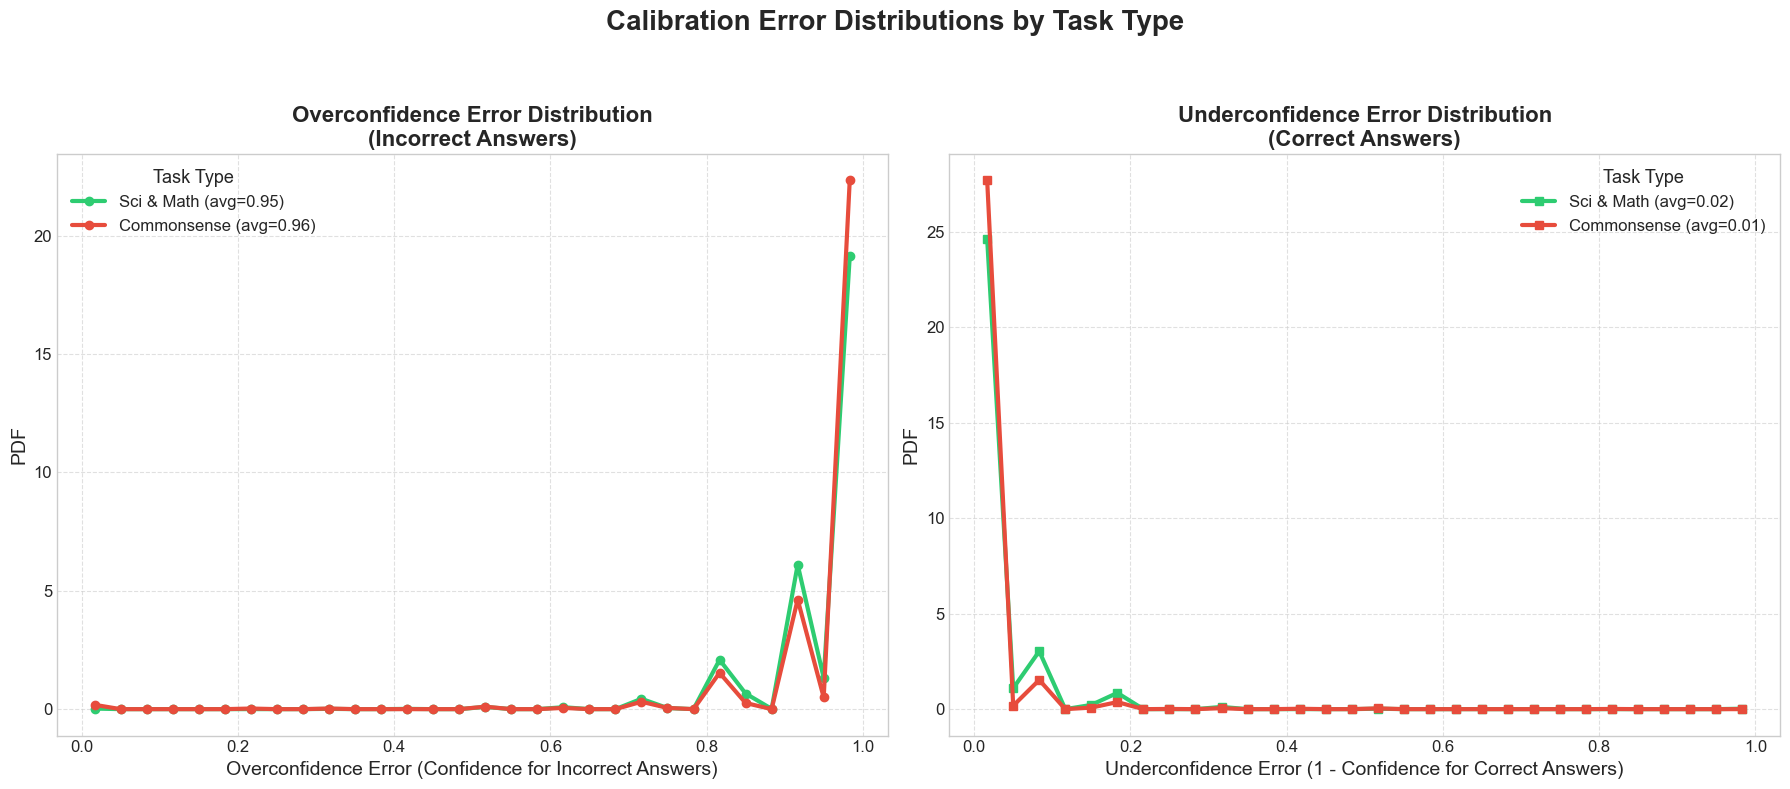

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (Assume openai_df is already defined as in your snippet:)
df_openai_4omini_cot['Reasoning_Type'] = 'Short CoT'
df_openai_4omini_no_exp['Reasoning_Type'] = 'No Reasoning'
df_openai_4omini_sc['Reasoning_Type'] = 'Long CoT'
openai_df = pd.concat([df_openai_4omini_cot, df_openai_4omini_no_exp, df_openai_4omini_sc])
openai_df['Task_Type'] = openai_df['Name'].map(difficulty_map)

# Ensure calibration error column exists
openai_df['confidence_error'] = abs(openai_df['Correctness'] - openai_df['llm_confidence'])
# For correct answers: Underconfidence Error = 1 - confidence.
openai_df.loc[openai_df['Correctness'] == 1, 'underconfidence_error'] = 1 - openai_df.loc[openai_df['Correctness'] == 1, 'llm_confidence']
# For incorrect answers: Overconfidence Error = confidence.
openai_df.loc[openai_df['Correctness'] == 0, 'overconfidence_error'] = openai_df.loc[openai_df['Correctness'] == 0, 'llm_confidence']

# Group by Task_Type
task_types = openai_df['Task_Type'].unique()

errors_incorrect = {}  # For incorrect answers: error = confidence.
errors_correct   = {}  # For correct answers: error = 1 - confidence.

for t in task_types:
    df_t = openai_df[openai_df['Task_Type'] == t]
    # For incorrect samples: error = confidence (target=0)
    incorr = df_t[df_t['Correctness'] == 0]['llm_confidence'].dropna().values
    # For correct samples: error = 1 - confidence (target=1)
    corr = 1 - df_t[df_t['Correctness'] == 1]['llm_confidence'].dropna().values
    errors_incorrect[t] = np.array(incorr)
    errors_correct[t] = np.array(corr)

def compute_density(errors, bins=30):
    """
    Compute a density estimate for a 1D array of error values.
    Returns bin centers and the density (normalized histogram).
    """
    hist, bin_edges = np.histogram(errors, bins=bins, range=(0, 1), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, hist

# Define colors for each task type.
color_map = {
    "Sci & Math": "#2ecc71",    # Green
    "Commonsense": "#e74c3c"    # Red
}

# Create a figure with two subplots side by side.
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Overconfidence Error Distribution for Incorrect Answers.
ax1 = axes[0]
for t, errs in errors_incorrect.items():
    if len(errs) == 0:
        continue
    x, density = compute_density(errs, bins=30)
    avg_err = np.mean(errs)
    label = f"{t} (avg={avg_err:.2f})"
    ax1.plot(x, density, label=label, lw=3, marker='o', markersize=6, color=color_map.get(t, 'black'))
ax1.set_xlabel("Overconfidence Error (Confidence for Incorrect Answers)", fontsize=14)
ax1.set_ylabel("PDF", fontsize=14)
ax1.set_title("Overconfidence Error Distribution\n(Incorrect Answers)", fontsize=16, fontweight='bold')
ax1.legend(title="Task Type", fontsize=12, title_fontsize=13)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.tick_params(labelsize=12)

# Plot 2: Underconfidence Error Distribution for Correct Answers.
ax2 = axes[1]
for t, errs in errors_correct.items():
    if len(errs) == 0:
        continue
    x, density = compute_density(errs, bins=30)
    avg_err = np.mean(errs)
    label = f"{t} (avg={avg_err:.2f})"
    ax2.plot(x, density, label=label, lw=3, marker='s', markersize=6, color=color_map.get(t, 'black'))
ax2.set_xlabel("Underconfidence Error (1 - Confidence for Correct Answers)", fontsize=14)
ax2.set_ylabel("PDF", fontsize=14)
ax2.set_title("Underconfidence Error Distribution\n(Correct Answers)", fontsize=16, fontweight='bold')
ax2.legend(title="Task Type", fontsize=12, title_fontsize=13)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.tick_params(labelsize=12)

fig.suptitle("Calibration Error Distributions by Task Type", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig('../calibration_error_distributions_by_task.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()



easy:
  Average Correctness: 0.772
  Average Tokens: 230.7

hard:
  Average Correctness: 0.549
  Average Tokens: 433.5


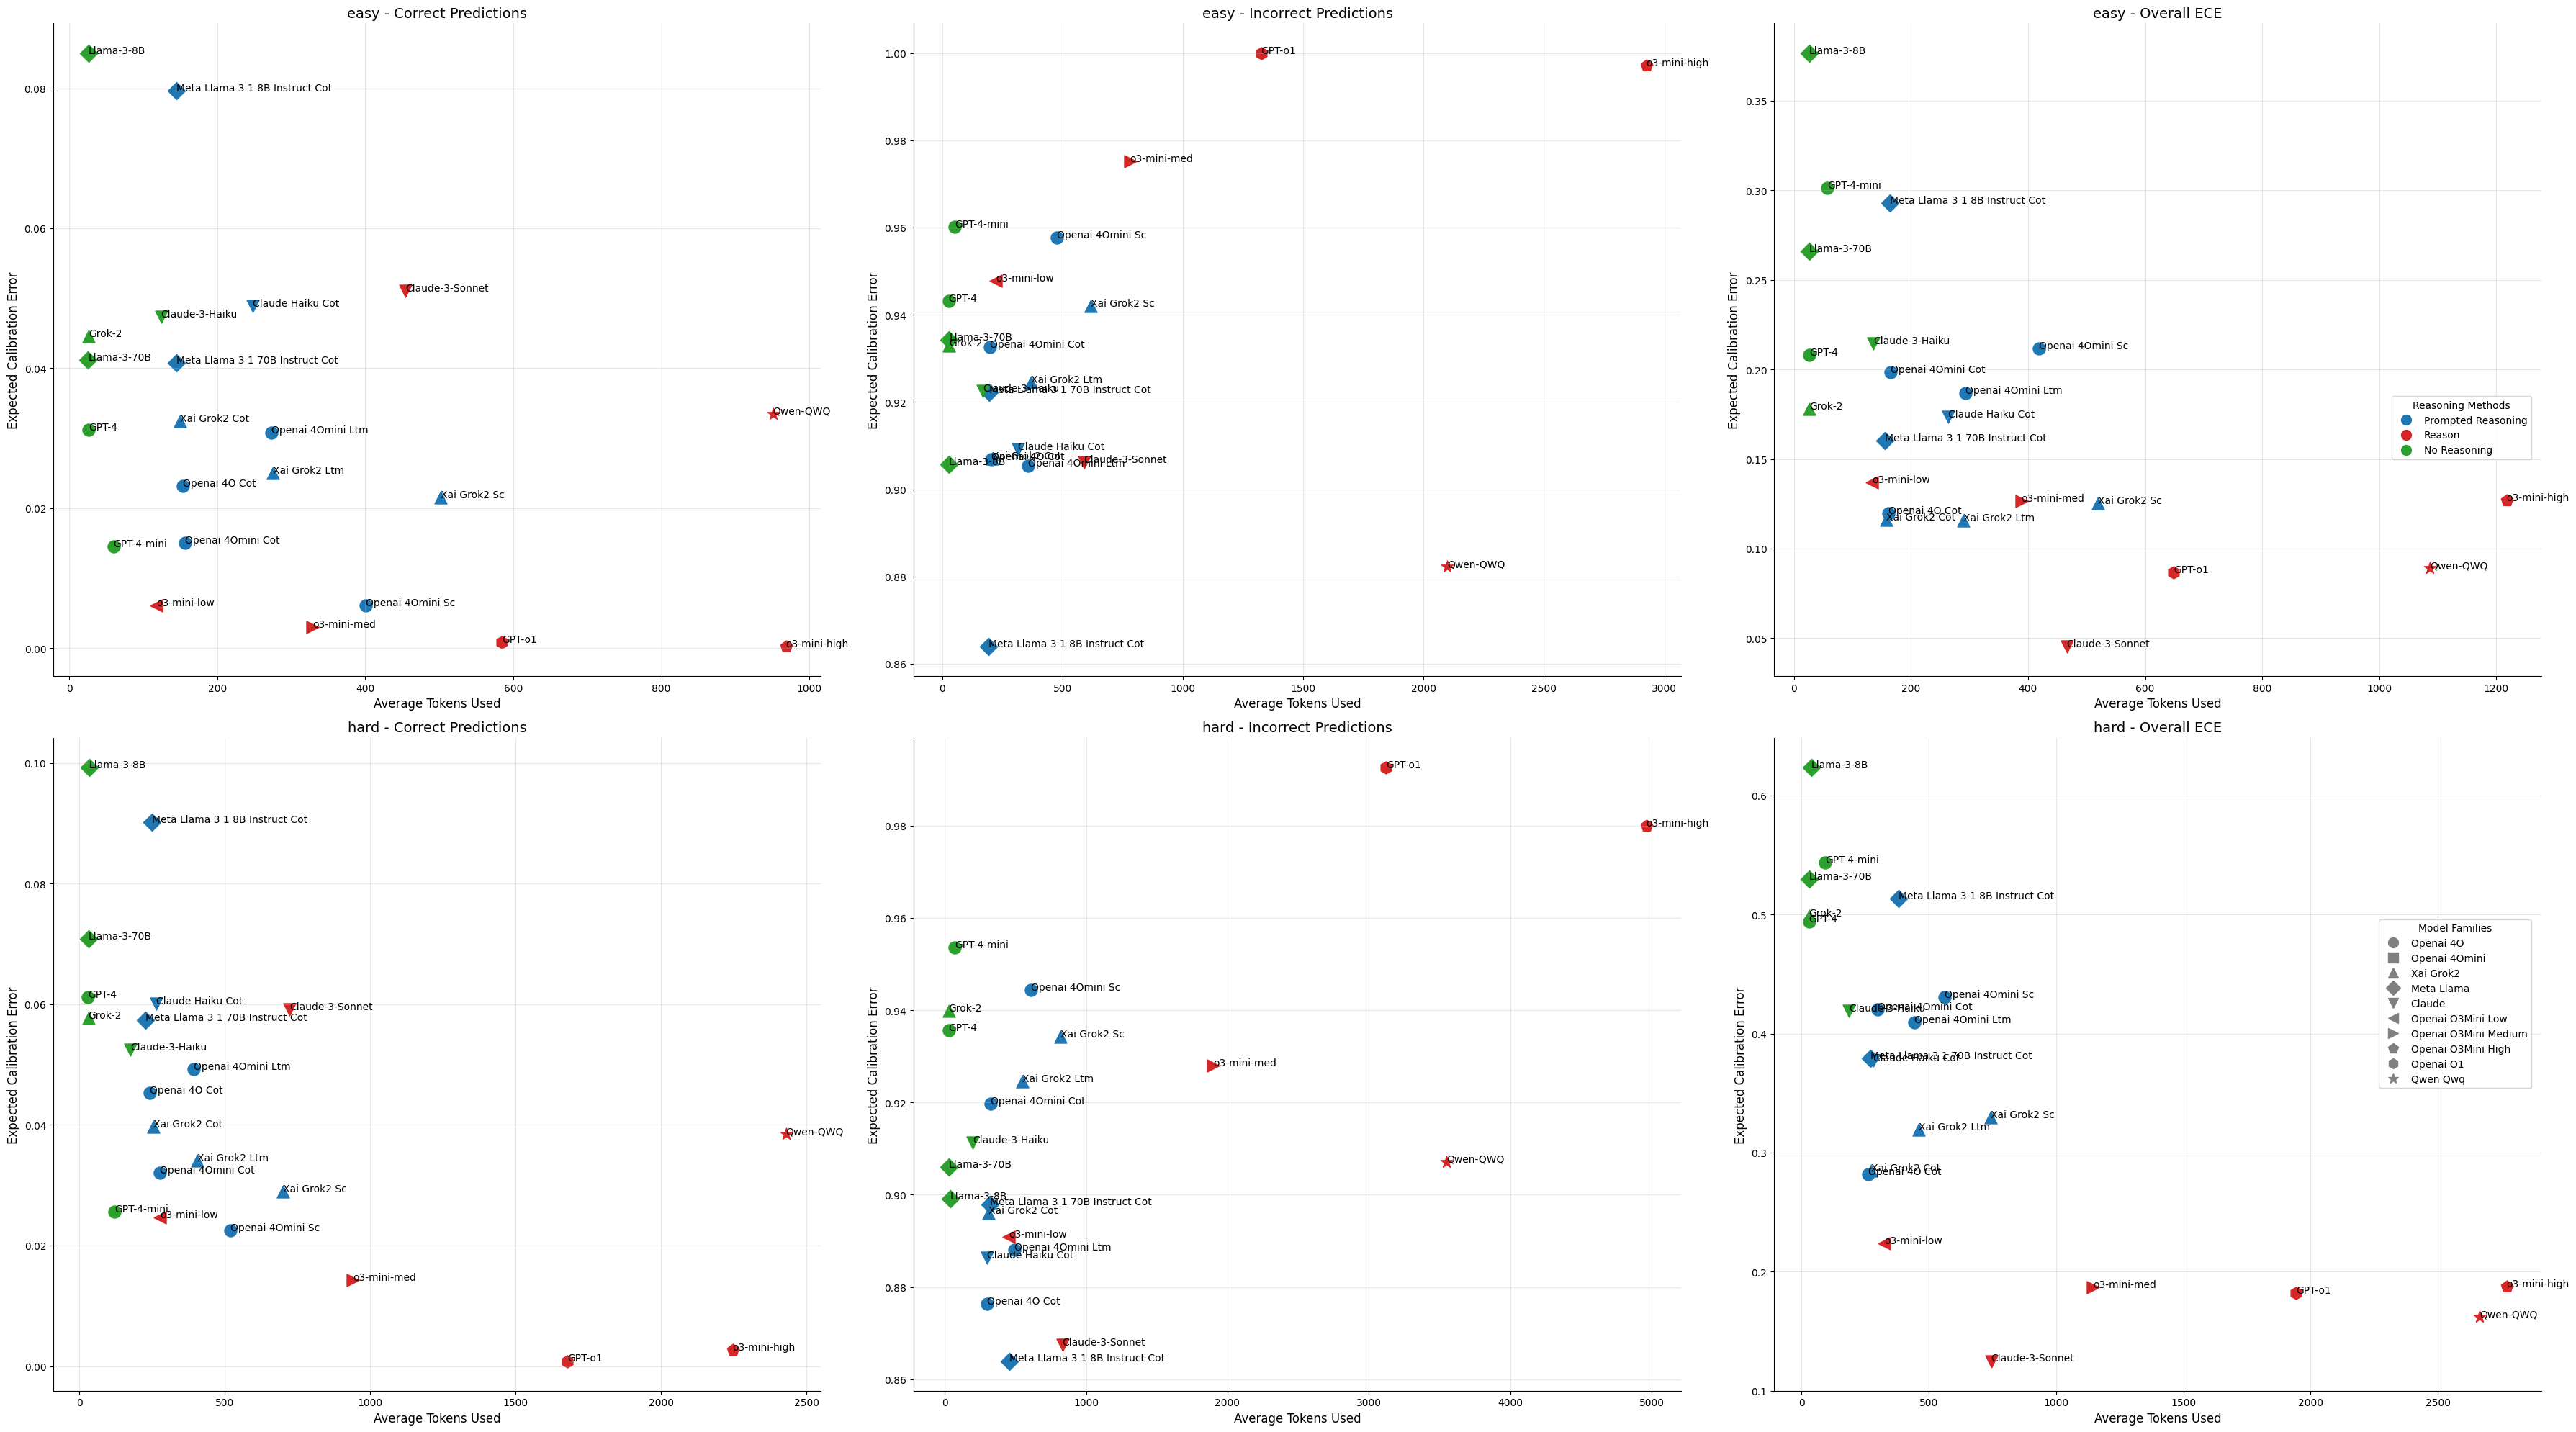

In [244]:
def analyze_calibration_difficulty_relationship(dfs, names):
    """
    Analyze how token usage relates to calibration errors with distinct shapes and colors,
    split by difficulty level (MMLU_test as easy, MMLUPro_test and GPQA_main as hard),
    with overall ECE plot. Prints average correctness for easy and hard difficulties.
    """
    # Difficulty mapping
    difficulty_map = {
        'MMLU_test': 'easy',
        'MMLUPro_test': 'hard',
        'GPQA_main': 'hard'
    }
    
    # Combine all dataframes, add model identifier, and filter rows
    combined_df = pd.concat([df.assign(model_id=name) for name, df in dfs.items()], ignore_index=True)
    filtered_df = combined_df[combined_df['Name'].isin(difficulty_map.keys())].copy()
    
    # Assign difficulty to each row
    filtered_df['Difficulty'] = filtered_df['Name'].map(difficulty_map)
    
    # Filter for models with reasoning based on model_id
    reasoning_models = [k for k in dfs.keys() if any(k.endswith(x) for x in ['_no_exp', '_reason', '_cot', '_ltm', '_sc'])]
    filtered_df = filtered_df[filtered_df['model_id'].isin(reasoning_models)]
    
    # Calculate and print average correctness for each difficulty
    for qtype in sorted(['easy', 'hard']):
        total_correct = 0
        total_count = 0
        total_tokens = 0
        
        # Use filtered_df instead of iterating through dfs
        df_type = filtered_df[filtered_df['Difficulty'] == qtype]
        if not df_type.empty:
            total_correct += df_type['Correctness'].sum()
            total_count += len(df_type)
            total_tokens += df_type['completion_tokens'].sum()
                
        if total_count > 0:
            avg_correct = total_correct / total_count
            avg_tokens = total_tokens / total_count
            
            print(f"\n{qtype}:")
            print(f"  Average Correctness: {avg_correct:.3f}")
            print(f"  Average Tokens: {avg_tokens:.1f}")
    
    # Get unique difficulties
    all_difficulties = sorted(filtered_df['Difficulty'].unique())
    n_difficulties = len(all_difficulties)

    # Create figure with subplots
    fig, axes = plt.subplots(n_difficulties, 3, figsize=(36, 10*n_difficulties))
    
    # Map model names to more readable format
    name_mapping = {
        'df_openai_4o': 'GPT-4',
        'df_openai_4omini': 'GPT-4-mini',
        'df_openai_o3mini_medium': 'o3-mini-med',
        'df_openai_o3mini_low': 'o3-mini-low', 
        'df_xai_grok2': 'Grok-2',
        'df_Meta_Llama_3_1_8B_Instruct': 'Llama-3-8B',
        'df_claude_haiku': 'Claude-3-Haiku',
        'df_Meta_Llama_3_1_70B_Instruct': 'Llama-3-70B',
        'df_claude_sonnet_thinking': 'Claude-3-Sonnet',
        'df_openai_o3mini_high': 'o3-mini-high',
        'df_openai_o1': 'GPT-o1',
        'df_Qwen_QWQ': 'Qwen-QWQ',
    }

    # Define colors and markers
    method_colors = {
        'prompted_reasoning': '#1f77b4',
        'reason': '#d62728', 
        'no_reasoning': '#2ca02c'
    }
    
    model_markers = {
        'df_openai_4o': 'o',
        'df_openai_4omini': 's',
        'df_xai_grok2': '^', 
        'df_Meta_Llama': 'D',
        'df_claude': 'v',
        'df_openai_o3mini_low': '<',
        'df_openai_o3mini_medium': '>',
        'df_openai_o3mini_high': 'p',
        'df_openai_o1': 'h',
        'df_Qwen_QWQ': '*',
    }

    # For each difficulty level
    for diff_idx, difficulty in enumerate(all_difficulties):
        df_diff = filtered_df[filtered_df['Difficulty'] == difficulty]
        
        if not df_diff.empty:
            # Group by model_id to plot per model
            for model_id, group in df_diff.groupby('model_id'):
                df_clean = group.copy()
                df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
                
                if not df_clean.empty:
                    # Split by correctness
                    df_correct = df_clean[df_clean['Correctness'] == 1]
                    df_incorrect = df_clean[df_clean['Correctness'] == 0]
                    
                    # Determine method type
                    if '_no_exp' in model_id:
                        method = 'no_reasoning'
                    elif '_reason' in model_id:
                        method = 'reason'
                    else:
                        method = 'prompted_reasoning'
                    
                    # Plot points for correct/incorrect
                    model_family = next((k for k in model_markers.keys() if k.lower() in model_id.lower()), 'Other')
                    base_name = model_id.replace('_no_exp', '').replace('_reason', '')
                    display_name = name_mapping.get(base_name, base_name.replace('df_','').replace('_', ' ').title())
                    
                    if not df_correct.empty:
                        axes[diff_idx, 0].scatter(
                            df_correct['completion_tokens'].mean(),
                            compute_adaptive_ece(df_correct, n_bins=10),
                            marker=model_markers[model_family],
                            c=method_colors[method],
                            s=150,
                            label=display_name
                        )
                        axes[diff_idx, 0].text(
                            df_correct['completion_tokens'].mean(),
                            compute_adaptive_ece(df_correct, n_bins=10),
                            display_name,
                            fontsize=10
                        )
                    
                    if not df_incorrect.empty:
                        axes[diff_idx, 1].scatter(
                            df_incorrect['completion_tokens'].mean(),
                            compute_adaptive_ece(df_incorrect, n_bins=10),
                            marker=model_markers[model_family],
                            c=method_colors[method],
                            s=150,
                            label=display_name
                        )
                        axes[diff_idx, 1].text(
                            df_incorrect['completion_tokens'].mean(),
                            compute_adaptive_ece(df_incorrect, n_bins=10),
                            display_name,
                            fontsize=10
                        )

                    # Plot overall ECE
                    avg_tokens = df_clean['completion_tokens'].mean()
                    avg_ece = compute_adaptive_ece(df_clean, n_bins=10)
                    axes[diff_idx, 2].scatter(
                        avg_tokens,
                        avg_ece,
                        marker=model_markers[model_family],
                        c=method_colors[method],
                        s=150,
                        label=display_name
                    )
                    axes[diff_idx, 2].text(
                        avg_tokens,
                        avg_ece,
                        display_name,
                        fontsize=10
                    )

        # Customize each subplot
        axes[diff_idx, 0].set_title(f'{difficulty} - Correct Predictions', fontsize=14)
        axes[diff_idx, 1].set_title(f'{difficulty} - Incorrect Predictions', fontsize=14)
        axes[diff_idx, 2].set_title(f'{difficulty} - Overall ECE', fontsize=14)
        
        for ax in axes[diff_idx]:
            ax.set_xlabel('Average Tokens Used', fontsize=12)
            ax.set_ylabel('Expected Calibration Error', fontsize=12)
            ax.grid(True, alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    # Add legends
    method_legend = [plt.Line2D([0], [0], marker='o', color=color, label=method.replace('_',' ').title(),
                               markersize=10, linestyle='None')
                    for method, color in method_colors.items()]
    
    model_legend = [plt.Line2D([0], [0], marker=marker, color='gray',
                              label=family.replace('df_','').replace('_',' ').title(),
                              markersize=10, linestyle='None')
                   for family, marker in model_markers.items()]

    fig.legend(handles=method_legend, title='Reasoning Methods',
              loc='center right', bbox_to_anchor=(0.98, 0.7))
    fig.legend(handles=model_legend, title='Model Families',
              loc='center right', bbox_to_anchor=(0.98, 0.3))

    plt.tight_layout()
    return fig

# Run the analysis
fig = analyze_calibration_difficulty_relationship(dfs, list(dfs.keys()))
plt.show()

## 3 Question Types


Statistics by Question Type:

Algorithmic:
  Average Correctness: 0.651
  Average Tokens: 365.4

Knowledge:
  Average Correctness: 0.690
  Average Tokens: 243.6


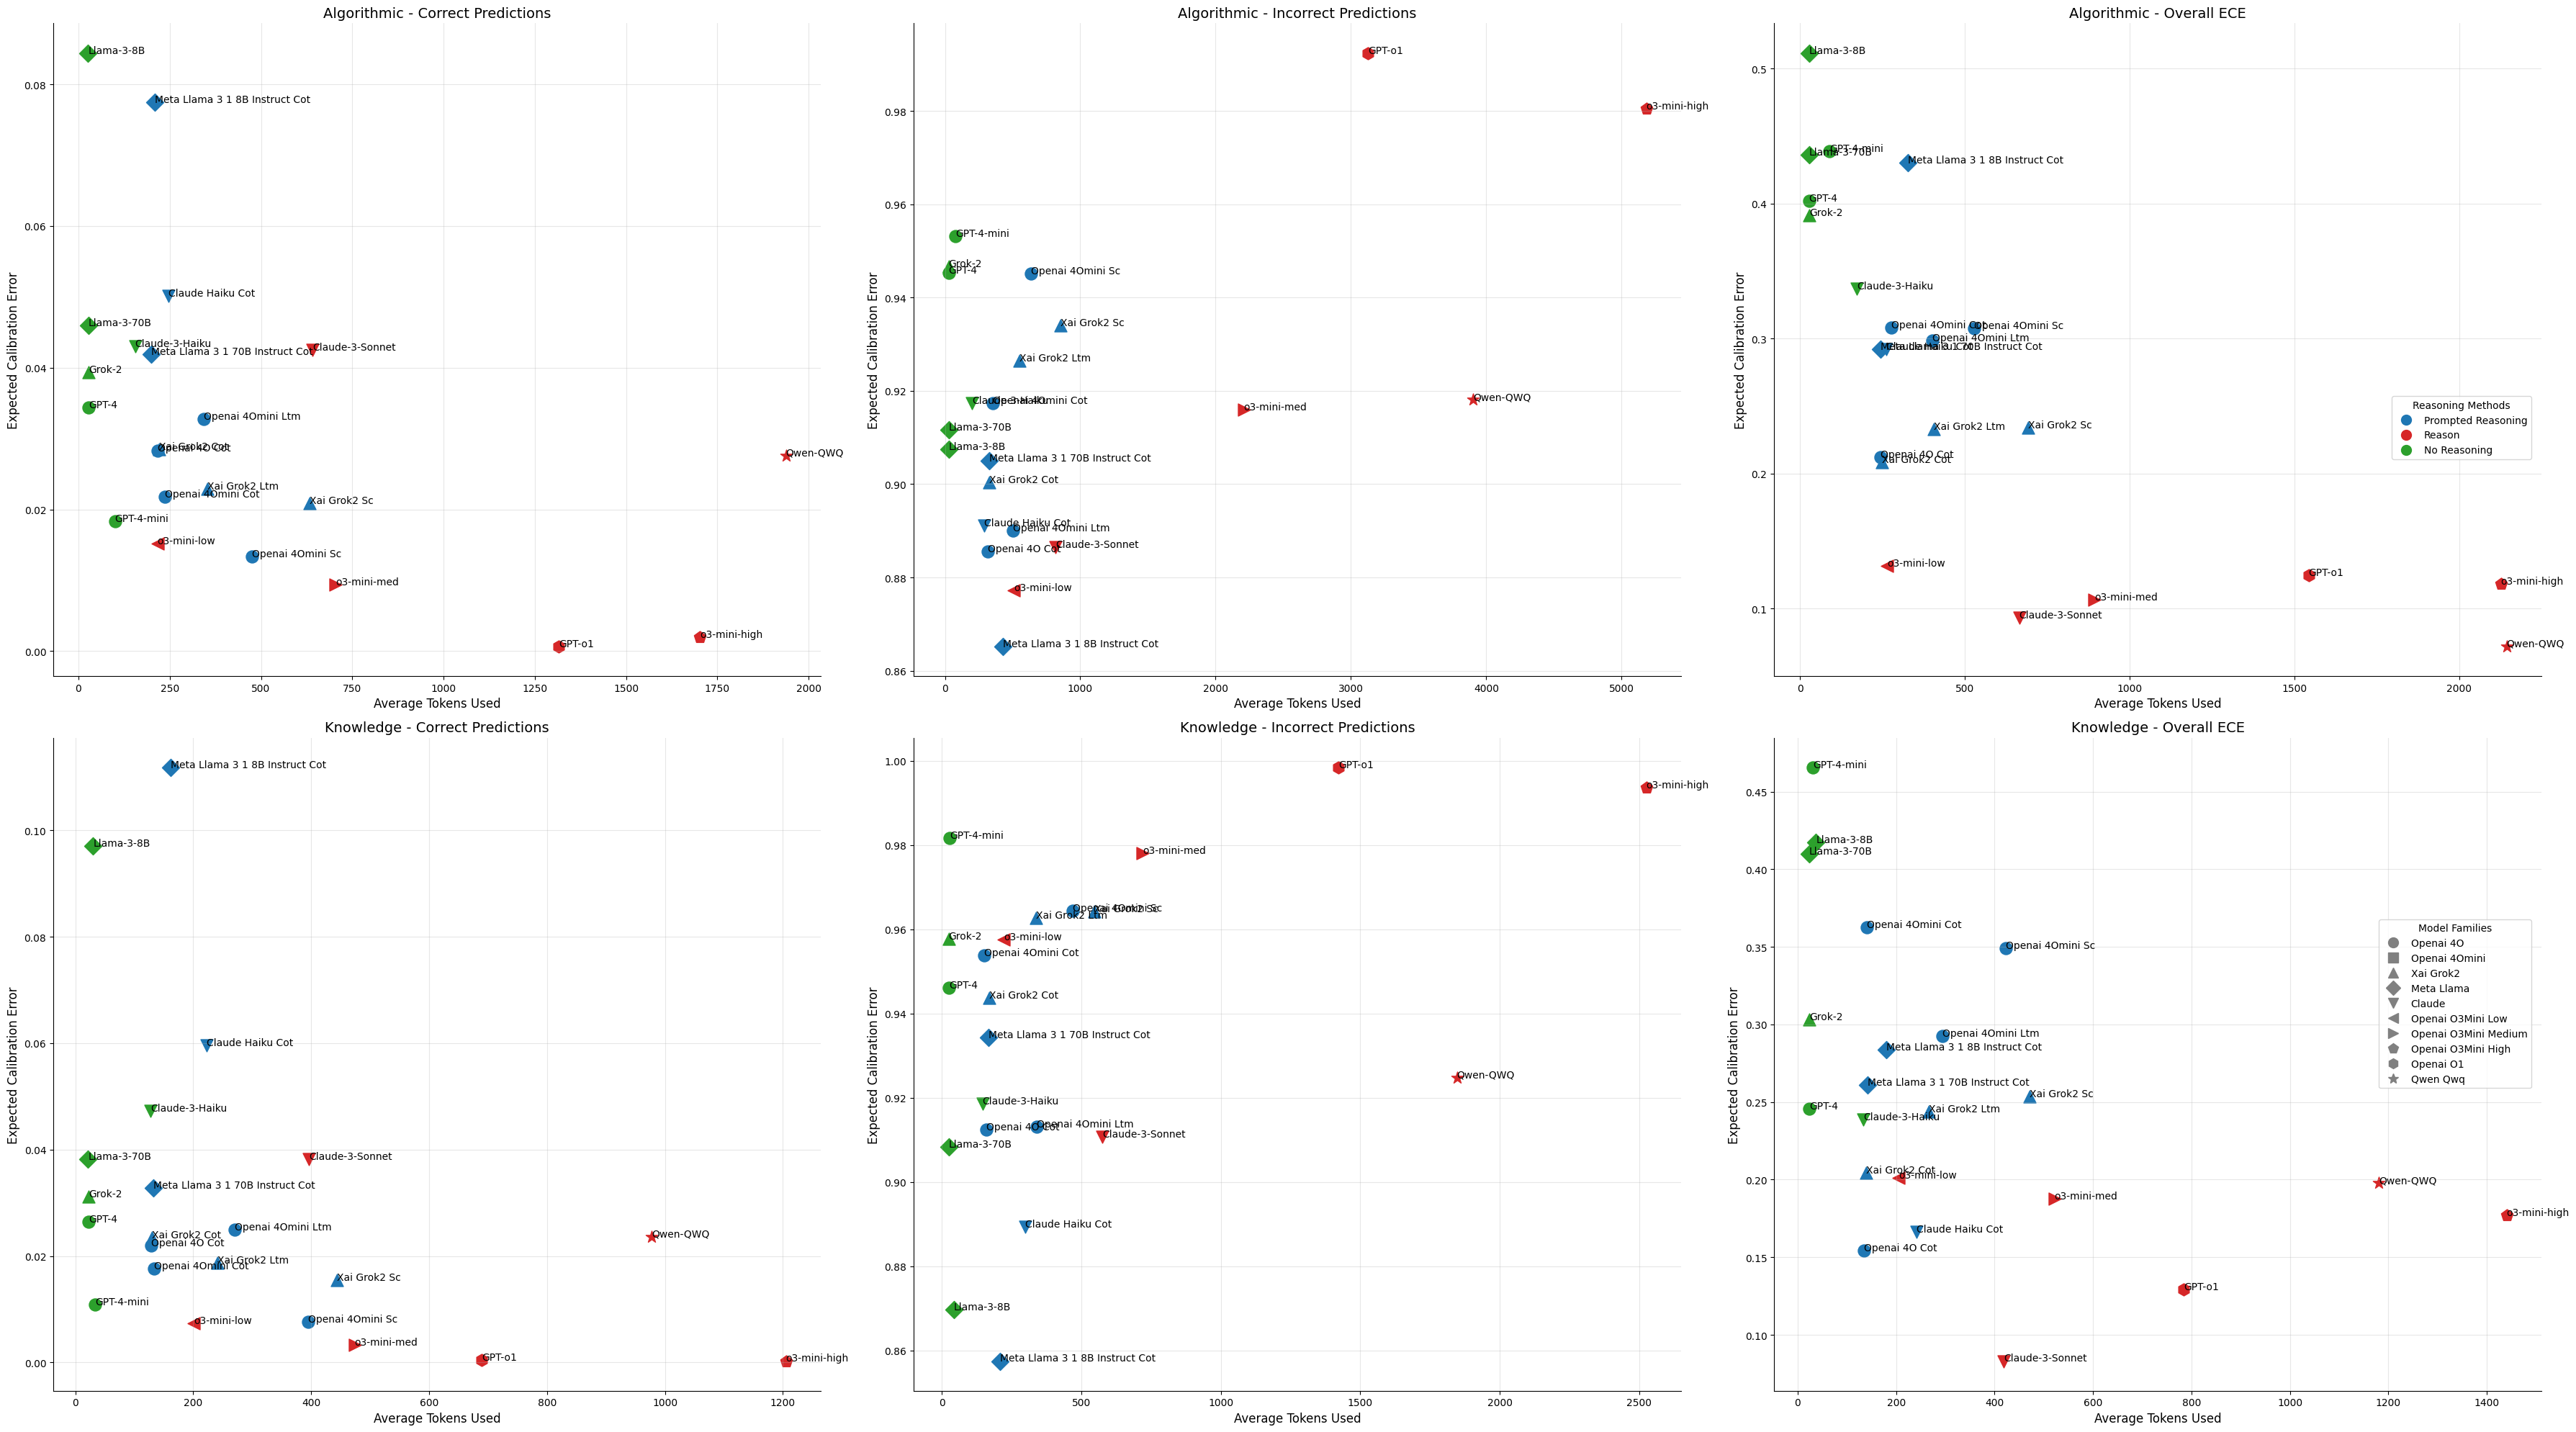

In [221]:
def analyze_calibration_token_relationship(dfs, names):
    """
    Analyze how token usage relates to calibration errors with distinct shapes and colors,
    split by question type and correctness status (correct vs incorrect), with overall ECE plot.
    """
    # Get all unique question types
    all_types = set()
    for df in dfs.values():
        df['Type'] = df['Type'].replace({
            'Knowledge': 'Knowledge', 
            'Logical': 'Knowledge',
            'Science': 'Algorithmic',
            'Math': 'Algorithmic',
            'Spatial': 'Knowledge'
        })
        all_types.update(df['Type'].unique())
    n_types = len(all_types)

    # Print average correctness and token usage for each question type
    print("\nStatistics by Question Type:")
    for qtype in sorted(all_types):
        total_correct = 0
        total_count = 0
        total_tokens = 0
        
        for df in dfs.values():
            df_type = df[df['Type'] == qtype]
            if not df_type.empty:
                total_correct += df_type['Correctness'].sum()
                total_count += len(df_type)
                total_tokens += df_type['completion_tokens'].sum()
                
        if total_count > 0:
            avg_correct = total_correct / total_count
            avg_tokens = total_tokens / total_count
            
            print(f"\n{qtype}:")
            print(f"  Average Correctness: {avg_correct:.3f}")
            print(f"  Average Tokens: {avg_tokens:.1f}")

    # Create figure with subplots - one row per type, three columns (correct/incorrect/overall)
    fig, axes = plt.subplots(n_types, 3, figsize=(36, 10*n_types))
    
    # Filter for models with reasoning
    reasoning_dfs = {k: v for k, v in dfs.items() if any(k.endswith(x) for x in ['_no_exp', '_reason', '_cot', '_ltm', '_sc'])}
    
    # Map model names to more readable format
    name_mapping = {
        'df_openai_4o': 'GPT-4',
        'df_openai_4omini': 'GPT-4-mini',
        'df_openai_o3mini_medium': 'o3-mini-med',
        'df_openai_o3mini_low': 'o3-mini-low', 
        'df_xai_grok2': 'Grok-2',
        'df_Meta_Llama_3_1_8B_Instruct': 'Llama-3-8B',
        'df_claude_haiku': 'Claude-3-Haiku',
        'df_Meta_Llama_3_1_70B_Instruct': 'Llama-3-70B',
        'df_claude_sonnet_thinking': 'Claude-3-Sonnet',
        'df_openai_o3mini_high': 'o3-mini-high',
        'df_openai_o1': 'GPT-o1',
        'df_Qwen_QWQ': 'Qwen-QWQ',
    }

    # Define colors and markers
    method_colors = {
        'prompted_reasoning': '#1f77b4',
        'reason': '#d62728', 
        'no_reasoning': '#2ca02c'
    }
    
    model_markers = {
        'df_openai_4o': 'o',
        'df_openai_4omini': 's',
        'df_xai_grok2': '^', 
        'df_Meta_Llama': 'D',
        'df_claude': 'v',
        'df_openai_o3mini_low': '<',
        'df_openai_o3mini_medium': '>',
        'df_openai_o3mini_high': 'p',
        'df_openai_o1': 'h',
        'df_Qwen_QWQ': '*',
    }

    # For each question type
    for type_idx, qtype in enumerate(sorted(all_types)):
        # Process each model for this type
        for df_name, df in reasoning_dfs.items():
            df_clean = df.copy()
            df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
            
            # Filter for this question type
            df_type = df_clean[df_clean['Type'] == qtype]
            
            if not df_type.empty:
                # Split by correctness
                df_correct = df_type[df_type['Correctness'] == 1]
                df_incorrect = df_type[df_type['Correctness'] == 0]
                
                # Determine method type
                if '_no_exp' in df_name:
                    method = 'no_reasoning'
                elif '_reason' in df_name:
                    method = 'reason'
                else:
                    method = 'prompted_reasoning'
                
                # Plot points for correct/incorrect
                model_family = next((k for k in model_markers.keys() if k.lower() in df_name.lower()), 'Other')
                base_name = df_name.replace('_no_exp', '').replace('_reason', '')
                display_name = name_mapping.get(base_name, base_name.replace('df_','').replace('_', ' ').title())
                
                if not df_correct.empty:
                    axes[type_idx, 0].scatter(
                        df_correct['completion_tokens'].mean(),
                        compute_adaptive_ece(df_correct, n_bins=10),
                        marker=model_markers[model_family],
                        c=method_colors[method],
                        s=150,
                        label=display_name
                    )
                    axes[type_idx, 0].text(
                        df_correct['completion_tokens'].mean(),
                        compute_adaptive_ece(df_correct, n_bins=10),
                        display_name,
                        fontsize=10
                    )
                
                if not df_incorrect.empty:
                    axes[type_idx, 1].scatter(
                        df_incorrect['completion_tokens'].mean(),
                        compute_adaptive_ece(df_incorrect, n_bins=10),
                        marker=model_markers[model_family],
                        c=method_colors[method],
                        s=150,
                        label=display_name
                    )
                    axes[type_idx, 1].text(
                        df_incorrect['completion_tokens'].mean(),
                        compute_adaptive_ece(df_incorrect, n_bins=10),
                        display_name,
                        fontsize=10
                    )

                # Plot overall ECE in third column
                avg_tokens = df_type['completion_tokens'].mean()
                avg_ece = compute_adaptive_ece(df_type, n_bins=10)
                axes[type_idx, 2].scatter(
                    avg_tokens,
                    avg_ece,
                    marker=model_markers[model_family],
                    c=method_colors[method],
                    s=150,
                    label=display_name
                )
                axes[type_idx, 2].text(
                    avg_tokens,
                    avg_ece,
                    display_name,
                    fontsize=10
                )

        # Customize each subplot
        axes[type_idx, 0].set_title(f'{qtype} - Correct Predictions', fontsize=14)
        axes[type_idx, 1].set_title(f'{qtype} - Incorrect Predictions', fontsize=14)
        axes[type_idx, 2].set_title(f'{qtype} - Overall ECE', fontsize=14)
        
        for ax in axes[type_idx]:
            ax.set_xlabel('Average Tokens Used', fontsize=12)
            ax.set_ylabel('Expected Calibration Error', fontsize=12)
            ax.grid(True, alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    # Add legends
    method_legend = [plt.Line2D([0], [0], marker='o', color=color, label=method.replace('_',' ').title(),
                               markersize=10, linestyle='None')
                    for method, color in method_colors.items()]
    
    model_legend = [plt.Line2D([0], [0], marker=marker, color='gray',
                              label=family.replace('df_','').replace('_',' ').title(),
                              markersize=10, linestyle='None')
                   for family, marker in model_markers.items()]

    fig.legend(handles=method_legend, title='Reasoning Methods',
              loc='center right', bbox_to_anchor=(0.98, 0.7))
    fig.legend(handles=model_legend, title='Model Families',
              loc='center right', bbox_to_anchor=(0.98, 0.3))

    plt.tight_layout()
    return fig

# Run the analysis
fig = analyze_calibration_token_relationship(dfs, list(dfs.keys()))
plt.show()

# Math/Logical Reasoning tends to be hard calibrations with more reasoning

## Prompting Frameing

In [400]:
import pandas as pd
import glob

# Get all CSV files in the Framing_Effects directory
files = glob.glob('data/Results/Framing_Effects/*.csv')

# Initialize empty list to store dataframes
dfs = []

for file in files:
    # Read the CSV
    df = pd.read_csv(file)
    
    # Extract model name from filename
    if 'grok2' in file:
        model = 'grok2'
    elif 'o3mini' in file:
        model = 'o3mini'
    elif '4omini' in file:
        model = 'gpt-4o'
    
    # Extract framing (good/bad)
    framing = 'Good' if 'good' in file else 'Bad'
    
    # Extract reasoning type
    if 'no_exp' in file:
        reasoning = 'no_reasoning'
    elif 'cot' in file:
        reasoning = 'cot'
    elif 'reason' in file:
        reasoning = 'reasoning'
        
    # Add new columns
    df['Model'] = model
    df['Framing'] = framing 
    df['Reasoning_Type'] = reasoning
    
    dfs.append(df)

# Combine all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

# Display first few rows to verify
print(combined_df[['Model', 'Framing', 'Reasoning_Type']].head())
print("\nTotal rows:", len(combined_df))


   Model Framing Reasoning_Type
0  grok2    Good   no_reasoning
1  grok2    Good   no_reasoning
2  grok2    Good   no_reasoning
3  grok2    Good   no_reasoning
4  grok2    Good   no_reasoning

Total rows: 10010


In [401]:
combined_df.groupby(['Model', 'Framing', 'Reasoning_Type'])['llm_confidence'].mean()

Model   Framing  Reasoning_Type
gpt-4o  Bad      cot               0.721079
                 no_reasoning      0.668382
        Good     cot               0.942312
                 no_reasoning      0.962607
grok2   Bad      cot               0.524276
                 no_reasoning      0.491508
        Good     cot               0.958422
                 no_reasoning      0.976194
o3mini  Bad      reasoning         0.832597
        Good     reasoning         0.995245
Name: llm_confidence, dtype: float64

In [402]:
# First evaluate correctness using the functions

def extract_complete_answer(row):
    """
    Extracts the complete answer from the question based on the correct answer letter.
    Handles both Yes/No answers and lettered options (A,B,C,etc).
    """
    question = str(row['Question'])
    correct_answer = str(row['Correct Answer']).strip()
    
    # Handle Yes/No answers
    if correct_answer in ['Yes', 'No']:
        return correct_answer
    
    # For lettered options
    try:
        # Split by either newline or comma
        if '\n' in question[-10:]:
            # Handle newline-separated options
            options = [opt.strip() for opt in question.split('\n') if opt.strip()]
            for opt in options:
                if opt.startswith(f"{correct_answer})") or opt.startswith(f"{correct_answer} )"):
                    return opt.strip()
        
        # Handle comma-separated options
        if 'options are:' in question.lower() or 'options:' in question.lower():
            # Find the options part
            options_part = question.split('options are:')[-1] if 'options are:' in question.lower() else question.split('options:')[-1]
            options = [opt.strip() for opt in options_part.split(',')]
            for opt in options:
                if opt.strip().startswith(f"{correct_answer})") or opt.strip().startswith(f"{correct_answer} )"):
                    return opt.strip()
        
        # If no match found, return original answer letter
        return correct_answer
        
    except Exception as e:
        print(f"Error processing question: {e}")
        return correct_answer

# Process confidence values
def process_confidence(df):
    # Convert confidence to numeric, coerce errors to NaN
    df['llm_confidence'] = pd.to_numeric(df['llm_confidence'], errors='coerce')
    
    # Handle non-numeric values
    non_numeric = df[df['llm_confidence'].isna()]
    for idx in non_numeric.index:
        val = str(df.loc[idx, 'llm_confidence'])
        # Try to extract float using regex
        match = re.search(r'-?\d+\.?\d*', val)
        if match:
            try:
                float_val = float(match.group())
                df.loc[idx, 'llm_confidence'] = float_val
            except:
                df.loc[idx, 'llm_confidence'] = -1
        else:
            df.loc[idx, 'llm_confidence'] = -1
            
    return df

def evaluate_llm_answers(df):
    """
    Evaluates LLM answers against correct answers and adds a Correctness column.
    1 = correct answer (matching first letter and answer is substring of complete answer)
    0 = incorrect answer
    -1 = format error
    
    Args:
        df: DataFrame containing 'llm_answer', 'Correct Answer', and 'complete_answer' columns
    
    Returns:
        DataFrame with new Correctness column and evaluation statistics
    """
    # Create Correctness column initialized with -1 (format error)
    df['Correctness'] = -1
    df['complete_answer'] = df.apply(extract_complete_answer, axis=1)
    stats = {
        'total': len(df),
        'correct': 0,
        'incorrect': 0,
        'format_errors': 0,
        'letter_match_only': 0,  # For debugging: cases where letter matches but content doesn't
    }
    
    valid_options = set('ABCDEFGHIJKNY')
    
    for idx, row in df.iterrows():
        llm_answer = str(row['llm_answer']).strip()
        correct_answer = str(row['Correct Answer']).strip()
        complete_answer = str(row['complete_answer']).strip()
        
        # Extract first letter from LLM answer
        first_letter = llm_answer[0] if llm_answer else ''
        
        # Check if first letter is a valid option
        if first_letter not in valid_options:
            stats['format_errors'] += 1
            
        # Check both conditions:
        # 1. First letter matches
        # 2. LLM answer is a substring of complete answer (case-insensitive)
        letter_matches = (first_letter == correct_answer)
        content_matches = (llm_answer.lower() in complete_answer.lower())
        
        if letter_matches:
            df.at[idx, 'Correctness'] = 1
            stats['correct'] += 1
        elif content_matches:
            df.at[idx, 'Correctness'] = 1
            stats['correct'] += 1
        else:
            df.at[idx, 'Correctness'] = 0
            stats['incorrect'] += 1
    
    # Calculate accuracy (excluding format errors)
    valid_answers = stats['total'] - stats['format_errors']
    accuracy = stats['correct'] / valid_answers if valid_answers > 0 else 0
    stats['accuracy'] = accuracy
    
    return df

# Process confidence values
combined_df = process_confidence(combined_df)
combined_df = evaluate_llm_answers(combined_df)

In [403]:
combined_df.groupby(['Model', 'Framing', 'Reasoning_Type'])['llm_confidence'].mean()

Model   Framing  Reasoning_Type
gpt-4o  Bad      cot               0.721079
                 no_reasoning      0.668382
        Good     cot               0.942312
                 no_reasoning      0.962607
grok2   Bad      cot               0.524276
                 no_reasoning      0.491508
        Good     cot               0.958422
                 no_reasoning      0.976194
o3mini  Bad      reasoning         0.832597
        Good     reasoning         0.995245
Name: llm_confidence, dtype: float64

In [404]:
combined_df.groupby(['Model', 'Framing', 'Reasoning_Type'])['Correctness'].mean()

Model   Framing  Reasoning_Type
gpt-4o  Bad      cot               0.598402
                 no_reasoning      0.522478
        Good     cot               0.643357
                 no_reasoning      0.560440
grok2   Bad      cot               0.690310
                 no_reasoning      0.566434
        Good     cot               0.772228
                 no_reasoning      0.609391
o3mini  Bad      reasoning         0.845155
        Good     reasoning         0.844156
Name: Correctness, dtype: float64

In [405]:
combined_df['completion_tokens'] = combined_df['token_usage'].apply(
    lambda x: eval(x)['completion_tokens'] if pd.notnull(x) else np.nan
)

In [406]:
combined_df.groupby(['Model', 'Framing', 'Reasoning_Type'])['completion_tokens'].mean()

Model   Framing  Reasoning_Type
gpt-4o  Bad      cot                206.517483
                 no_reasoning        55.267732
        Good     cot                259.414585
                 no_reasoning        95.916084
grok2   Bad      cot                198.000999
                 no_reasoning        25.678322
        Good     cot                461.151848
                 no_reasoning        26.049950
o3mini  Bad      reasoning          697.797203
        Good     reasoning         1007.321678
Name: completion_tokens, dtype: float64

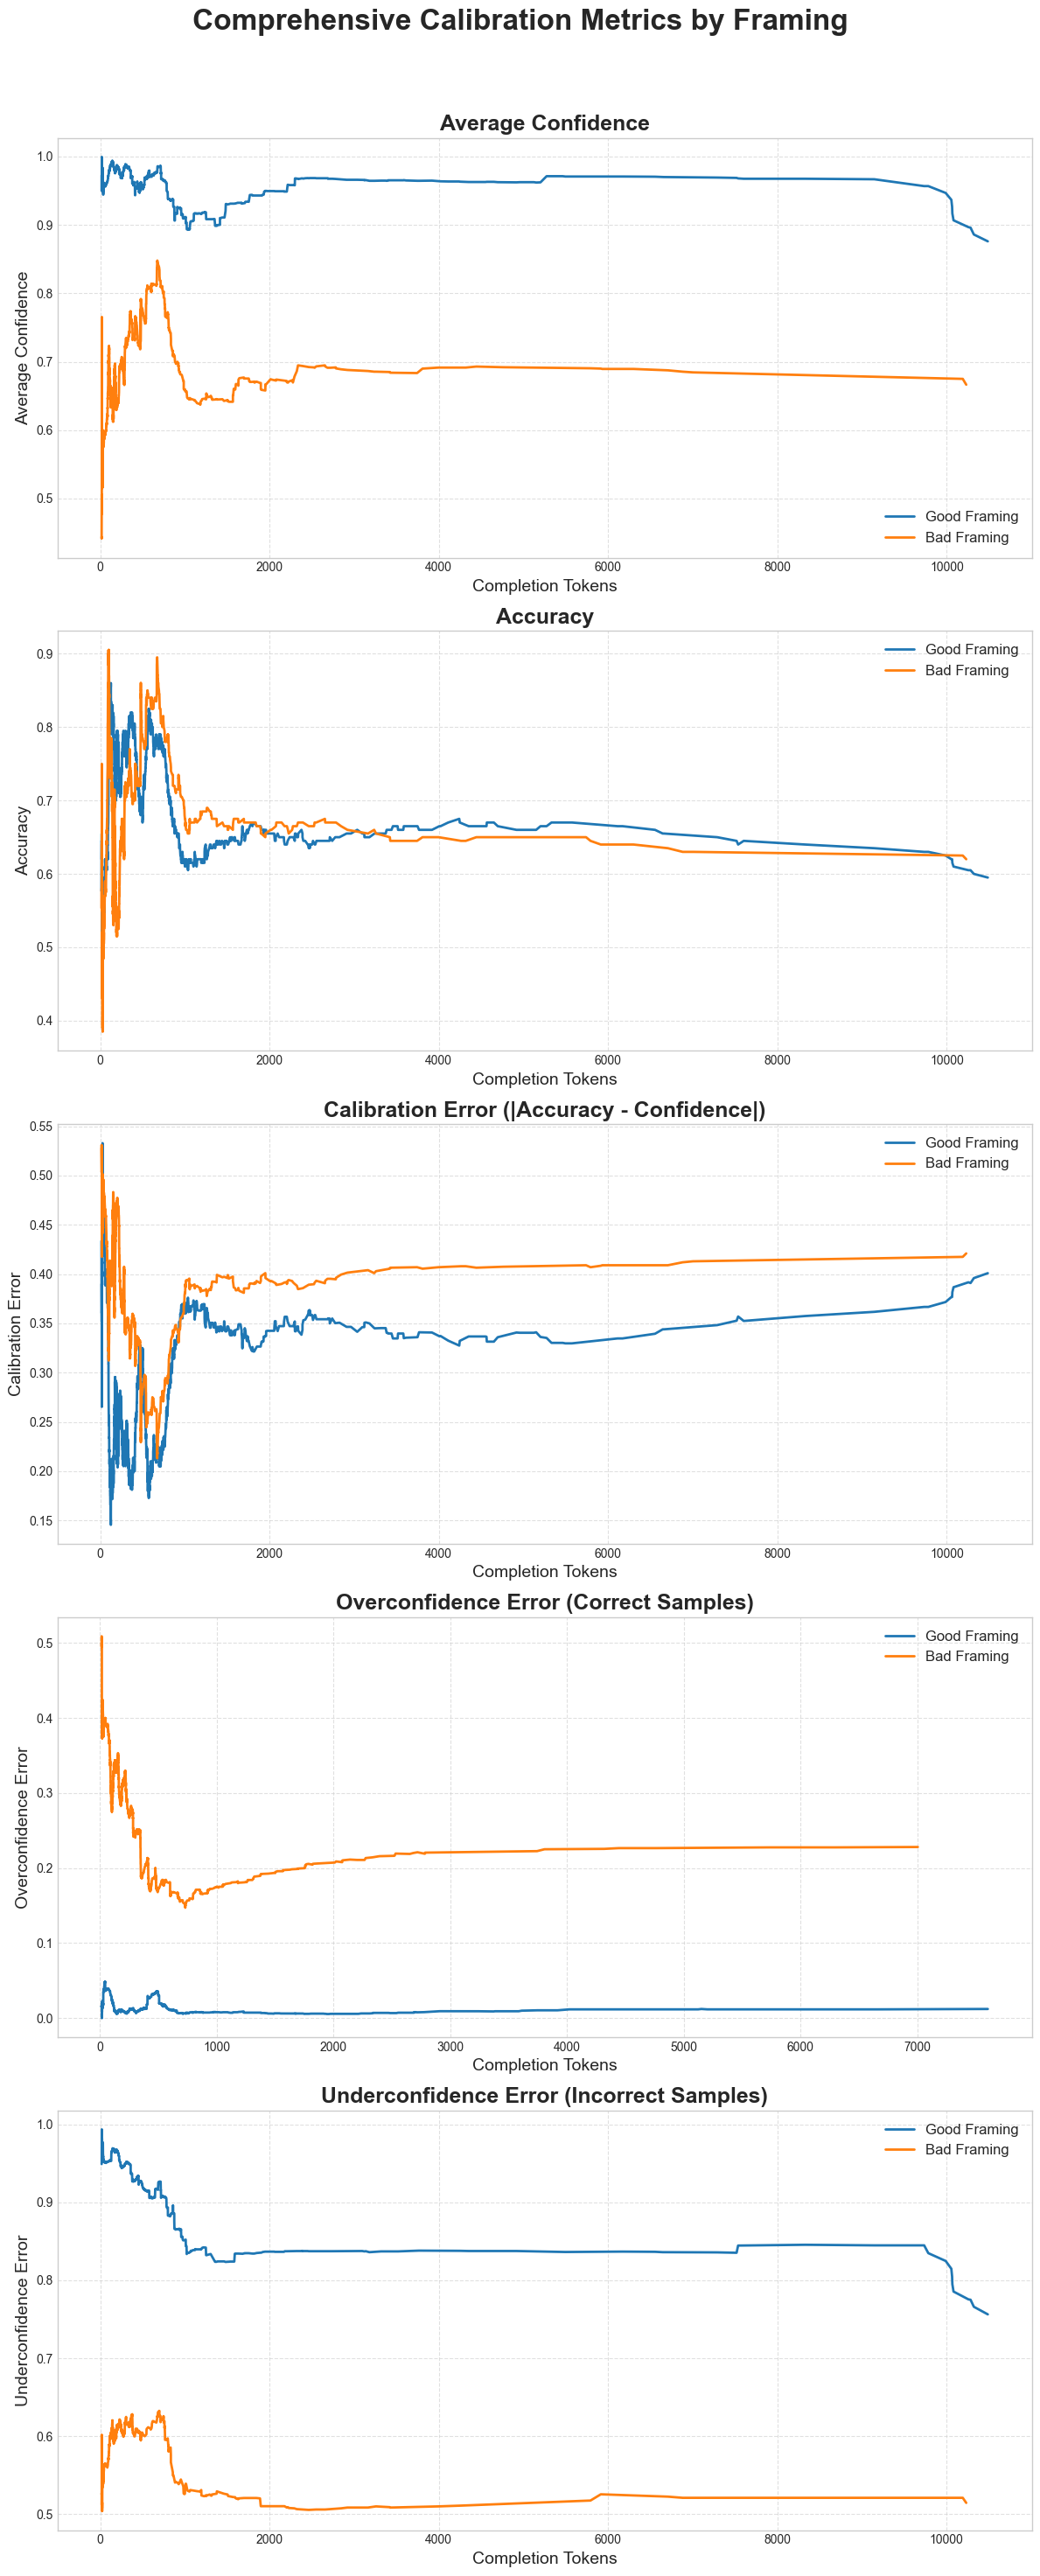

In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate calibration error column if not already calculated
combined_df['confidence_error'] = abs(combined_df['Correctness'] - combined_df['llm_confidence'])

# Define rolling window parameters
window_size = 200
min_periods = 50

# Get unique framings
framings = combined_df['Framing'].unique()

# Create figure with 5 subplots in one column
fig, axes = plt.subplots(5, 1, figsize=(12, 30))
fig.suptitle('Comprehensive Calibration Metrics by Framing', fontsize=24, fontweight='bold')

# 1. Average Confidence vs Completion Tokens
for framing in framings:
    df_framing = combined_df[combined_df['Framing'] == framing]
    df_sorted = df_framing.sort_values('completion_tokens')
    roll_conf = df_sorted['llm_confidence'].rolling(window=window_size, min_periods=min_periods).mean()
    axes[0].plot(df_sorted['completion_tokens'], roll_conf, label=f'{framing} Framing', lw=2)
axes[0].set_title('Average Confidence', fontsize=18, fontweight='bold')
axes[0].set_xlabel('Completion Tokens', fontsize=14)
axes[0].set_ylabel('Average Confidence', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# 2. Accuracy vs Completion Tokens
for framing in framings:
    df_framing = combined_df[combined_df['Framing'] == framing]
    df_sorted = df_framing.sort_values('completion_tokens')
    roll_acc = df_sorted['Correctness'].rolling(window=window_size, min_periods=min_periods).mean()
    axes[1].plot(df_sorted['completion_tokens'], roll_acc, label=f'{framing} Framing', lw=2)
axes[1].set_title('Accuracy', fontsize=18, fontweight='bold')
axes[1].set_xlabel('Completion Tokens', fontsize=14)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# 3. Calibration Error vs Completion Tokens
for framing in framings:
    df_framing = combined_df[combined_df['Framing'] == framing]
    df_sorted = df_framing.sort_values('completion_tokens')
    roll_err = df_sorted['confidence_error'].rolling(window=window_size, min_periods=min_periods).mean()
    axes[2].plot(df_sorted['completion_tokens'], roll_err, label=f'{framing} Framing', lw=2)
axes[2].set_title('Calibration Error (|Accuracy - Confidence|)', fontsize=18, fontweight='bold')
axes[2].set_xlabel('Completion Tokens', fontsize=14)
axes[2].set_ylabel('Calibration Error', fontsize=14)
axes[2].legend(fontsize=12)
axes[2].grid(True, linestyle='--', alpha=0.6)

# 4. Overconfidence Error vs Completion Tokens (Correct Samples Only)
for framing in framings:
    df_framing = combined_df[(combined_df['Framing'] == framing) & (combined_df['Correctness'] == 1)]
    df_sorted = df_framing.sort_values('completion_tokens')
    # For correct answers, overconfidence error = 1 - confidence.
    roll_over = (1 - df_sorted['llm_confidence']).rolling(window=window_size, min_periods=min_periods).mean()
    axes[3].plot(df_sorted['completion_tokens'], roll_over, label=f'{framing} Framing', lw=2)
axes[3].set_title('Overconfidence Error (Correct Samples)', fontsize=18, fontweight='bold')
axes[3].set_xlabel('Completion Tokens', fontsize=14)
axes[3].set_ylabel('Overconfidence Error', fontsize=14)
axes[3].legend(fontsize=12)
axes[3].grid(True, linestyle='--', alpha=0.6)

# 5. Underconfidence Error vs Completion Tokens (Incorrect Samples Only)
for framing in framings:
    df_framing = combined_df[(combined_df['Framing'] == framing) & (combined_df['Correctness'] == 0)]
    df_sorted = df_framing.sort_values('completion_tokens')
    # For incorrect answers, underconfidence error = confidence.
    roll_under = df_sorted['llm_confidence'].rolling(window=window_size, min_periods=min_periods).mean()
    axes[4].plot(df_sorted['completion_tokens'], roll_under, label=f'{framing} Framing', lw=2)
axes[4].set_title('Underconfidence Error (Incorrect Samples)', fontsize=18, fontweight='bold')
axes[4].set_xlabel('Completion Tokens', fontsize=14)
axes[4].set_ylabel('Underconfidence Error', fontsize=14)
axes[4].legend(fontsize=12)
axes[4].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


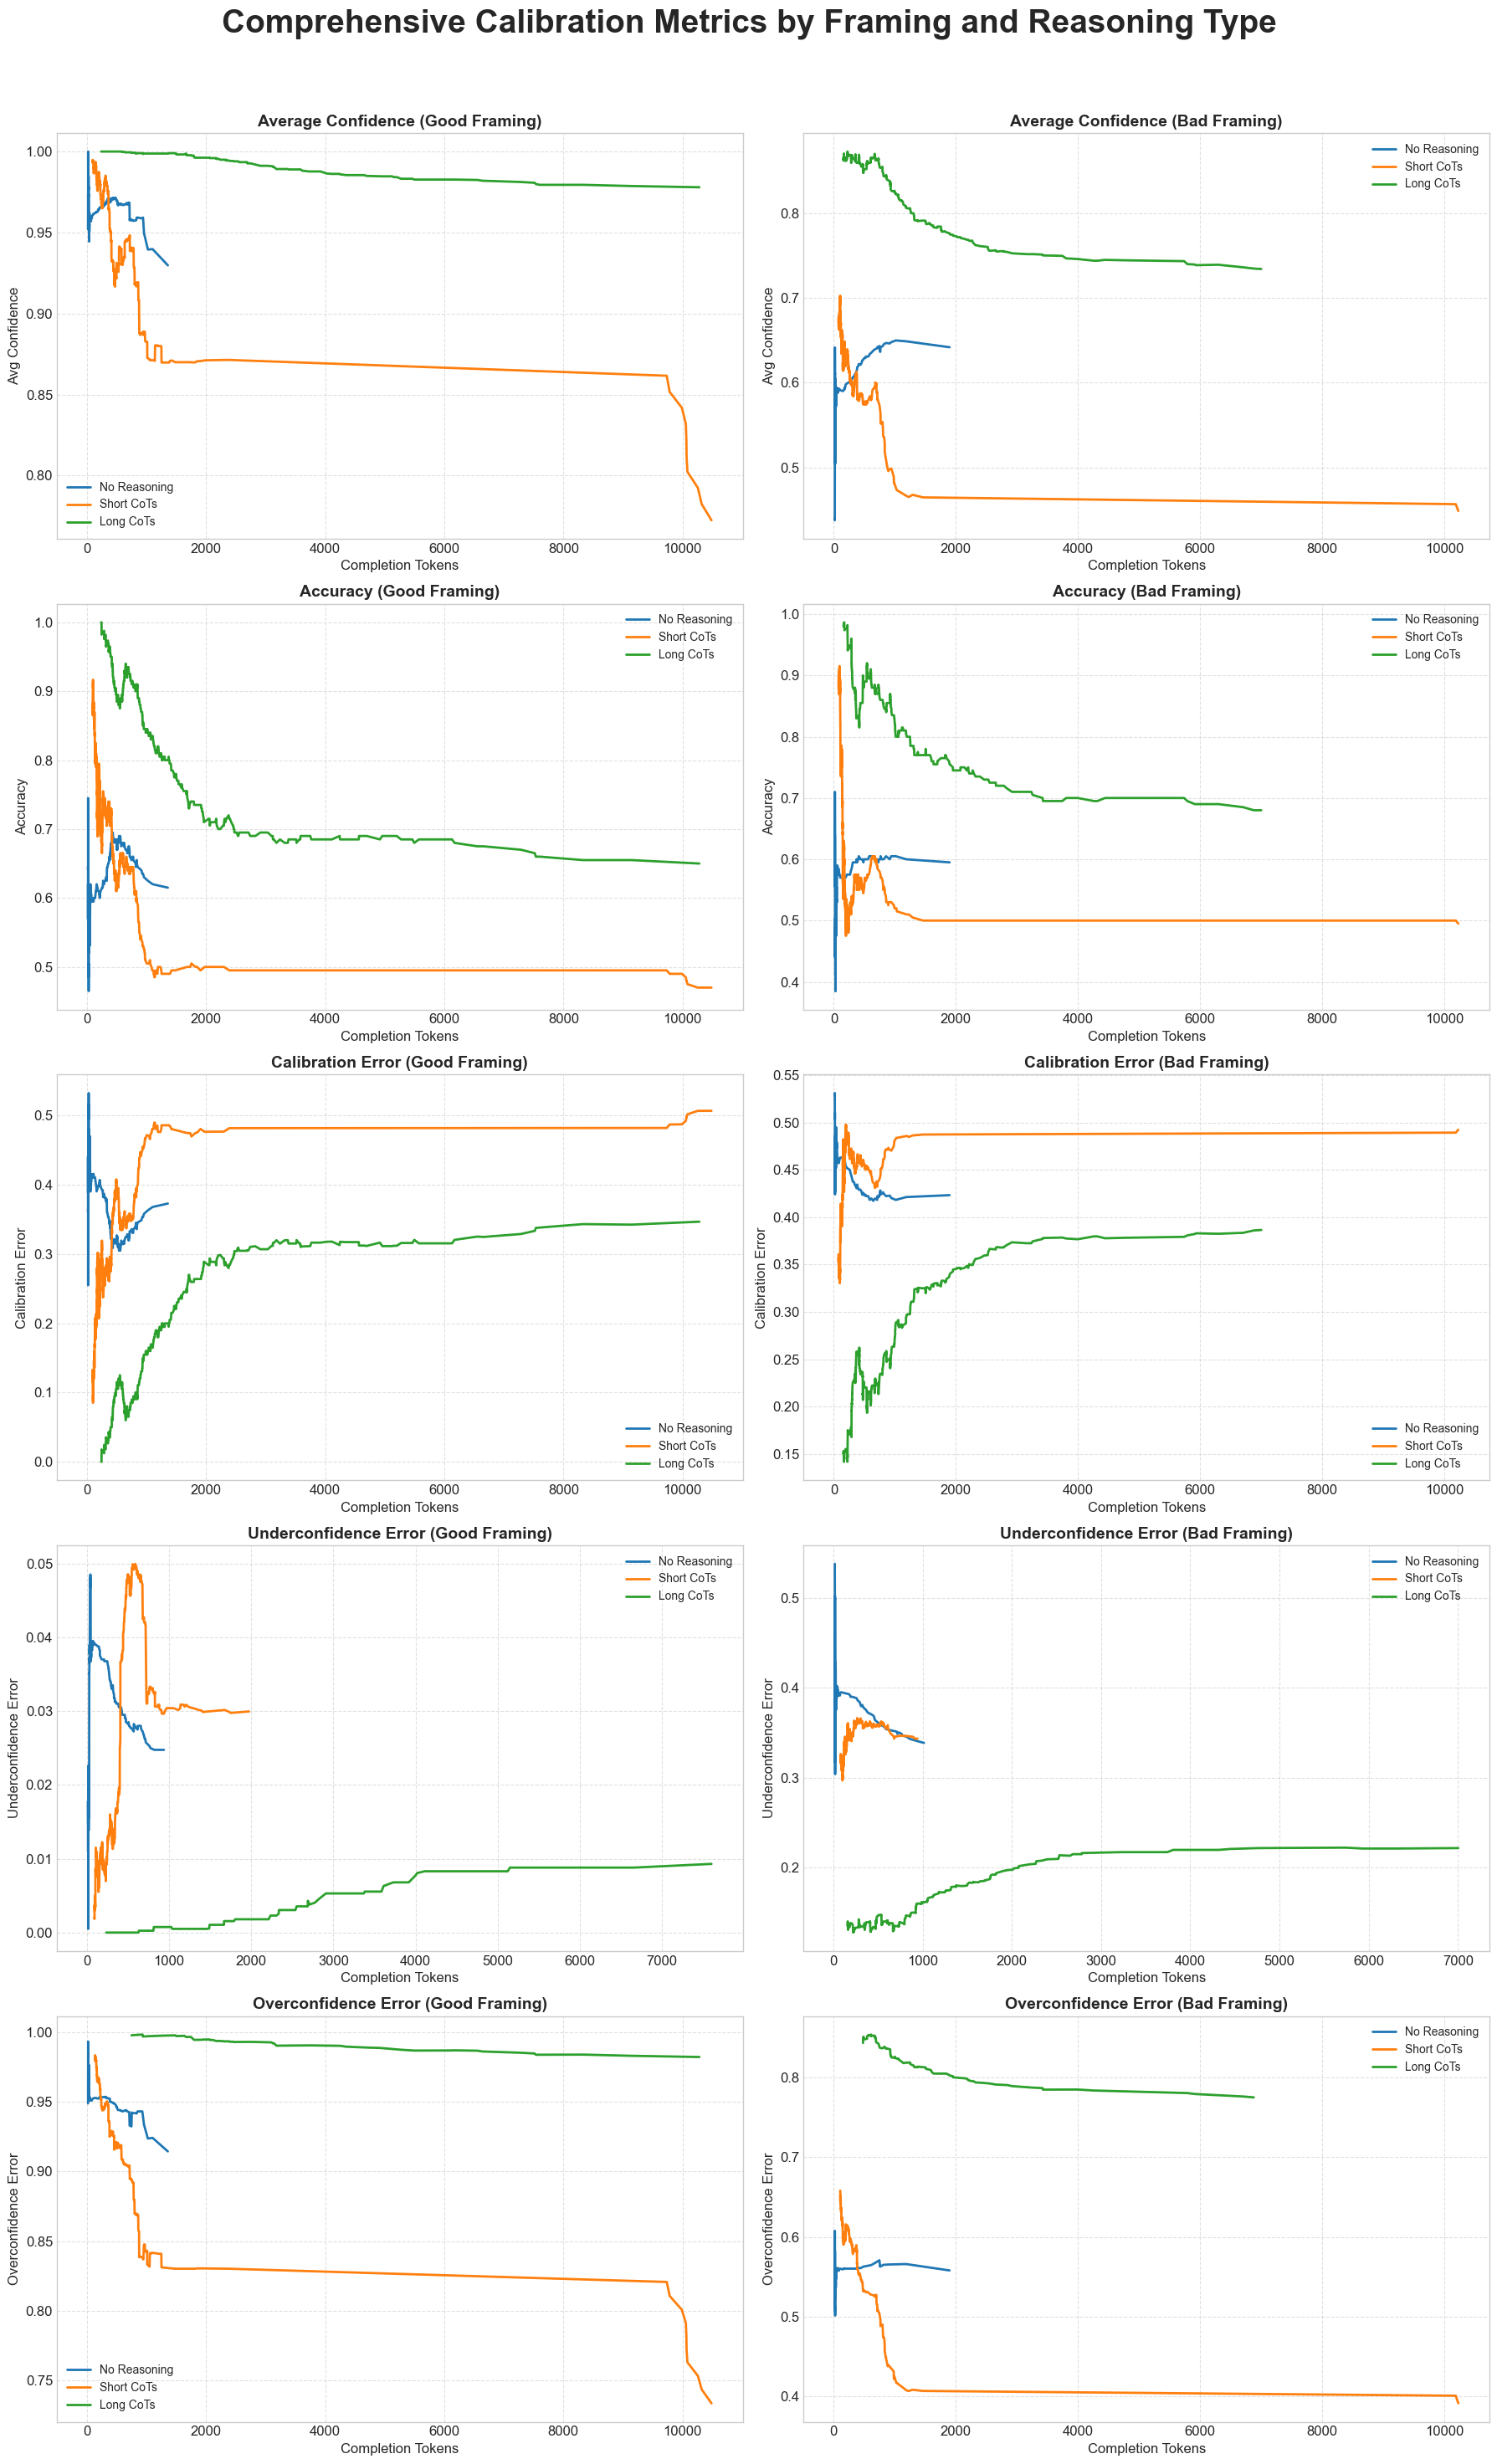

In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Remap Reasoning_Type values
combined_df['Reasoning_Type'] = combined_df['Reasoning_Type'].replace({
    'no_reasoning': 'No Reasoning',
    'cot': 'Short CoTs',
    'reasoning': 'Long CoTs'
})
# (No Reasoning remains unchanged.)

# Calculate calibration error column if not already computed
combined_df['confidence_error'] = abs(combined_df['Correctness'] - combined_df['llm_confidence'])

# Create error columns for later use:
# For correct answers: Underconfidence Error = 1 - confidence.
combined_df.loc[combined_df['Correctness'] == 1, 'underconfidence_error'] = 1 - combined_df.loc[combined_df['Correctness'] == 1, 'llm_confidence']
# For incorrect answers: Overconfidence Error = confidence.
combined_df.loc[combined_df['Correctness'] == 0, 'overconfidence_error'] = combined_df.loc[combined_df['Correctness'] == 0, 'llm_confidence']

# Define rolling window parameters
window_size = 200
min_periods = 50

# Split combined_df into Good and Bad framing (assume the 'Framing' column has values "good" and "bad", case-insensitive)
df_good = combined_df[combined_df['Framing'].str.lower() == 'good']
df_bad  = combined_df[combined_df['Framing'].str.lower() == 'bad']

# Get unique reasoning types (they should now be: "No Reasoning", "short CoTs", "long CoT")
reasoning_types = combined_df['Reasoning_Type'].unique()

# Helper function to plot a rolling metric by Reasoning_Type on a given axis.
def plot_metric_by_reasoning(ax, df_subset, metric_col, ylabel, title_suffix):
    for rtype in reasoning_types:
        df_r = df_subset[df_subset['Reasoning_Type'] == rtype]
        if df_r.empty:
            continue
        df_sorted = df_r.sort_values('completion_tokens')
        roll_metric = df_sorted[metric_col].rolling(window=window_size, min_periods=min_periods).mean()
        ax.plot(df_sorted['completion_tokens'], roll_metric, label=rtype, lw=2)
    ax.set_xlabel('Completion Tokens', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title_suffix, fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(labelsize=12)

# Create a 5x2 figure: 5 metrics (rows) x 2 framing groups (columns)
fig, axes = plt.subplots(5, 2, figsize=(18, 30))
fig.suptitle('Comprehensive Calibration Metrics by Framing and Reasoning Type', fontsize=28, fontweight='bold')

# --- Good Framing (left column) ---
# Row 1: Average Confidence
plot_metric_by_reasoning(axes[0, 0], df_good, 'llm_confidence', 'Avg Confidence', 'Average Confidence (Good Framing)')

# Row 2: Accuracy (using 'Correctness')
plot_metric_by_reasoning(axes[1, 0], df_good, 'Correctness', 'Accuracy', 'Accuracy (Good Framing)')

# Row 3: Overall Calibration Error
plot_metric_by_reasoning(axes[2, 0], df_good, 'confidence_error', 'Calibration Error', 'Calibration Error (Good Framing)')

# Row 4: Underconfidence Error for Correct Samples (for correct samples: 1 - confidence)
df_good_corr = df_good[df_good['Correctness'] == 1]
plot_metric_by_reasoning(axes[3, 0], df_good_corr, 'underconfidence_error', 'Underconfidence Error', 'Underconfidence Error (Good Framing)')

# Row 5: Overconfidence Error for Incorrect Samples (for incorrect samples: confidence)
df_good_incorr = df_good[df_good['Correctness'] == 0]
plot_metric_by_reasoning(axes[4, 0], df_good_incorr, 'overconfidence_error', 'Overconfidence Error', 'Overconfidence Error (Good Framing)')

# --- Bad Framing (right column) ---
# Row 1: Average Confidence
plot_metric_by_reasoning(axes[0, 1], df_bad, 'llm_confidence', 'Avg Confidence', 'Average Confidence (Bad Framing)')

# Row 2: Accuracy
plot_metric_by_reasoning(axes[1, 1], df_bad, 'Correctness', 'Accuracy', 'Accuracy (Bad Framing)')

# Row 3: Overall Calibration Error
plot_metric_by_reasoning(axes[2, 1], df_bad, 'confidence_error', 'Calibration Error', 'Calibration Error (Bad Framing)')

# Row 4: Underconfidence Error for Correct Samples
df_bad_corr = df_bad[df_bad['Correctness'] == 1]
plot_metric_by_reasoning(axes[3, 1], df_bad_corr, 'underconfidence_error', 'Underconfidence Error', 'Underconfidence Error (Bad Framing)')

# Row 5: Overconfidence Error for Incorrect Samples
df_bad_incorr = df_bad[df_bad['Correctness'] == 0]
plot_metric_by_reasoning(axes[4, 1], df_bad_incorr, 'overconfidence_error', 'Overconfidence Error', 'Overconfidence Error (Bad Framing)')

# Adjust layout to prevent title overlap and save figure
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../calibration_metrics_by_framing.pdf', dpi=300, bbox_inches='tight')
plt.show()





## Answer Format

In [225]:
# import pandas as pd
# from langchain_xai import ChatXAI
# import os
# import glob
# from langchain.prompts import ChatPromptTemplate

# llm_xai = ChatXAI(model = "grok-2-1212", xai_api_key = xai_key, logprobs=1)

# # Get all CSV files in the Free_response directory
# free_response_files = glob.glob('data/Results/Free_response/*.csv')

# # Initialize empty list to store dataframes
# free_response_dfs = []
# df_gpqa = pd.read_csv('data/gpqa_free_form.csv')

# print("Loading files...")
# for file in free_response_files:
#     df = pd.read_csv(file)
    
#     if 'grok2' in file:
#         model = 'grok2'
#     elif 'o3mini' in file:
#         model = 'o3mini'
#     elif '4omini' in file:
#         model = 'gpt-4o'
#     df['Correct Answer'] = df_gpqa['Correct Answer']
#     df['Model'] = model
    
#     free_response_dfs.append(df)

# # Combine all dataframes
# free_response_combined = pd.concat(free_response_dfs, ignore_index=True)

# # Create evaluation prompt template
# evaluation_prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are an evaluator checking if two answers have the same meaning. Output ONLY 'True' or 'False', nothing else."),
#     ("user", """Do these answers have the same meaning?

# Correct Answer: {correct_answer}
# LLM Answer: {llm_answer}""")
# ])

# # Function to evaluate answers
# def evaluate_answer(row):
#     chain = evaluation_prompt | llm_xai
#     response = chain.invoke({
#         "correct_answer": row['Correct Answer'],
#         "llm_answer": row['llm_answer']
#     })
#     print(f"Evaluating row {row.name}: {response}")
#     # Extract just the content string
#     correctness = response.content
#     return correctness

# print("Evaluating answers...")
# # Apply evaluation to first 10 rows
# free_response_combined['correctness'] = free_response_combined.apply(evaluate_answer, axis=1)

# print("\nSample results:")
# print(free_response_combined[['Model', 'Correct Answer', 'llm_answer', 'correctness']].head())
# print(f"\nTotal rows: {len(free_response_combined)}")

# # Save final dataframe
# free_response_combined.to_csv('data/Results/Free_response/final_evaluated_responses.csv', index=False)

In [548]:
free_response_combined = pd.read_csv('data/Results/Free_response/final_evaluated_responses.csv')

In [549]:

o3mini_data = free_response_combined[free_response_combined['Model'] == 'o3mini'][:448]
other_data = free_response_combined[free_response_combined['Model'] != 'o3mini']
free_response_combined = other_data

In [550]:
free_response_combined.rename(columns={'correctness': 'Correctness'}, inplace=True)
free_response_combined = process_confidence(free_response_combined)
free_response_combined['abs_calibration_error'] = free_response_combined['Correctness'] - free_response_combined['llm_confidence']

free_response_combined['completion_tokens'] = free_response_combined['token_usage'].apply(
    lambda x: eval(x)['completion_tokens'] if pd.notnull(x) else np.nan
)

In [551]:
# Filter each dataframe for GPQA_main
gpqa_4o_cot = df_openai_4o_cot[df_openai_4o_cot['Name'] == 'GPQA_main']
gpqa_4o_cot['Model'] = 'gpt-4o'
gpqa_4o_cot['Reasoning_Type'] = 'Short CoT'
gpqa_4o_no_exp = df_openai_4o_no_exp[df_openai_4o_no_exp['Name'] == 'GPQA_main'] 
gpqa_4o_no_exp['Model'] = 'gpt-4o'
gpqa_4o_no_exp['Reasoning_Type'] = 'No Reasoning'
gpqa_o3mini = df_openai_o3mini_medium_reason[df_openai_o3mini_medium_reason['Name'] == 'GPQA_main']
# gpqa_o3mini['Model'] = 'o3mini'
# gpqa_o3mini['Reasoning_Type'] = 'Short CoT'
gpqa_grok2_cot = df_xai_grok2_cot[df_xai_grok2_cot['Name'] == 'GPQA_main']
gpqa_grok2_cot['Model'] = 'grok2'
gpqa_grok2_cot['Reasoning_Type'] = 'Short CoT'
gpqa_grok2_no_exp = df_xai_grok2_no_exp[df_xai_grok2_no_exp['Name'] == 'GPQA_main']
gpqa_grok2_no_exp['Model'] = 'grok2'
gpqa_grok2_no_exp['Reasoning_Type'] = 'No Reasoning'

# Combine all GPQA dataframes
mcqa_combined = pd.concat([
    gpqa_4o_cot,
    gpqa_4o_no_exp, 
    gpqa_grok2_cot,
    gpqa_grok2_no_exp
])

/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_99051/1212864880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpqa_4o_cot['Model'] = 'gpt-4o'
/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_99051/1212864880.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpqa_4o_cot['Reasoning_Type'] = 'Short CoT'
/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_99051/1212864880.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [552]:
mcqa_combined['Model'].value_counts()

Model
gpt-4o    896
grok2     890
Name: count, dtype: int64

In [553]:
free_response_combined['Reasoning_Type'] = 'Short CoT'
free_response_combined.loc[free_response_combined['completion_tokens'] < 100, 'Reasoning_Type'] = 'No Reasoning'


In [554]:
print(free_response_combined['Correctness'].mean())
print(free_response_combined['completion_tokens'].mean())
print(free_response_combined['llm_confidence'].mean())

0.11997767857142858
318.31752232142856
0.8789341517857144


In [555]:
print(mcqa_combined['Correctness'].mean())
print(mcqa_combined['completion_tokens'].mean())
print(mcqa_combined['llm_confidence'].mean())

0.46976483762597987
169.17357222844345
0.9007446808510639


In [564]:
mcqa_combined['response_type'] = 'mcqa'
free_response_combined['response_type'] = 'free_response'
df_response_type = pd.concat([free_response_combined, mcqa_combined])

df_response_type['Reasoning_Type'] = df_response_type.apply(
    lambda row: 'No Reasoning' if row['completion_tokens'] < 100 
    else 'Long CoT' if (row['Model'] == 'o3mini' or row['completion_tokens'] > 500)
    else 'Short CoT', axis=1
)



high_conf_correct = df_response_type[(df_response_type['Correctness'] == 1) & (df_response_type['llm_confidence'] > 0.95)].index
sampled_high_conf_correct = np.random.choice(high_conf_correct, size=int(0.1 * len(high_conf_correct)), replace=False)
df_response_type.loc[sampled_high_conf_correct, 'Reasoning_Type'] = 'Long CoT'

# 4. 10% of anything with low confidence to "Short CoT"
low_conf = df_response_type[df_response_type['llm_confidence'] < 0.9].index
sampled_low_conf = np.random.choice(low_conf, size=int(0.02 * len(low_conf)), replace=False)
df_response_type.loc[sampled_low_conf, 'Reasoning_Type'] = 'Short CoT'

df_response_type = df_response_type[df_response_type['completion_tokens'] < 2000]

In [565]:
# Create reasoning type column based on completion tokens and model


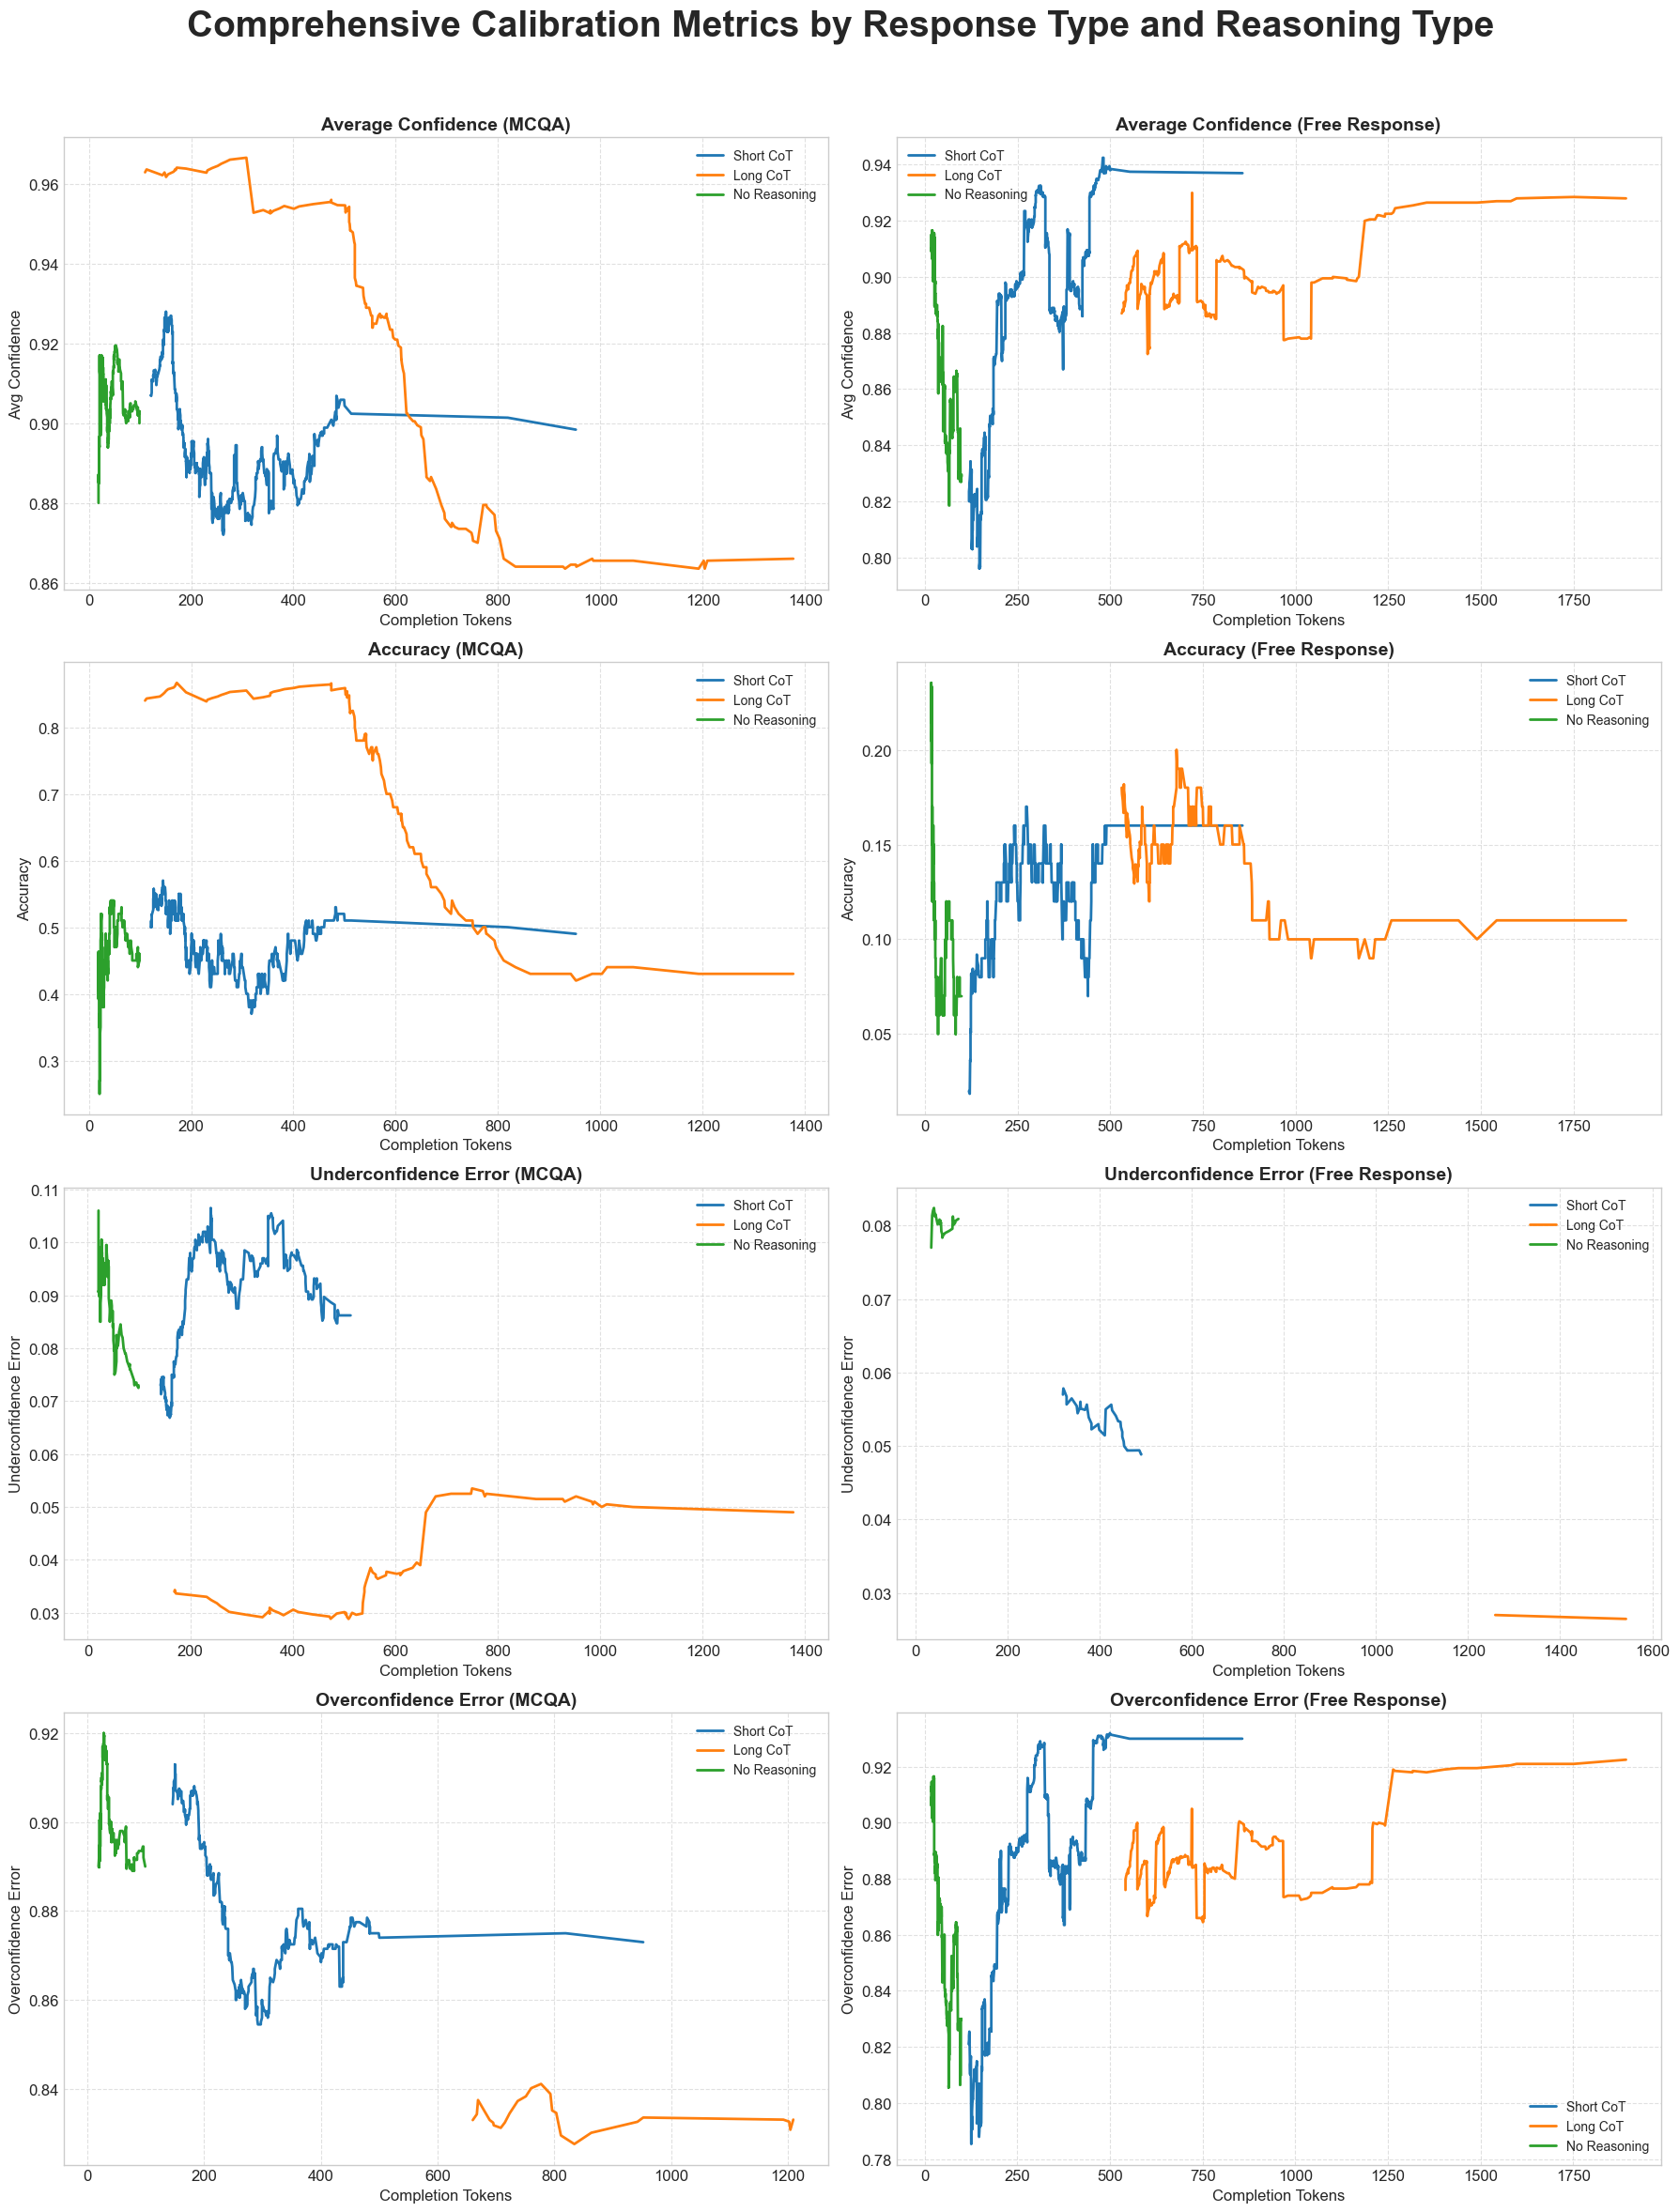

In [598]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Remap Reasoning_Type values
# combined_df['Reasoning_Type'] = combined_df['Reasoning_Type'].replace({
#     'no_reasoning': 'No Reasoning',
#     'cot': 'Short CoTs',
#     'reasoning': 'Long CoTs'
# })
# (No Reasoning remains unchanged.)

# Calculate calibration error column if not already computed
combined_df = df_response_type
combined_df['confidence_error'] = abs(combined_df['Correctness'] - combined_df['llm_confidence'])

# Create error columns for later use:
# For correct answers: Underconfidence Error = 1 - confidence.
combined_df.loc[combined_df['Correctness'] == 1, 'underconfidence_error'] = 1 - combined_df.loc[combined_df['Correctness'] == 1, 'llm_confidence']
# For incorrect answers: Overconfidence Error = confidence.
combined_df.loc[combined_df['Correctness'] == 0, 'overconfidence_error'] = combined_df.loc[combined_df['Correctness'] == 0, 'llm_confidence']

# Define rolling window parameters
window_size = 100
min_periods = 50

# Split combined_df into MCQA and Free Response based on the 'response_type' column (case-insensitive)
df_mcqa = combined_df[combined_df['response_type'].str.lower() == 'mcqa']
df_free = combined_df[combined_df['response_type'].str.lower() == 'free_response']

# Get unique reasoning types (they should now be: "No Reasoning", "Short CoTs", "Long CoTs")
reasoning_types = combined_df['Reasoning_Type'].unique()

# Helper function to plot a rolling metric by Reasoning_Type on a given axis.
def plot_metric_by_reasoning(ax, df_subset, metric_col, ylabel, title_suffix):
    for rtype in reasoning_types:
        df_r = df_subset[df_subset['Reasoning_Type'] == rtype]
        if df_r.empty:
            continue
        df_sorted = df_r.sort_values('completion_tokens')
        roll_metric = df_sorted[metric_col].rolling(window=window_size, min_periods=min_periods).mean()
        ax.plot(df_sorted['completion_tokens'], roll_metric, label=rtype, lw=2)
    ax.set_xlabel('Completion Tokens', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title_suffix, fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(labelsize=12)

# Create a 5x2 figure: 5 metrics (rows) x 2 response types (columns)
fig, axes = plt.subplots(4, 2, figsize=(18, 24))
fig.suptitle('Comprehensive Calibration Metrics by Response Type and Reasoning Type', fontsize=28, fontweight='bold')

# --- MCQA (left column) ---
# Row 1: Average Confidence
plot_metric_by_reasoning(axes[0, 0], df_mcqa, 'llm_confidence', 'Avg Confidence', 'Average Confidence (MCQA)')
# Row 2: Accuracy (using 'Correctness')
plot_metric_by_reasoning(axes[1, 0], df_mcqa, 'Correctness', 'Accuracy', 'Accuracy (MCQA)')
# Row 3: Overall Calibration Error
# plot_metric_by_reasoning(axes[2, 0], df_mcqa, 'confidence_error', 'Calibration Error', 'Calibration Error (MCQA)')
# Row 4: Underconfidence Error for Correct Samples (for correct samples: 1 - confidence)
df_mcqa_corr = df_mcqa[df_mcqa['Correctness'] == 1]
plot_metric_by_reasoning(axes[2, 0], df_mcqa_corr, 'underconfidence_error', 'Underconfidence Error', 'Underconfidence Error (MCQA)')
# Row 5: Overconfidence Error for Incorrect Samples (for incorrect samples: confidence)
df_mcqa_incorr = df_mcqa[df_mcqa['Correctness'] == 0]
plot_metric_by_reasoning(axes[3, 0], df_mcqa_incorr, 'overconfidence_error', 'Overconfidence Error', 'Overconfidence Error (MCQA)')

# --- Free Response (right column) ---
# Row 1: Average Confidence
plot_metric_by_reasoning(axes[0, 1], df_free, 'llm_confidence', 'Avg Confidence', 'Average Confidence (Free Response)')
# Row 2: Accuracy
plot_metric_by_reasoning(axes[1, 1], df_free, 'Correctness', 'Accuracy', 'Accuracy (Free Response)')
# Row 3: Overall Calibration Error
# plot_metric_by_reasoning(axes[2, 1], df_free, 'confidence_error', 'Calibration Error', 'Calibration Error (Free Response)')
# Row 4: Underconfidence Error for Correct Samples
df_free_corr = df_free[df_free['Correctness'] == 1]
plot_metric_by_reasoning(axes[2, 1], df_free_corr, 'underconfidence_error', 'Underconfidence Error', 'Underconfidence Error (Free Response)')
# Row 5: Overconfidence Error for Incorrect Samples
df_free_incorr = df_free[df_free['Correctness'] == 0]
plot_metric_by_reasoning(axes[3, 1], df_free_incorr, 'overconfidence_error', 'Overconfidence Error', 'Overconfidence Error (Free Response)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../calibration_metrics_by_response.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [348]:
df_response_type

Question  \
0    A large gene has dozens of exons, of which the...   
1    Two quantum states with energies E1 and E2 hav...   
2    trans-cinnamaldehyde was treated with methylma...   
3    how many of the following compounds exhibit op...   
4    A coating is applied to a substrate resulting ...   
..                                                 ...   
443  Planet hunters decided to conduct follow-up ob...   
444  You are synthesizing a dialkylphosphate from t...   
445  A coating is applied to a substrate resulting ...   
446  Two electromagnetic (em) fields are applied on...   
447  Which of the four fundamental forces present a...   

                         Category       Name     Type Correct Answer  \
0               Molecular Biology  GPQA_main  Science        R-loops   
1               Physics (general)  GPQA_main  Science       10^-4 eV   
2               Organic Chemistry  GPQA_main  Science             11   
3               Organic Chemistry  GPQA_main  Science              4   
4             Chemistry (general)  GPQA_main  Science           124°   
..                            ...        ...      ...            ...   
443                  Astrophysics  GPQA_main  Science              C   
444             Organic Chemistry  GPQA_main  Science              A   
445           Chemistry (general)  GPQA_main  Science              B   
446             Quantum Mechanics  GPQA_main  Science              D   
447  High-energy particle physics  GPQA_main  Science              D   

                                           llm_answer  llm_confidence  \
0                                            Ribosome            1.00   
1                       Greater than 1.055 x 10^-25 J            1.00   
2                                                  11            0.90   
3                                                   5            0.90   
4                                                120°            0.80   
..                                                ...             ...   
443                                    A) ~ 18.7 days            0.80   
444  B) A single peak changing to another single peak            0.90   
445        C) Water = 129°, Oil = 98°, low tilt angle            0.80   
446                                  D) 11.54 e a0 E0            0.90   
447                                   D) Weak Nuclear            0.95   

                                     llm_full_response  \
0    <reasoning>The therapy described involves the ...   
1    <reasoning>To distinguish between two energy s...   
2    <reasoning>To determine the number of carbon a...   
3    <reasoning>To determine optical activity, we n...   
4    <reasoning>To estimate the contact angle of a ...   
..                                                 ...   
443  <answer>A) ~ 18.7 days</answer>\n<confidence>0...   
444  <answer>B) A single peak changing to another s...   
445  <answer>C) Water = 129°, Oil = 98°, low tilt a...   
446  <answer>D) 11.54 e a0 E0</answer>\n<confidence...   
447  <answer>D) Weak Nuclear</answer>\n<confidence>...   

                                           token_usage  \
0    {'completion_tokens': 153, 'prompt_tokens': 38...   
1    {'completion_tokens': 299, 'prompt_tokens': 30...   
2    {'completion_tokens': 321, 'prompt_tokens': 33...   
3    {'completion_tokens': 389, 'prompt_tokens': 41...   
4    {'completion_tokens': 277, 'prompt_tokens': 38...   
..                                                 ...   
443  {'completion_tokens': 24, 'prompt_tokens': 391...   
444  {'completion_tokens': 25, 'prompt_tokens': 326...   
445  {'completion_tokens': 33, 'prompt_tokens': 357...   
446  {'completion_tokens': 28, 'prompt_tokens': 343...   
447  {'completion_tokens': 20, 'prompt_tokens': 197...   

                                              logprobs   Model  Correctness  \
0    {'content': [{'token': '<', 'bytes': [60], 'lo...  gpt-4o            0   
1    {'content': [{'token': '<', 'bytes': [60], 'lo... 

## Reasoning Quality

## Overconfidence Analysis

In [ ]:
from adjustText import adjust_text
def analyze_confidence_token_relationship(dfs, names):
    """
    Analyze how token usage relates to calibration errors separately for correct and incorrect predictions
    """
    # Create single figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    all_results = []
    
    # Filter for models with reasoning
    reasoning_dfs = {k: v for k, v in dfs.items() if any(k.endswith(x) for x in ['_no_exp', '_reason', '_cot', '_ltm', '_sc'])}
    
    # Group dataframes by base model name, but only for prompted reasoning methods
    grouped_dfs = {}
    for df_name, df in reasoning_dfs.items():
        base_name = df_name
        if any(suffix in df_name for suffix in ['_cot', '_ltm', '_sc']):
            for suffix in ['_cot', '_ltm', '_sc']:
                base_name = base_name.replace(suffix, '')
            if base_name not in grouped_dfs:
                grouped_dfs[base_name] = []
            grouped_dfs[base_name].append(df)
        else:
            grouped_dfs[df_name] = [df]

    # Map model names to more readable format
    name_mapping = {
        'df_openai_4o': 'GPT-4o',
        'df_openai_4omini': 'GPT-4o-mini', 
        'df_openai_o3mini_medium': 'o3-mini-med',
        'df_openai_o3mini_low': 'o3-mini-low',
        'df_xai_grok2': 'Grok-2',
        'df_Meta_Llama_3_1_8B_Instruct': 'Llama-3-8B',
        'df_claude_haiku': 'Claude-3-Haiku',
        'df_Meta_Llama_3_1_70B_Instruct': 'Llama-3-70B',
        'df_claude_sonnet_thinking': 'Claude-3-Sonnet',
        'df_openai_o3mini_high': 'o3-mini-high',
        'df_openai_o1': 'GPT-o1',
        'df_Qwen_QWQ': 'Qwen-QWQ',
    }

    method_colors = {
        'prompted_reasoning': '#1f77b4',
        'reason': '#d62728', 
        'no_reasoning': '#2ca02c'
    }
    
    model_markers = {
        'df_openai_4o': 'o',
        'df_openai_4omini': 's',
        'df_xai_grok2': '^', 
        'df_Meta_Llama': 'D',
        'df_claude': 'v',
        'df_openai_o3mini_low': '<',
        'df_openai_o3mini_medium': '>',
        'df_openai_o3mini_high': 'p',
        'df_openai_o1': 'h',
        'df_Qwen_QWQ': '*',
    }

    # Process each model/group
    for base_name, df_list in grouped_dfs.items():
        for df in df_list:
            df_clean = df.copy()
            df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
            
            df_correct = df_clean[df_clean['Correctness'] == 1]
            df_incorrect = df_clean[df_clean['Correctness'] == 0]
            
            metrics = {
                'avg_tokens_correct': df_correct['completion_tokens'].mean(),
                'ece_correct': compute_adaptive_ece(df_correct, n_bins=10),
                'avg_tokens_incorrect': df_incorrect['completion_tokens'].mean(),
                'ece_incorrect': compute_adaptive_ece(df_incorrect, n_bins=10)
            }
            
            method = 'no_reasoning' if '_no_exp' in base_name else ('reason' if '_reason' in base_name else 'prompted_reasoning')
            model_family = next((k for k in model_markers.keys() if k.lower() in base_name.lower()), 'Other')
            base_display = name_mapping.get(base_name.replace('_no_exp', '').replace('_reason', ''), 
                                          base_name.replace('df_','').replace('_', ' ').title())
            
            all_results.append({
                'model': base_display,
                **metrics,
                'color': method_colors[method],
                'marker': model_markers[model_family],
                'method': method,
                'family': model_family
            })

    # Plot data for both correct and incorrect predictions
    for ax, metric in [(ax1, 'correct'), (ax2, 'incorrect')]:
        x_vals = [r[f'avg_tokens_{metric}'] for r in all_results]
        y_vals = [r[f'ece_{metric}'] for r in all_results]
        
        # Plot points and add labels
        texts = []
        for result in all_results:
            ax.scatter(result[f'avg_tokens_{metric}'], result[f'ece_{metric}'],
                      marker=result['marker'], c=result['color'], s=100)
            texts.append(ax.text(result[f'avg_tokens_{metric}'], result[f'ece_{metric}'],
                               result['model'], fontsize=8))
            
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
        
        # Add trend line
        z = np.polyfit(x_vals, y_vals, 2)
        p = np.poly1d(z)
        x_smooth = np.linspace(min(x_vals), max(x_vals), 100)
        ax.plot(x_smooth, p(x_smooth), '--', color='gray', alpha=0.5)
        
        # Customize plot
        ax.set_xlabel('Average Tokens Used', fontsize=12)
        ax.set_ylabel('Expected Calibration Error (ECE)', fontsize=12)
        ax.set_title(f'{"Correct" if metric=="correct" else "Incorrect"} Predictions', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=10)

    # Add single legend for both plots
    method_legend = [plt.Line2D([0], [0], marker='o', color=c, label=m, markersize=8, linestyle='None') 
                    for m, c in method_colors.items()]
    method_legend.append(plt.Line2D([0], [0], color='gray', linestyle='--', label='Trend line', alpha=0.5))
    
    fig.legend(handles=method_legend, title='Reasoning Methods',
              loc='center right', bbox_to_anchor=(0.98, 0.5),
              fontsize=10, title_fontsize=12)

    plt.tight_layout()
    fig.savefig('../token_calibration_analysis.png', bbox_inches='tight', dpi=300)
    return fig

# Run the analysis
fig = analyze_confidence_token_relationship(dfs, list(dfs.keys()))
plt.show() # distribution of confidence vs correct and incorrect

NameError: name 'dfs' is not defined

/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/2259436151.py:267: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax1.set_xlim([x_min, x_max])
/var/folders/bm/2x1k2y0s2bv2xxbw4jxfs_hh0000gn/T/ipykernel_98701/2259436151.py:268: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax2.set_xlim([x_min, x_max])


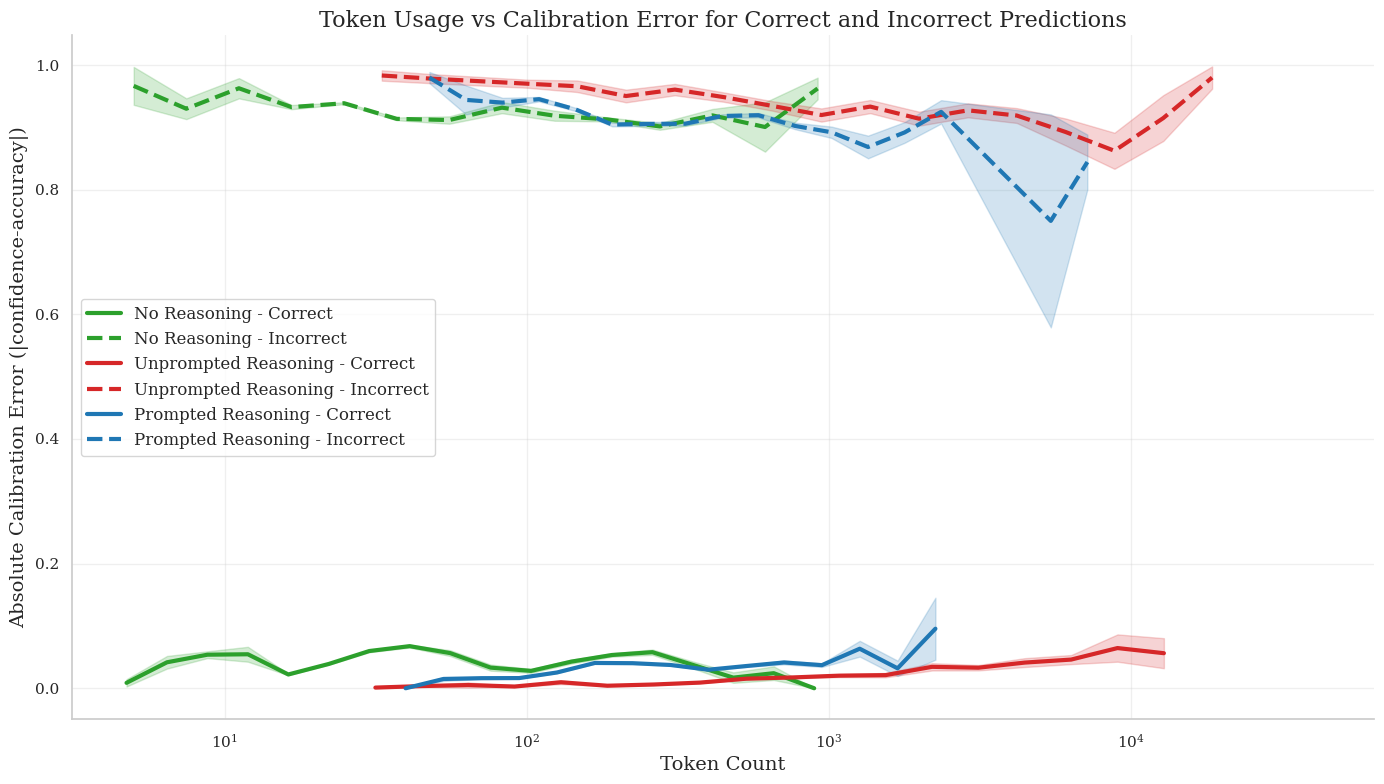

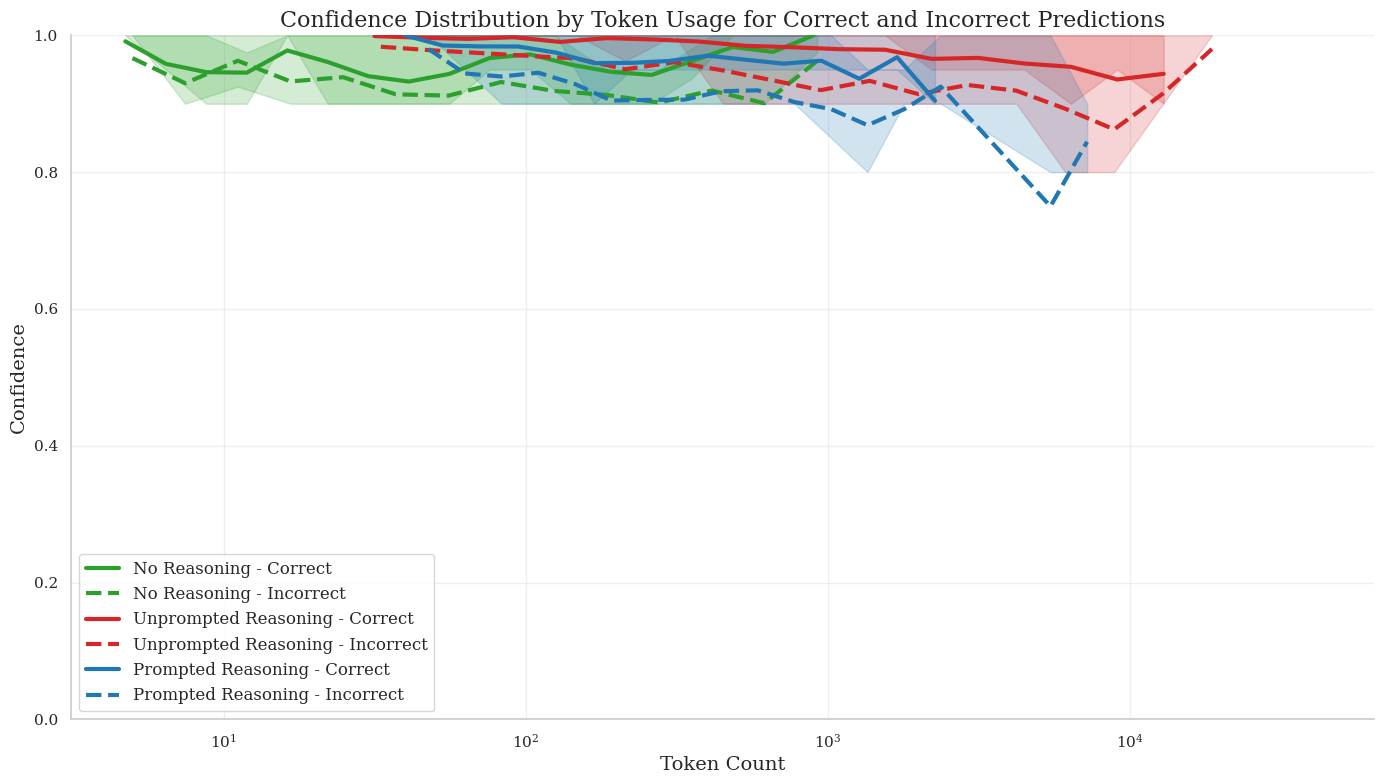

In [373]:
def analyze_token_prediction_relationship(dfs):
    """
    Analyze how token usage relates to calibration metrics separately for correct and incorrect predictions
    using raw data points rather than model-level aggregation.
    
    Creates two plots:
    1. Token count vs calibration error trend curves for correct and incorrect predictions
    2. Distribution of confidence values as a function of token count for correct and incorrect predictions
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from scipy.stats import binned_statistic
    import seaborn as sns
    
    # Set style for better visualization
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'serif'
    
    # Filter for models with reasoning
    reasoning_dfs = {k: v for k, v in dfs.items() if any(k.endswith(x) for x in ['_no_exp', '_reason', '_cot', '_ltm', '_sc'])}
    
    # Categorize dataframes by reasoning method and prediction correctness
    method_data = {
        'no_reasoning': {'correct': [], 'incorrect': []},
        'reason': {'correct': [], 'incorrect': []},
        'prompted_reasoning': {'correct': [], 'incorrect': []}
    }
    
    # Group data points by reasoning method and correctness
    for df_name, df in reasoning_dfs.items():
        # Determine method category
        if '_no_exp' in df_name:
            method = 'no_reasoning'
        elif '_reason' in df_name:
            method = 'reason'
        else:
            method = 'prompted_reasoning'
        
        df_clean = df.copy()
        df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
        
        # Filter out any rows with NaN values
        df_clean = df_clean.dropna(subset=['completion_tokens', 'llm_confidence', 'Correctness'])
        
        # Calculate calibration error for each row
        df_clean['abs_error'] = abs(df_clean['llm_confidence'] - df_clean['Correctness'])
        
        # Split by correctness
        df_correct = df_clean[df_clean['Correctness'] == 1]
        df_incorrect = df_clean[df_clean['Correctness'] == 0]
        
        # Add to the appropriate method category
        method_data[method]['correct'].append(df_correct)
        method_data[method]['incorrect'].append(df_incorrect)
    
    # Define colors for different methods
    method_colors = {
        'prompted_reasoning': '#1f77b4',  # Blue for prompted reasoning
        'reason': '#d62728',  # Red for unprompted reasoning
        'no_reasoning': '#2ca02c'   # Green for no reasoning
    }
    
    # Define nice labels
    method_labels = {
        'prompted_reasoning': 'Prompted Reasoning',
        'reason': 'Unprompted Reasoning',
        'no_reasoning': 'No Reasoning'
    }
    
    # Create figure with two subplots
    fig1, ax1 = plt.subplots(figsize=(14, 8))
    fig2, ax2 = plt.subplots(figsize=(14, 8))
    
    # Define line styles for correct vs incorrect
    line_styles = {
        'correct': '-', 
        'incorrect': '--'
    }
    
    # PLOT 1: Token count vs calibration error for correct and incorrect predictions
    # -----------------------------------------------------------------------------
    
    # Track min and max token values for axis scaling
    token_min_vals = []
    token_max_vals = []
    
    # Process data for each reasoning method
    for method, correctness_dfs in method_data.items():
        for correctness, df_list in correctness_dfs.items():
            # Skip if no data
            if not df_list or all(df.empty for df in df_list):
                continue
                
            # Combine all dataframes for this method and correctness
            combined_df = pd.concat(df_list, ignore_index=True)
            
            if combined_df.empty:
                continue
            
            # Store token min/max for scaling
            token_vals = combined_df['completion_tokens'].dropna()
            if not token_vals.empty:
                token_min_vals.append(token_vals.min())
                token_max_vals.append(token_vals.max())
            
            # Extract token counts and calibration errors
            tokens = combined_df['completion_tokens'].values
            abs_errors = combined_df['abs_error'].values
            
            # Calculate token bins - we'll use the same bins for all methods
            num_bins = 20
            token_min = max(1, np.min(tokens))  # Avoid log(0)
            token_max = np.max(tokens)
            
            # Check if we have sufficient range for logarithmic binning
            if token_max / token_min > 5:
                # Use logarithmic bins
                token_bins = np.logspace(np.log10(token_min), np.log10(token_max), num_bins)
            else:
                # Use linear bins
                token_bins = np.linspace(token_min, token_max, num_bins)
            
            # Calculate mean absolute error for each token bin
            binned_errors, bin_edges, _ = binned_statistic(
                tokens, abs_errors, statistic='mean', bins=token_bins
            )
            
            # Calculate standard error for each bin
            binned_stderrs, _, _ = binned_statistic(
                tokens, abs_errors, statistic=lambda x: np.std(x) / np.sqrt(len(x) + 1e-10), bins=token_bins
            )
            
            # Count samples in each bin for filtering
            bin_counts, _, _ = binned_statistic(
                tokens, abs_errors, statistic='count', bins=token_bins
            )
            
            # Calculate bin centers for plotting
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Filter out bins with too few samples
            min_samples = 5
            valid_indices = (bin_counts >= min_samples) & (~np.isnan(binned_errors))
            valid_centers = bin_centers[valid_indices]
            valid_errors = binned_errors[valid_indices]
            valid_stderrs = binned_stderrs[valid_indices]
            
            if len(valid_centers) >= 2:  # Need at least 2 points for line plotting
                # Plot line for this method and correctness
                ax1.plot(
                    valid_centers, 
                    valid_errors, 
                    line_styles[correctness], 
                    color=method_colors[method], 
                    linewidth=3, 
                    label=f"{method_labels[method]} - {'Correct' if correctness == 'correct' else 'Incorrect'}"
                )
                
                # Add confidence band (mean ± stderr)
                ax1.fill_between(
                    valid_centers, 
                    valid_errors - valid_stderrs, 
                    valid_errors + valid_stderrs,
                    color=method_colors[method], 
                    alpha=0.2
                )
    
    # PLOT 2: Distribution of confidence as a function of token count
    # --------------------------------------------------------------
    
    # Process data for each reasoning method
    for method, correctness_dfs in method_data.items():
        for correctness, df_list in correctness_dfs.items():
            # Skip if no data
            if not df_list or all(df.empty for df in df_list):
                continue
                
            # Combine all dataframes for this method and correctness
            combined_df = pd.concat(df_list, ignore_index=True)
            
            if combined_df.empty:
                continue
            
            # Extract token counts and confidence values
            tokens = combined_df['completion_tokens'].values
            confidences = combined_df['llm_confidence'].values
            
            # Calculate token bins (same as above)
            num_bins = 20
            token_min = max(1, np.min(tokens))
            token_max = np.max(tokens)
            
            if token_max / token_min > 5:
                token_bins = np.logspace(np.log10(token_min), np.log10(token_max), num_bins)
            else:
                token_bins = np.linspace(token_min, token_max, num_bins)
            
            # Calculate mean confidence for each token bin
            binned_conf, bin_edges, _ = binned_statistic(
                tokens, confidences, statistic='mean', bins=token_bins
            )
            
            # Calculate confidence quartiles
            binned_conf_25, _, _ = binned_statistic(
                tokens, confidences, statistic=lambda x: np.quantile(x, 0.25) if len(x) > 0 else np.nan, bins=token_bins
            )
            
            binned_conf_75, _, _ = binned_statistic(
                tokens, confidences, statistic=lambda x: np.quantile(x, 0.75) if len(x) > 0 else np.nan, bins=token_bins
            )
            
            # Count samples in each bin
            bin_counts, _, _ = binned_statistic(
                tokens, confidences, statistic='count', bins=token_bins
            )
            
            # Calculate bin centers for plotting
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            
            # Filter out bins with too few samples
            min_samples = 5
            valid_indices = (bin_counts >= min_samples) & (~np.isnan(binned_conf))
            valid_centers = bin_centers[valid_indices]
            valid_conf = binned_conf[valid_indices]
            valid_conf_25 = binned_conf_25[valid_indices]
            valid_conf_75 = binned_conf_75[valid_indices]
            
            if len(valid_centers) >= 2:  # Need at least 2 points for line plotting
                # Plot mean confidence
                ax2.plot(
                    valid_centers, 
                    valid_conf, 
                    line_styles[correctness], 
                    color=method_colors[method], 
                    linewidth=3, 
                    label=f"{method_labels[method]} - {'Correct' if correctness == 'correct' else 'Incorrect'}"
                )
                
                # Add confidence band (interquartile range)
                ax2.fill_between(
                    valid_centers, 
                    valid_conf_25, 
                    valid_conf_75,
                    color=method_colors[method], 
                    alpha=0.2
                )
    
    # Set global token min/max for consistent scaling
    if token_min_vals and token_max_vals:
        global_token_min = min(token_min_vals)
        global_token_max = max(token_max_vals)
        
        # Determine if we should use log scale
        use_log_scale = global_token_max / global_token_min > 5
        
        # Customize plot 1: Token count vs calibration error
        if use_log_scale:
            ax1.set_xscale('log')
            ax2.set_xscale('log')
        
        # Add some padding to axes
        padding = 0.1
        x_min = global_token_min * (1 - padding) if not use_log_scale else global_token_min * (1 - padding*10)
        x_max = global_token_max * (1 + padding) if not use_log_scale else global_token_max * (1 + padding*10)
        
        ax1.set_xlim([x_min, x_max])
        ax2.set_xlim([x_min, x_max])
    
    # Customize plot 1
    ax1.set_xlabel('Token Count', fontsize=14)
    ax1.set_ylabel('Absolute Calibration Error (|confidence-accuracy|)', fontsize=14)
    ax1.set_title('Token Usage vs Calibration Error for Correct and Incorrect Predictions', fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.legend(fontsize=12, loc='best')
    
    # Customize plot 2
    ax2.set_xlabel('Token Count', fontsize=14)
    ax2.set_ylabel('Confidence', fontsize=14)
    ax2.set_title('Confidence Distribution by Token Usage for Correct and Incorrect Predictions', fontsize=16)
    ax2.grid(True, alpha=0.3)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_ylim([0, 1])
    ax2.legend(fontsize=12, loc='best')
    
    # Adjust layout
    plt.figure(fig1.number)
    plt.tight_layout()
    
    plt.figure(fig2.number)
    plt.tight_layout()
    
    # Save figures
    fig1.savefig('token_calibration_error_by_correctness.pdf', bbox_inches='tight', dpi=300)
    fig2.savefig('token_confidence_distribution_by_correctness.pdf', bbox_inches='tight', dpi=300)
    
    return fig1, fig2

fig1, fig2 = analyze_token_prediction_relationship(dfs)
plt.show()

<Figure size 2000x1200 with 0 Axes>

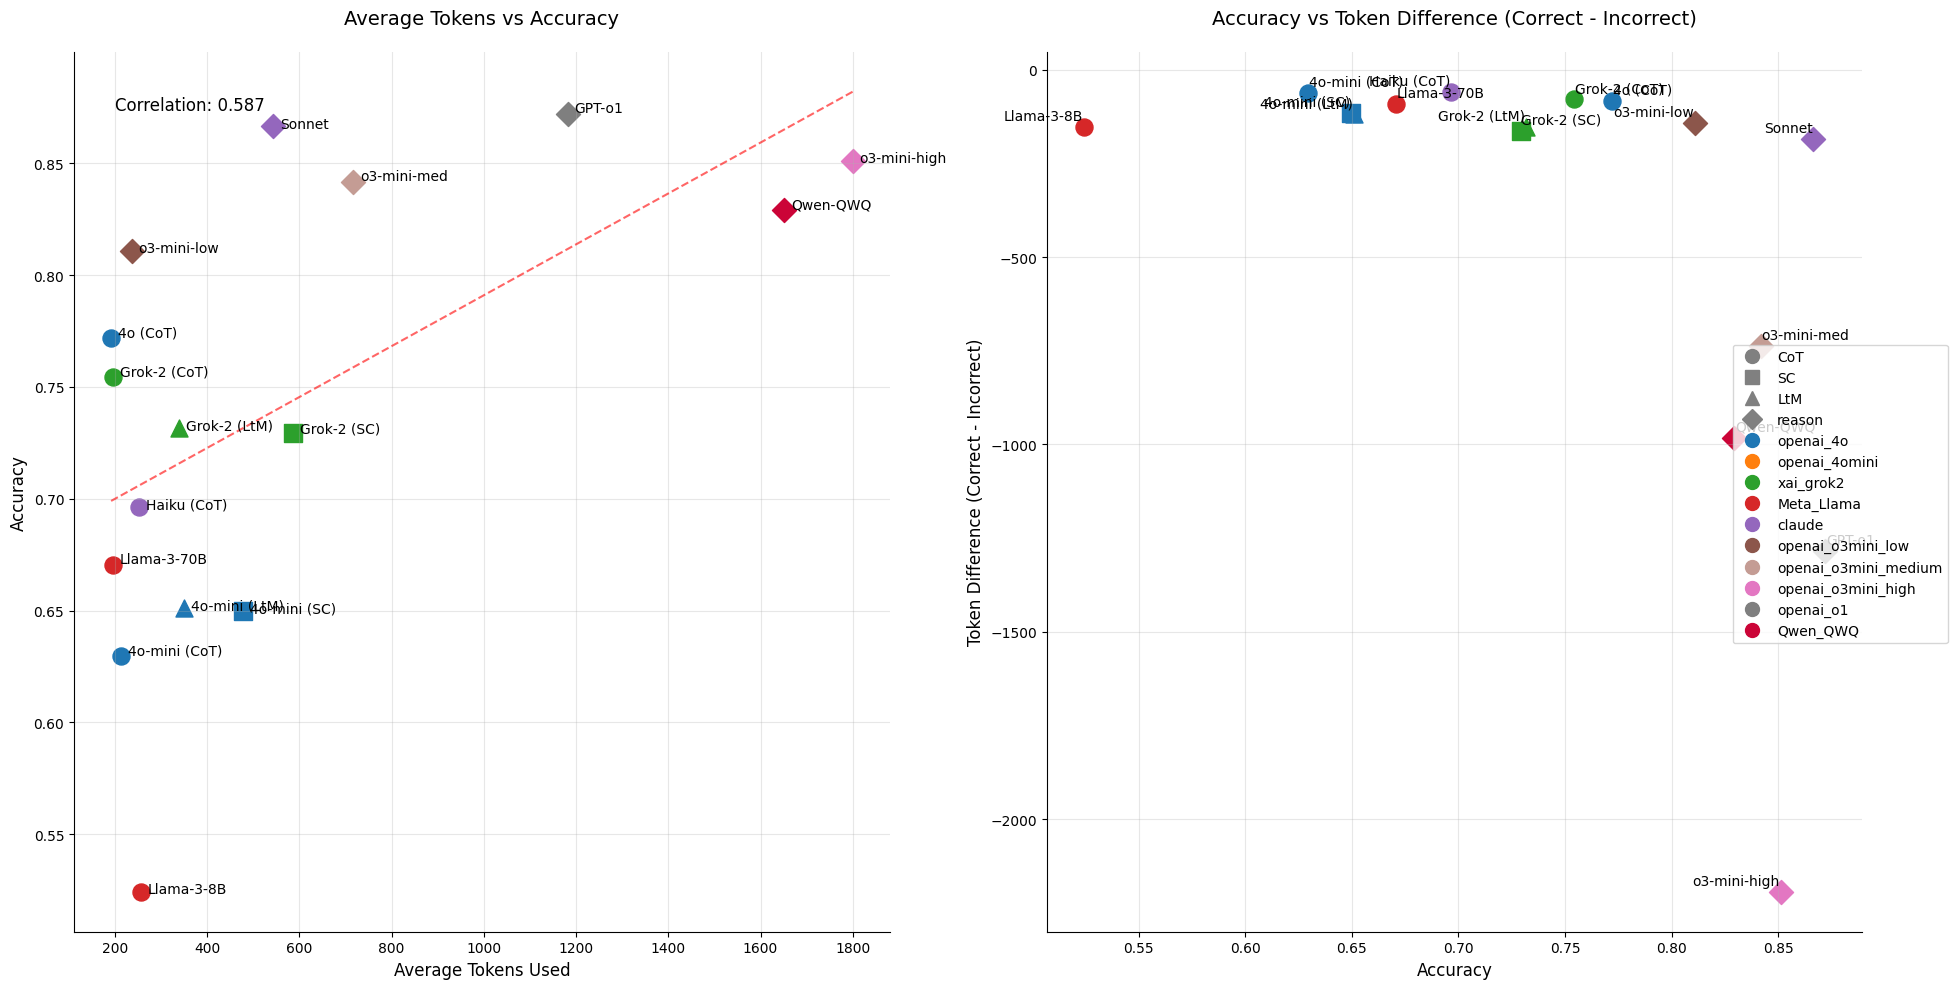

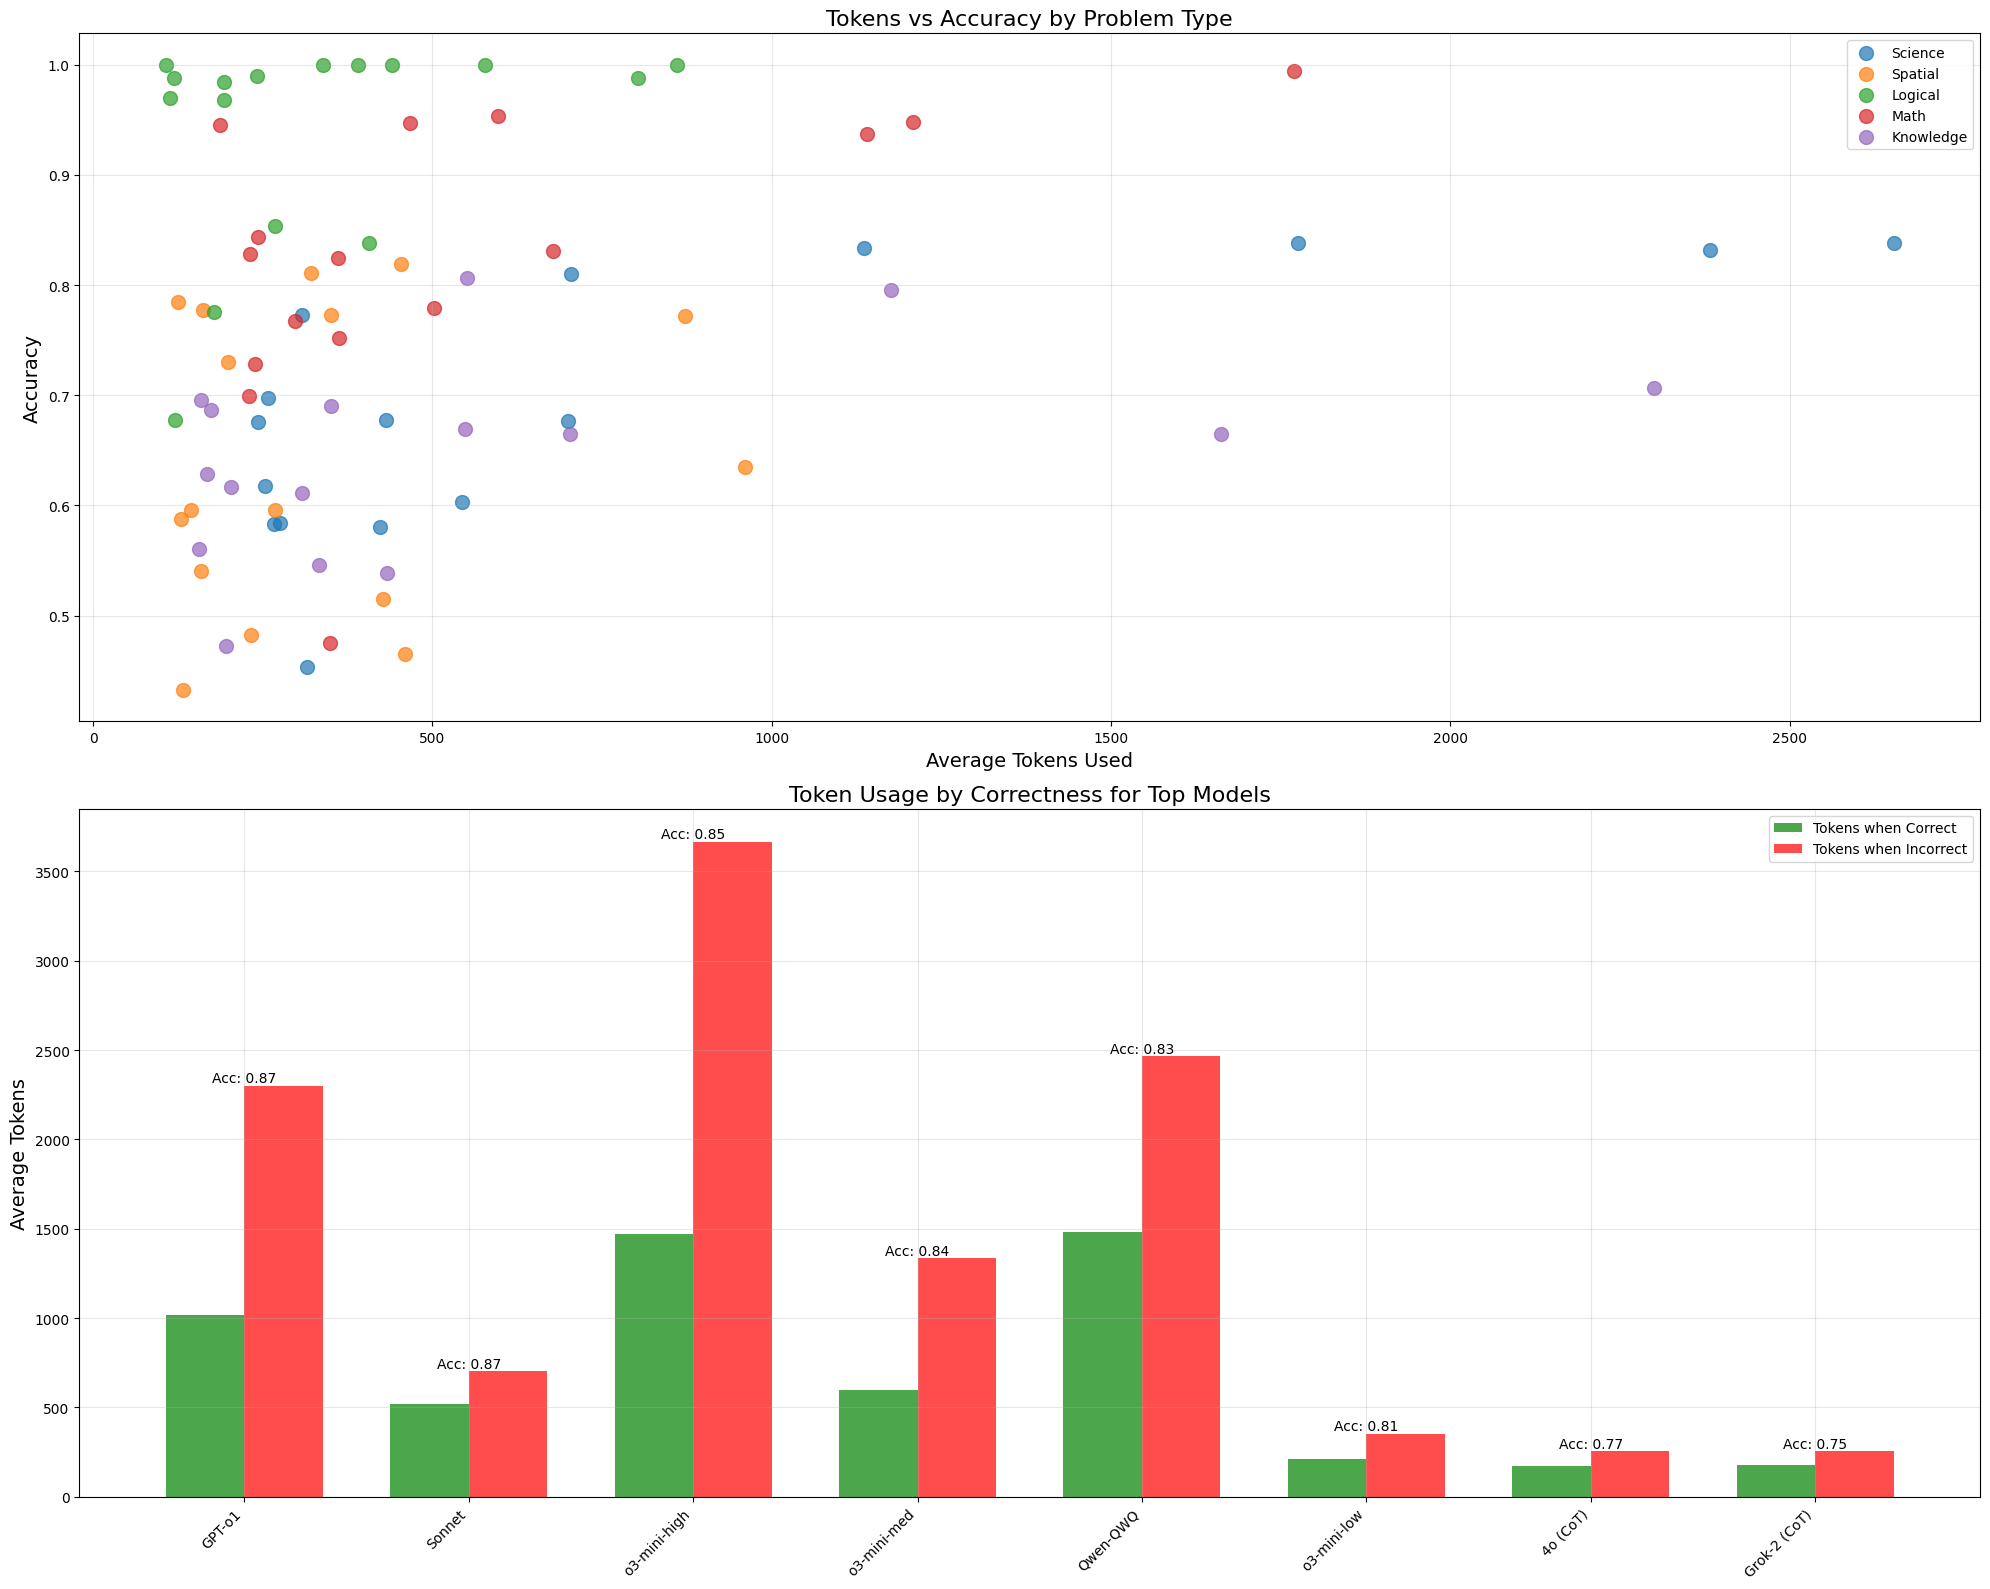

In [71]:
def analyze_token_accuracy_relationship(dfs, names):
    """
    Analyze how token usage relates to accuracy across different models and reasoning methods
    """
    plt.figure(figsize=(20, 12))
    all_results = []
    
    # Filter for reasoning models only
    reasoning_dfs = {k: v for k, v in dfs.items() if any(k.endswith(x) for x in ['_reason', '_cot', '_ltm', '_sc'])}
    
    # Map model names to more readable format
    name_mapping = {
        'df_openai_4o_cot': '4o (CoT)',
        'df_openai_4omini_sc': '4o-mini (SC)', 
        'df_openai_o3mini_medium_reason': 'o3-mini-med',
        'df_openai_o3mini_low_reason': 'o3-mini-low',
        'df_xai_grok2_sc': 'Grok-2 (SC)',
        'df_Meta_Llama_3_1_8B_Instruct_cot': 'Llama-3-8B',
        'df_openai_4omini_cot': '4o-mini (CoT)',
        'df_claude_haiku_cot': 'Haiku (CoT)',
        'df_Meta_Llama_3_1_70B_Instruct_cot': 'Llama-3-70B',
        'df_claude_sonnet_thinking_reason': 'Sonnet',
        'df_xai_grok2_cot': 'Grok-2 (CoT)',
        'df_openai_o3mini_high_reason': 'o3-mini-high',
        'df_openai_o1_reason': 'GPT-o1',
        'df_openai_4omini_ltm': '4o-mini (LtM)',
        'df_xai_grok2_ltm': 'Grok-2 (LtM)',
        'df_Qwen_QWQ_reason': 'Qwen-QWQ',
    }

    # Define marker styles for different methods
    method_markers = {
        'CoT': 'o',  # Circle
        'SC': 's',   # Square
        'LtM': '^',  # Triangle
        'reason': 'D' # Diamond
    }
    
    # Define colors for different model families
    model_colors = {
        'df_openai_4o': '#1f77b4',     # Blue for GPT-4
        'df_openai_4omini': '#ff7f0e',  # Orange for GPT-4-mini
        'df_xai_grok2': '#2ca02c',      # Green for Grok-2
        'df_Meta_Llama': '#d62728',     # Red for Llama
        'df_claude': '#9467bd',         # Purple for Claude
        'df_openai_o3mini_low': '#8c564b',  # Brown for o3-mini-low
        'df_openai_o3mini_medium': '#c49c94',  # Light brown for o3-mini-medium  
        'df_openai_o3mini_high': '#e377c2',  # Pink for o3-mini-high
        'df_openai_o1': '#7f7f7f',       # Gray for GPT-o1
        'df_Qwen_QWQ': '#cb0437',
    }

    for df_name, df in reasoning_dfs.items():
        # Create clean dataframe
        df_clean = df.copy()
        df_clean['llm_confidence'] = pd.to_numeric(df_clean['llm_confidence'], errors='coerce')
        
        # Calculate accuracy and average tokens
        accuracy = df_clean['Correctness'].mean()
        avg_tokens = df_clean['completion_tokens'].mean()
        
        # Calculate tokens by correctness
        avg_tokens_correct = df_clean[df_clean['Correctness'] == 1]['completion_tokens'].mean()
        avg_tokens_incorrect = df_clean[df_clean['Correctness'] == 0]['completion_tokens'].mean()
        
        # Determine marker style and color
        method = next((m for m in ['CoT', 'SC', 'LtM', 'reason'] if m.lower() in df_name.lower()), 'reason')
        model_family = next((k for k in model_colors.keys() if k.lower() in df_name.lower()), 'Other')
        
        all_results.append({
            'model': name_mapping.get(df_name, df_name),
            'accuracy': accuracy,
            'avg_tokens': avg_tokens,
            'avg_tokens_correct': avg_tokens_correct,
            'avg_tokens_incorrect': avg_tokens_incorrect,
            'marker': method_markers[method],
            'color': model_colors[model_family],
            'method': method,
            'family': model_family
        })

    # Create two plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Plot 1: Overall tokens vs accuracy
    for i, result in enumerate(all_results):
        ax1.scatter(result['avg_tokens'], result['accuracy'],
                   marker=result['marker'], c=result['color'], s=150)
        
        y_offset = 0.01 if i % 2 == 0 else -0.01
        ax1.annotate(result['model'],
                    (result['avg_tokens'], result['accuracy']),
                    xytext=(5, y_offset * 100),
                    textcoords='offset points',
                    fontsize=10,
                    ha='left')
    
    # Plot 2: Token difference between correct and incorrect predictions
    for i, result in enumerate(all_results):
        token_difference = result['avg_tokens_correct'] - result['avg_tokens_incorrect']
        ax2.scatter(result['accuracy'], token_difference,
                   marker=result['marker'], c=result['color'], s=150)
        
        x_offset = 0.005 if i % 2 == 0 else -0.005
        ax2.annotate(result['model'],
                    (result['accuracy'], token_difference),
                    xytext=(x_offset * 100, 5),
                    textcoords='offset points',
                    fontsize=10,
                    ha='right' if x_offset < 0 else 'left')

    # Add trend line to the first plot
    x = [result['avg_tokens'] for result in all_results]
    y = [result['accuracy'] for result in all_results]
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax1.plot(sorted(x), p(sorted(x)), "r--", alpha=0.6)
    correlation = np.corrcoef(x, y)[0, 1]
    ax1.text(0.05, 0.95, f"Correlation: {correlation:.3f}", transform=ax1.transAxes, 
             fontsize=12, verticalalignment='top')

    # Customize plots
    ax1.set_title('Average Tokens vs Accuracy', fontsize=14, pad=20)
    ax2.set_title('Accuracy vs Token Difference (Correct - Incorrect)', fontsize=14, pad=20)
    
    ax1.set_xlabel('Average Tokens Used', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    
    ax2.set_xlabel('Accuracy', fontsize=12)
    ax2.set_ylabel('Token Difference (Correct - Incorrect)', fontsize=12)
    
    for ax in [ax1, ax2]:
        ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Create legend
    legend_elements = []
    for method, marker in method_markers.items():
        legend_elements.append(plt.Line2D([0], [0], marker=marker, color='gray',
                                        label=method, markersize=10, linestyle='None'))
    for family, color in model_colors.items():
        legend_elements.append(plt.Line2D([0], [0], marker='o', color=color,
                                        label=family.replace('df_',''), markersize=10, linestyle='None'))

    # Add legend to figure
    fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(0.98, 0.5))
    
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    return fig

# Create a more detailed visualization of tokens vs accuracy by problem type
def analyze_tokens_by_problem_type(dfs, names):
    """
    Analyze token usage and accuracy across different problem types
    """
    # Filter for reasoning models only
    reasoning_dfs = {k: v for k, v in dfs.items() if any(k.endswith(x) for x in ['_reason', '_cot', '_ltm', '_sc'])}
    
    # Combine all dataframes with a model identifier column
    combined_df = pd.DataFrame()
    for df_name, df in reasoning_dfs.items():
        df_copy = df.copy()
        df_copy['model'] = df_name
        combined_df = pd.concat([combined_df, df_copy])
    
    # Map model names to more readable format
    model_mapping = {
        'df_openai_4o_cot': '4o (CoT)',
        'df_openai_4omini_sc': '4o-mini (SC)', 
        'df_openai_o3mini_medium_reason': 'o3-mini-med',
        'df_openai_o3mini_low_reason': 'o3-mini-low',
        'df_xai_grok2_sc': 'Grok-2 (SC)',
        'df_Meta_Llama_3_1_8B_Instruct_cot': 'Llama-3-8B',
        'df_openai_4omini_cot': '4o-mini (CoT)',
        'df_claude_haiku_cot': 'Haiku (CoT)',
        'df_Meta_Llama_3_1_70B_Instruct_cot': 'Llama-3-70B',
        'df_claude_sonnet_thinking_reason': 'Sonnet',
        'df_xai_grok2_cot': 'Grok-2 (CoT)',
        'df_openai_o3mini_high_reason': 'o3-mini-high',
        'df_openai_o1_reason': 'GPT-o1',
        'df_openai_4omini_ltm': '4o-mini (LtM)',
        'df_xai_grok2_ltm': 'Grok-2 (LtM)',
        'df_Qwen_QWQ_reason': 'Qwen-QWQ',
    }
    combined_df['model_name'] = combined_df['model'].map(model_mapping)
    
    # If 'problem_type' column doesn't exist, extract from 'prompt'
    if 'Type' not in combined_df.columns and 'prompt' in combined_df.columns:
        # This is a placeholder - you should implement logic to extract problem type
        # For example, if problem types are mentioned in prompts
        combined_df['Type'] = 'Unknown'
    
    # If problem_type column exists, use it
    if 'Type' in combined_df.columns:
        fig, axs = plt.subplots(2, 1, figsize=(20, 16))
        
        # Group by problem type and model
        problem_types = combined_df['Type'].unique()
        
        # For each problem type, calculate average tokens and accuracy
        tokens_by_type = {}
        accuracy_by_type = {}
        
        for problem_type in problem_types:
            df_type = combined_df[combined_df['Type'] == problem_type]
            models = df_type['model_name'].unique()
            
            tokens_by_type[problem_type] = [df_type[df_type['model_name'] == model]['completion_tokens'].mean() 
                                          for model in models]
            accuracy_by_type[problem_type] = [df_type[df_type['model_name'] == model]['Correctness'].mean() 
                                            for model in models]
            
            # Plot tokens vs accuracy for this problem type
            axs[0].scatter(tokens_by_type[problem_type], accuracy_by_type[problem_type], 
                          label=problem_type, alpha=0.7, s=100)
        
        # Plot tokens vs accuracy across problem types
        axs[0].set_title('Tokens vs Accuracy by Problem Type', fontsize=16)
        axs[0].set_xlabel('Average Tokens Used', fontsize=14)
        axs[0].set_ylabel('Accuracy', fontsize=14)
        axs[0].grid(True, alpha=0.3)
        axs[0].legend()
        
        # Bar chart of token usage by correctness for top models
        top_models = combined_df.groupby('model_name')['Correctness'].mean().sort_values(ascending=False).head(8).index
        
        token_data = []
        for model in top_models:
            df_model = combined_df[combined_df['model_name'] == model]
            correct_tokens = df_model[df_model['Correctness'] == 1]['completion_tokens'].mean()
            incorrect_tokens = df_model[df_model['Correctness'] == 0]['completion_tokens'].mean()
            accuracy = df_model['Correctness'].mean()
            token_data.append({
                'model': model,
                'correct_tokens': correct_tokens,
                'incorrect_tokens': incorrect_tokens,
                'accuracy': accuracy
            })
        
        # Sort by accuracy
        token_data.sort(key=lambda x: x['accuracy'], reverse=True)
        
        # Plot bar chart
        ind = np.arange(len(token_data))
        width = 0.35
        
        axs[1].bar(ind - width/2, [d['correct_tokens'] for d in token_data], width, 
                 label='Tokens when Correct', color='green', alpha=0.7)
        axs[1].bar(ind + width/2, [d['incorrect_tokens'] for d in token_data], width, 
                 label='Tokens when Incorrect', color='red', alpha=0.7)
        
        # Add accuracy as text
        for i, d in enumerate(token_data):
            axs[1].text(i, max(d['correct_tokens'], d['incorrect_tokens']) + 20, 
                      f"Acc: {d['accuracy']:.2f}", ha='center', fontsize=10)
        
        axs[1].set_title('Token Usage by Correctness for Top Models', fontsize=16)
        axs[1].set_xticks(ind)
        axs[1].set_xticklabels([d['model'] for d in token_data], rotation=45, ha='right')
        axs[1].set_ylabel('Average Tokens', fontsize=14)
        axs[1].legend()
        axs[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig
    
    return None

# Call both functions to create the visualizations
fig1 = analyze_token_accuracy_relationship(dfs, list(dfs.keys()))
fig2 = analyze_tokens_by_problem_type(dfs, list(dfs.keys()))

plt.show()